## 噪声
### 轨旁噪声降低效果不低于3dB(A)；
### 钢轨降噪效果取400-3000Hz范围内加权平均值不低于5dB（re  1x10-6 m/s2）；
### 降噪效果的测量和评价满足Gb/T 19846、GB10071及HJ453等相关标准要求。
## 衰减率：
### 安装阻尼器后轨道横向和垂向振动衰减率在4000Hz以上频段均不小于5dB/m，
### 160-4000Hz频段轨道横向与垂向平均振动衰减率不小于5.5dB/m

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
import xlrd

In [18]:
#1/3倍频程中心频率
freqs_3 = np.array([1.00e+00, 1.25e+00, 1.60e+00, 2.00e+00, 2.50e+00, 3.15e+00,
                    4.00e+00, 5.00e+00, 6.30e+00, 8.00e+00, 1.00e+01, 1.25e+01, 
                    1.60e+01, 2.00e+01, 2.50e+01, 3.15e+01, 4.00e+01, 5.00e+01,
                    6.30e+01, 8.00e+01, 1.00e+02, 1.25e+02, 1.60e+02, 2.00e+02,
                    2.50e+02, 3.15e+02, 4.00e+02, 5.00e+02, 6.30e+02, 8.00e+02, 
                    1.00e+03, 1.25e+03, 1.60e+03, 2.00e+03, 2.50e+03, 3.15e+03,
                    4.00e+03, 5.00e+03, 6.30e+03, 8.00e+03, 1.00e+04, 1.25e+04, 
                    1.60e+04,2.00e+04])
#v0
v0 = 1.00e-6
#1-80HZ 计权
print(freqs_3 [:27])
#160-4kHZ计权
print(freqs_3 [22:37])

[  1.     1.25   1.6    2.     2.5    3.15   4.     5.     6.3    8.
  10.    12.5   16.    20.    25.    31.5   40.    50.    63.    80.
 100.   125.   160.   200.   250.   315.   400.  ]


In [3]:
#Z计权系数
Wght_fct = np.array([-6.33, -6.29, -6.12, -5.49, -4.01, -1.90,
                     -0.29,  0.33,  0.46,  0.31, -0.10, -0.89, 
                     -2.28, -3.93, -5.80, -7.86, -10.05, -12.19,
                     -14.61, -17.56, -21.04, -25.35, -30.91, -36.38,
                     -42.04, -48.00, -54.20])

print(len(Wght_fct))

27


In [4]:
def nextpow2(max_ele):
    n = 0
    while 2**n < max_ele:
        n += 1
    return 2**n

In [19]:
def calculate(address, measure_frqs, freqs_order, Weighting_factor,channal):
    
    #读取数据
    workbook = xlrd.open_workbook(address)
    Data_sheet = workbook.sheets()[0] 
    #声压时程
    t = Data_sheet.col_values(0)
    p_t  = Data_sheet.col_values(channal)
    data_len = len(p_t)
    plt.figure(figsize=(14,8), dpi=200)
    plt.plot(t,p_t)
    
    #加汉宁窗(恢复系数为1.633)
    #p_t = 1.633 * np.hamming(data_len) * p_t
    #p_t = 1.633 * np.hanning(data_len) * p_t
    nfft = nextpow2(data_len)
    p_f = np.fft.fft(p_t,nfft)
    fx =  measure_frqs/2 * np.linspace(0,1,nfft/2)
    w = 2 * np.abs(p_f[:int(nfft/2)]/data_len)
    #w = np.abs(np.abs(p_f[:int(nfft/2)]/data_len))
    #绘制频谱
    plt.figure(figsize=(14,8), dpi=200)
    plt.semilogx(fx,w)
    
     # 求取1/3频程起止频率
    f_start =  freqs_order * 2 ** (-1 / 6)  
    f_stop = freqs_order * 2 ** (1 / 6)  
    
    #print(f_start)
    #分频带滤波   
    
    m = len(freqs_order)
    y_out = np.zeros(m)
    #'''
    #print(index_start,index_end)
    for i in range(m):
        index_start = int(np.round(f_start[i]*nfft/measure_frqs))
        index_end = int(np.round(f_stop[i]*nfft/measure_frqs))
        #index_end = int(np.round(f_start[i+1]*nfft/measure_frqs))
        data = np.zeros(nfft,dtype=np.complex)
        data[index_start:index_end] = p_f[index_start:index_end]
        data[nfft-1-index_end:nfft-1-index_start] = p_f[nfft-1-index_end:nfft-1-index_start]
        if f_stop[i]>measure_frqs/2:
            y_out[i] = v0
        else:
            data_ifft = np.fft.ifft(data,nfft)
            y_out[i] = np.power(np.var(data_ifft[:data_len].real),0.5)
    
    #print(y_out)

    y_out_1 = 10*np.log10(y_out**2 * 9.8**2/v0**2)
    #y_out_Z = 10*np.log10(np.power(10,(y_out_1+Weighting_factor)/10))
    non_out = 10*np.log10(sum(np.power(10,y_out_1/10)))
    #A_out = 10*np.log10(sum(np.power(10,(y_out_1+Weighting_factor)/10)))

    #return y_out_1,y_out_Z,non_out,A_out 
    return y_out_1,non_out

D:\anaconda\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


number of chanal:  1
non= 137.69143527273107
[105.77876605 101.32797371 104.121466   116.48340649 112.08106444
 122.15789036 124.83034432 127.93427323 126.64479451 131.33449298
 134.33689127 118.94138253 119.64049177 109.92722992 103.45635213]
number of chanal:  2
non= 142.12758930794953
[123.1781453  116.479146   118.78831655 127.19281769 117.22070966
 122.72385923 122.63136359 122.97332789 125.26059649 126.77960912
 137.31534113 139.26043533 122.71673324 110.33333639 111.6304703 ]
number of chanal:  3
non= 137.26876582568974
[110.09111104 102.11677986 101.93984097 114.38173323 106.65554138
 117.28087158 120.20462016 123.81533064 134.61568716 132.24980155
 124.01734771 117.04996973 109.81326861 101.70592143  93.07148183]
number of chanal:  4
non= 136.52788351322027
[116.7624507  109.37813081 107.84803903 117.25061071 109.22992667
 119.05453135 116.57374271 119.58219927 126.93466053 135.35205716
 123.02812181 110.1675817  110.10712235 105.80315038 108.42195421]
number of chanal:  5
non

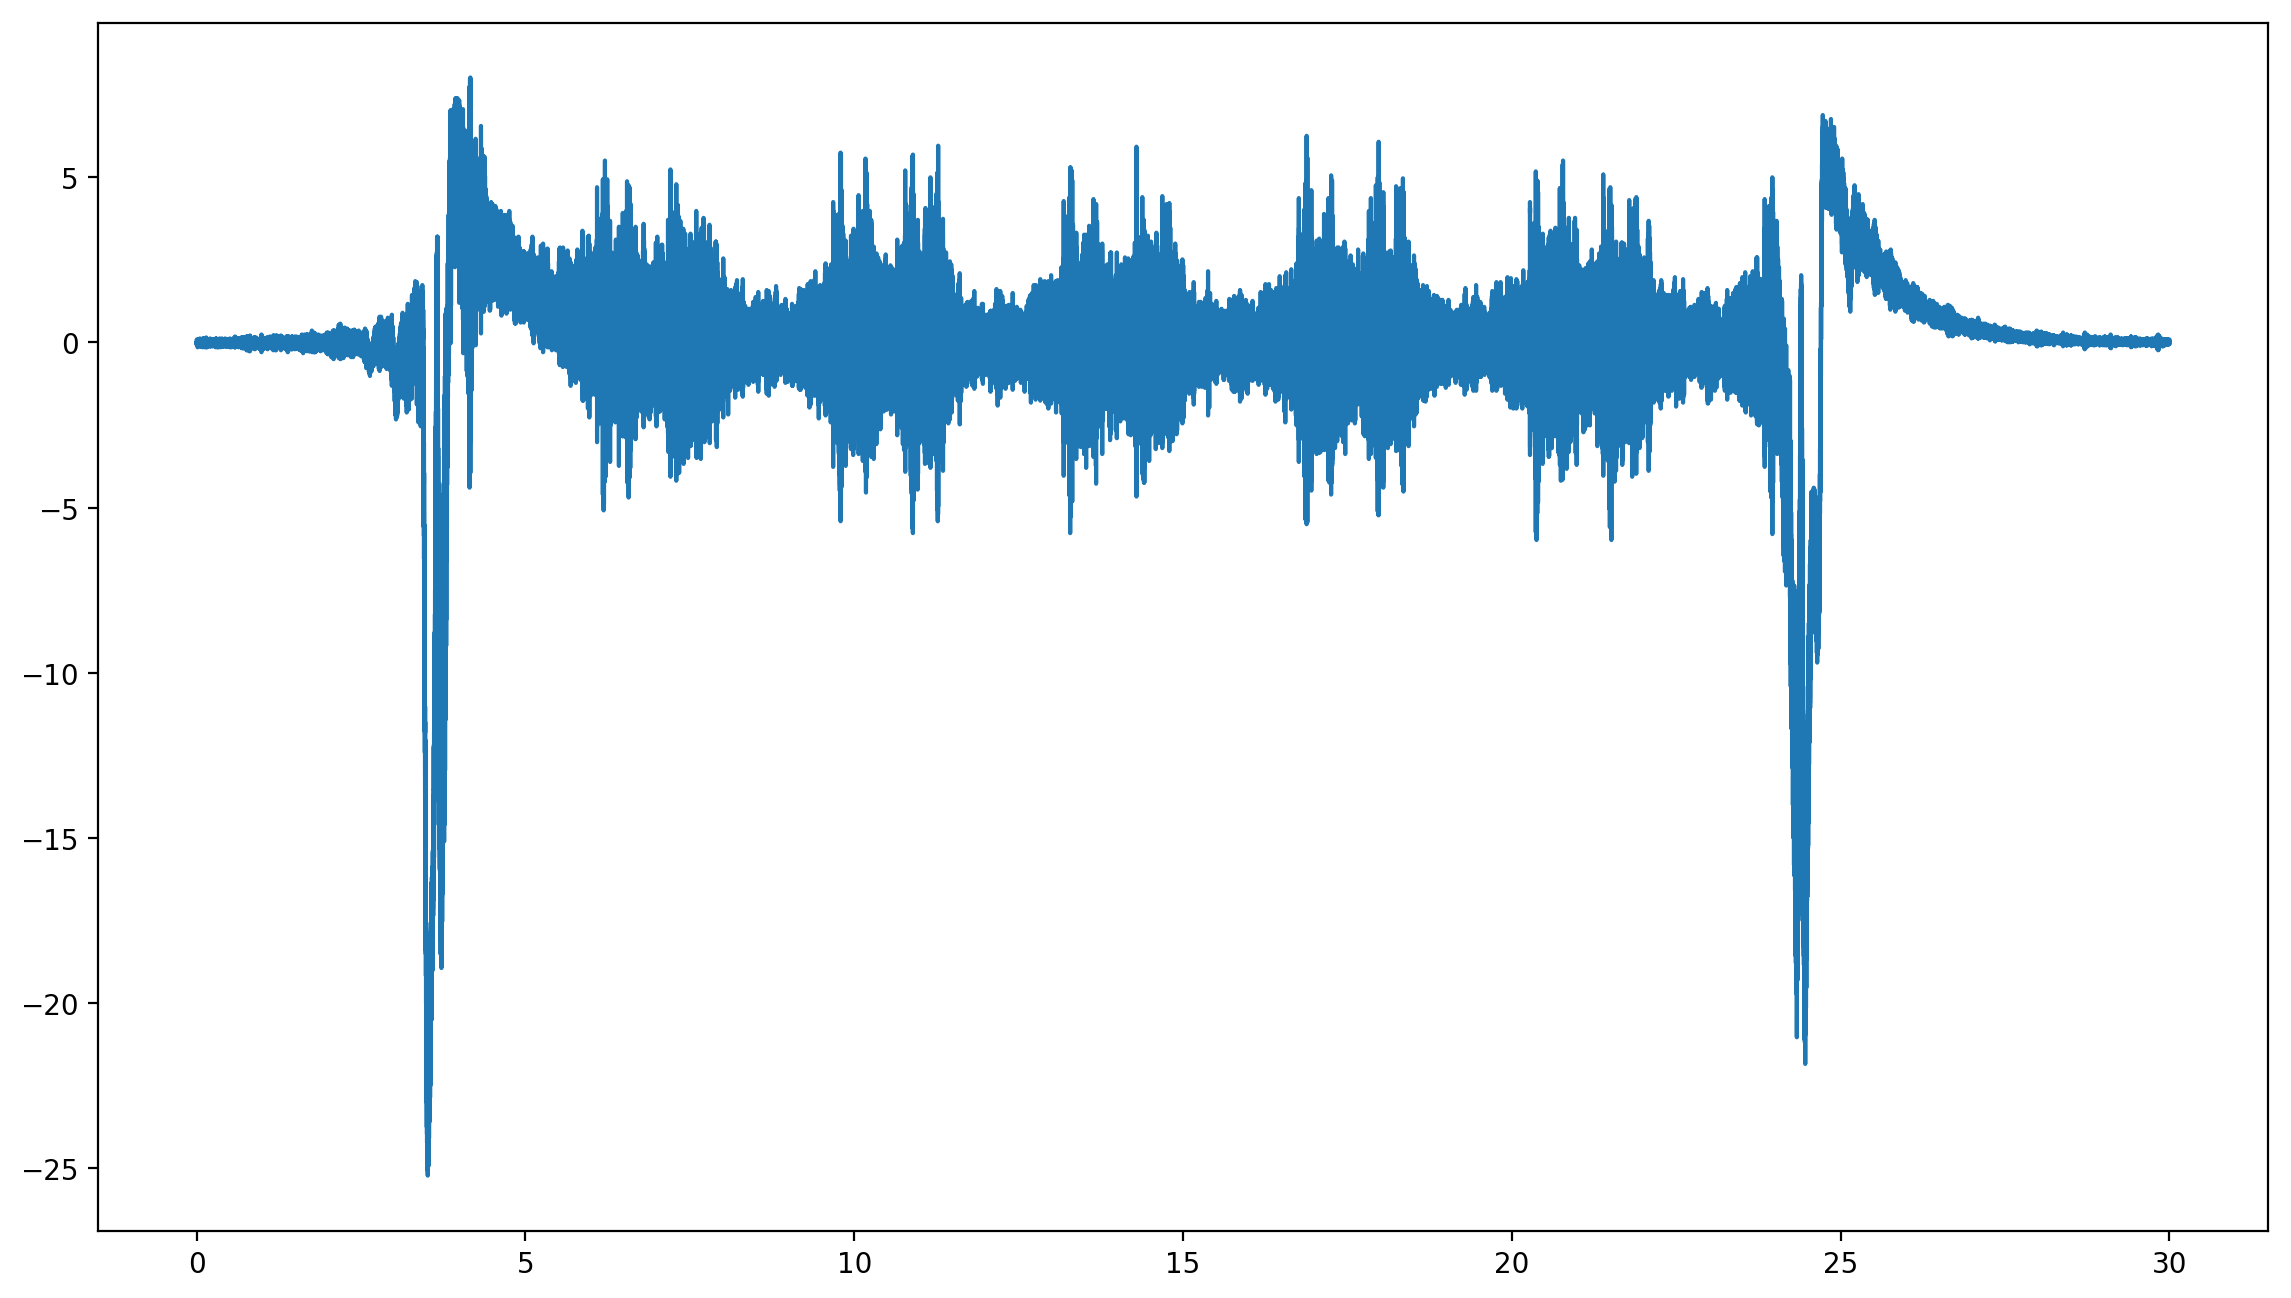

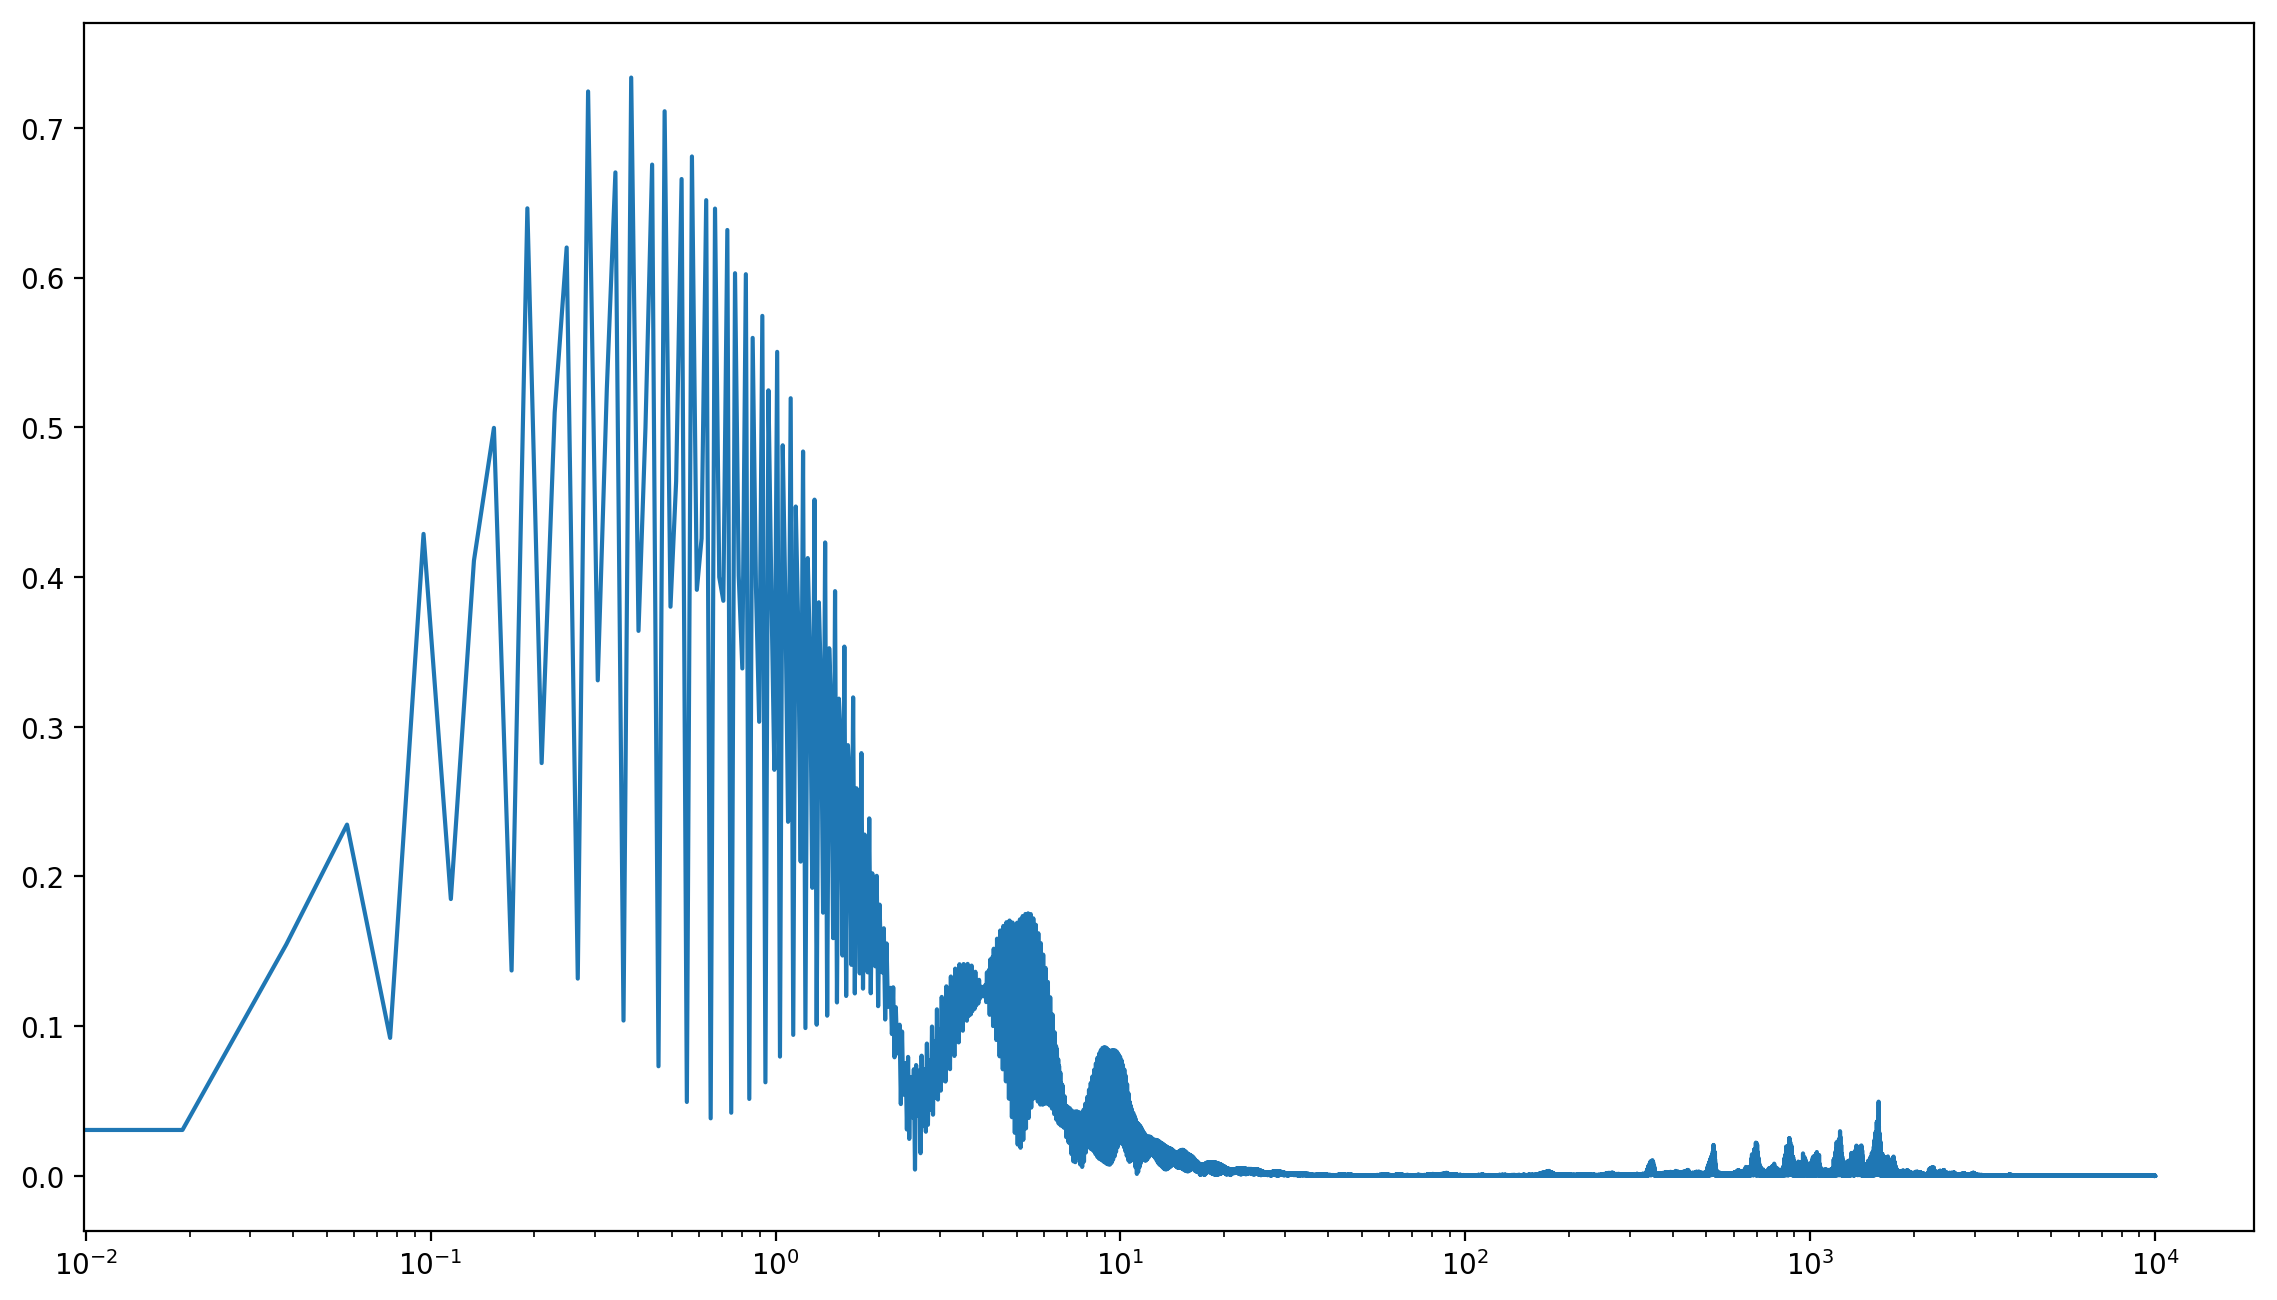

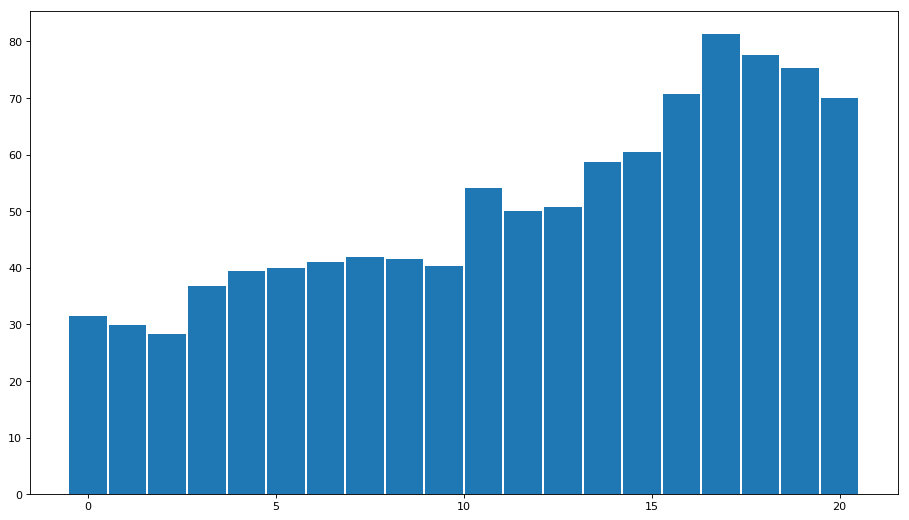

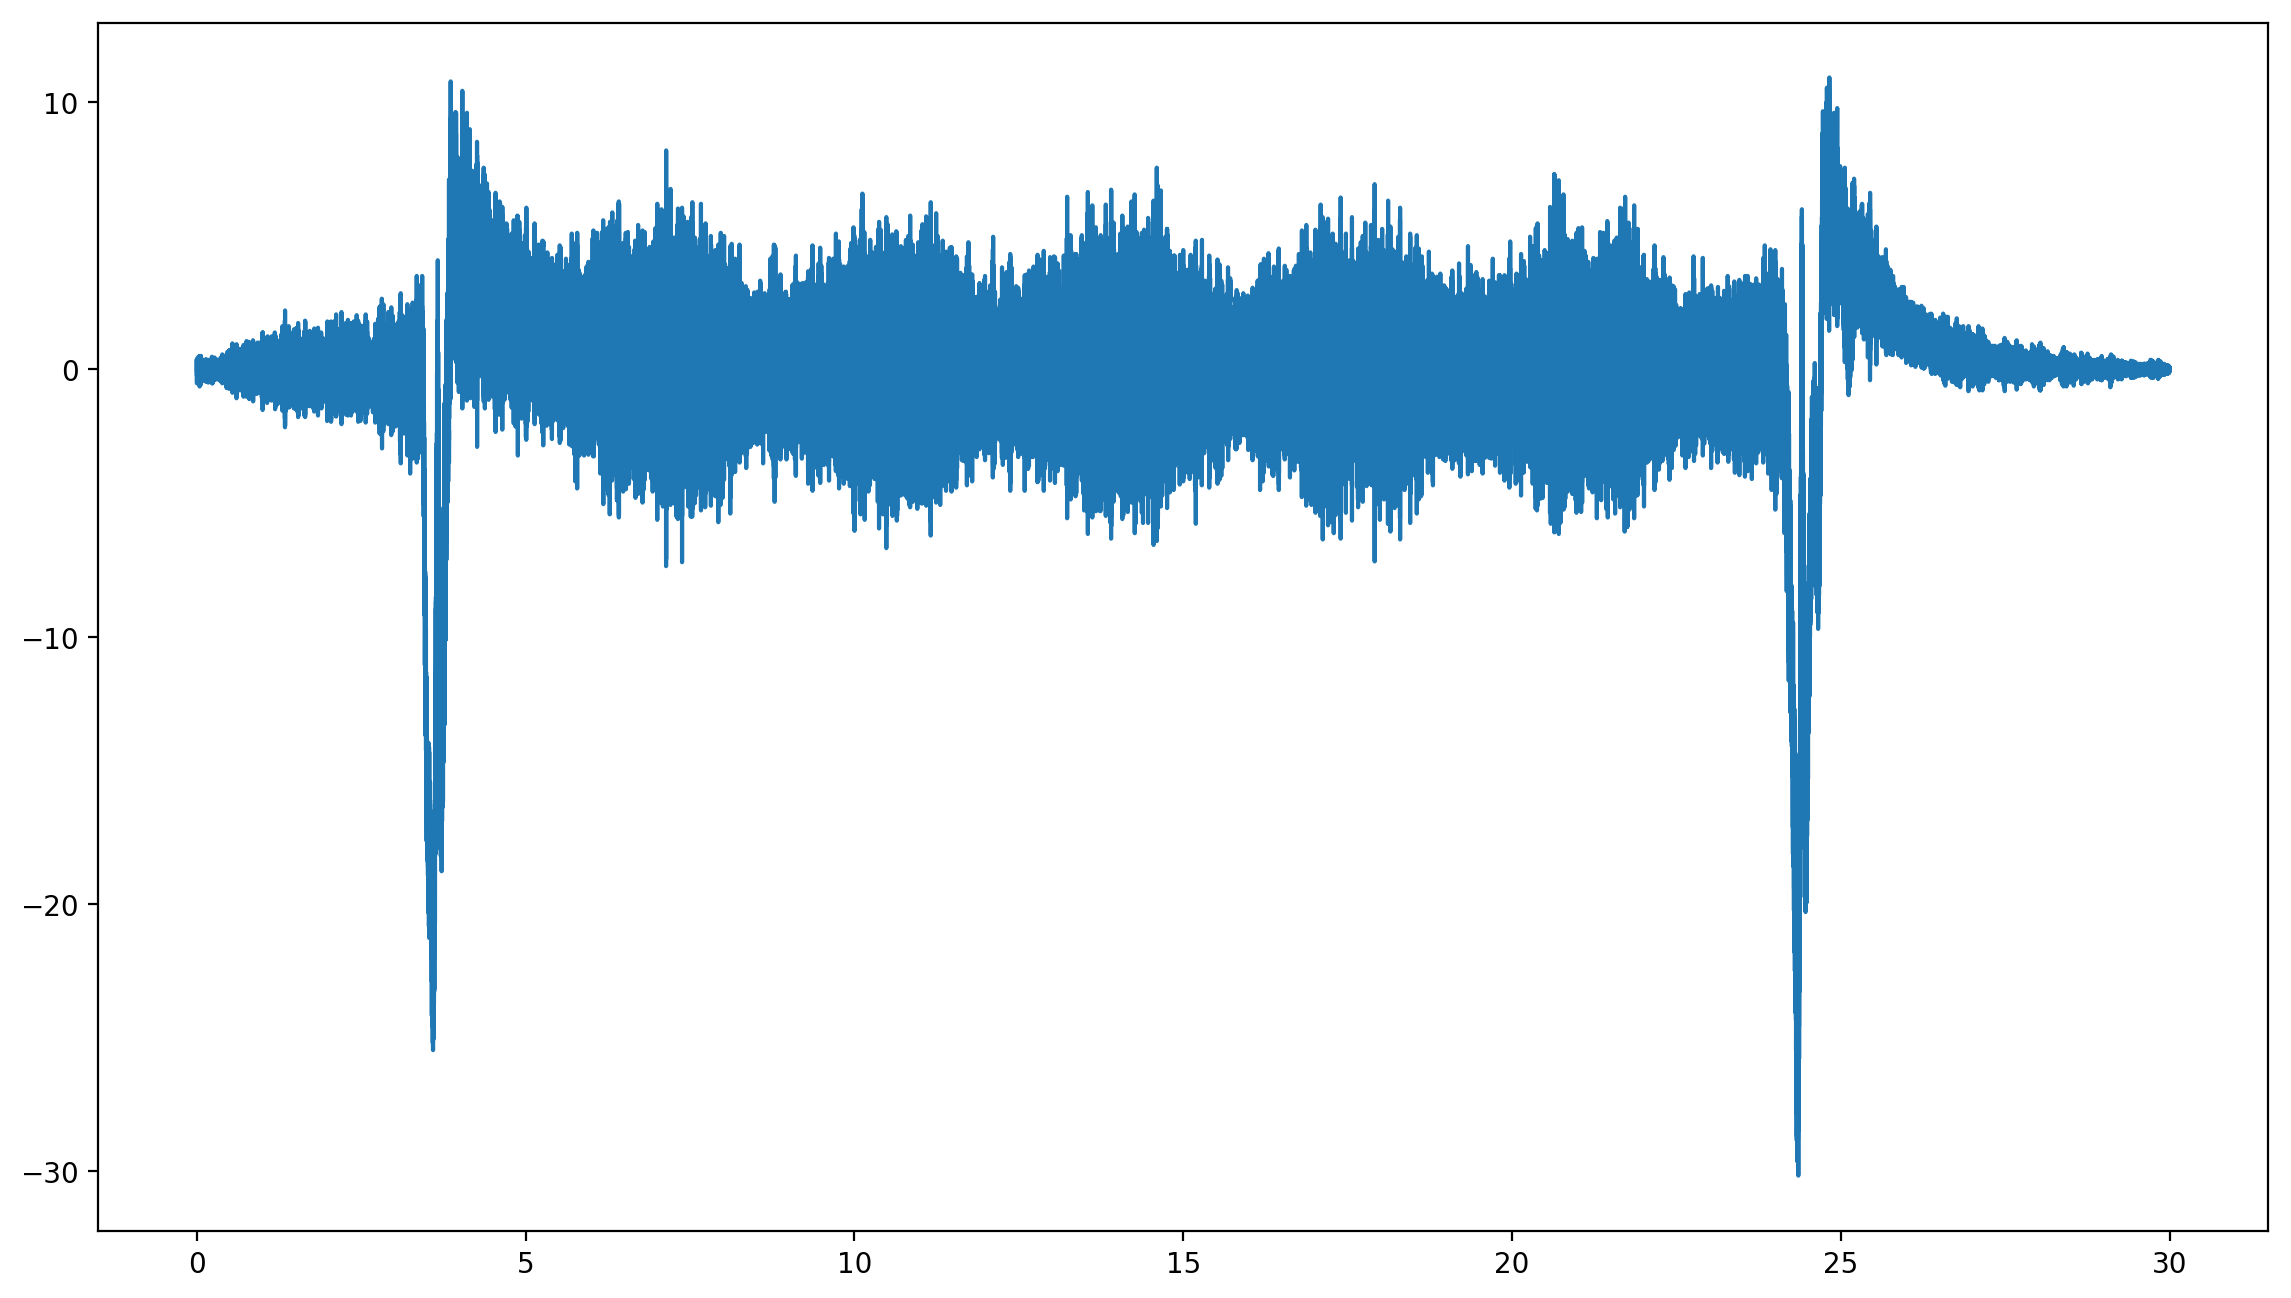

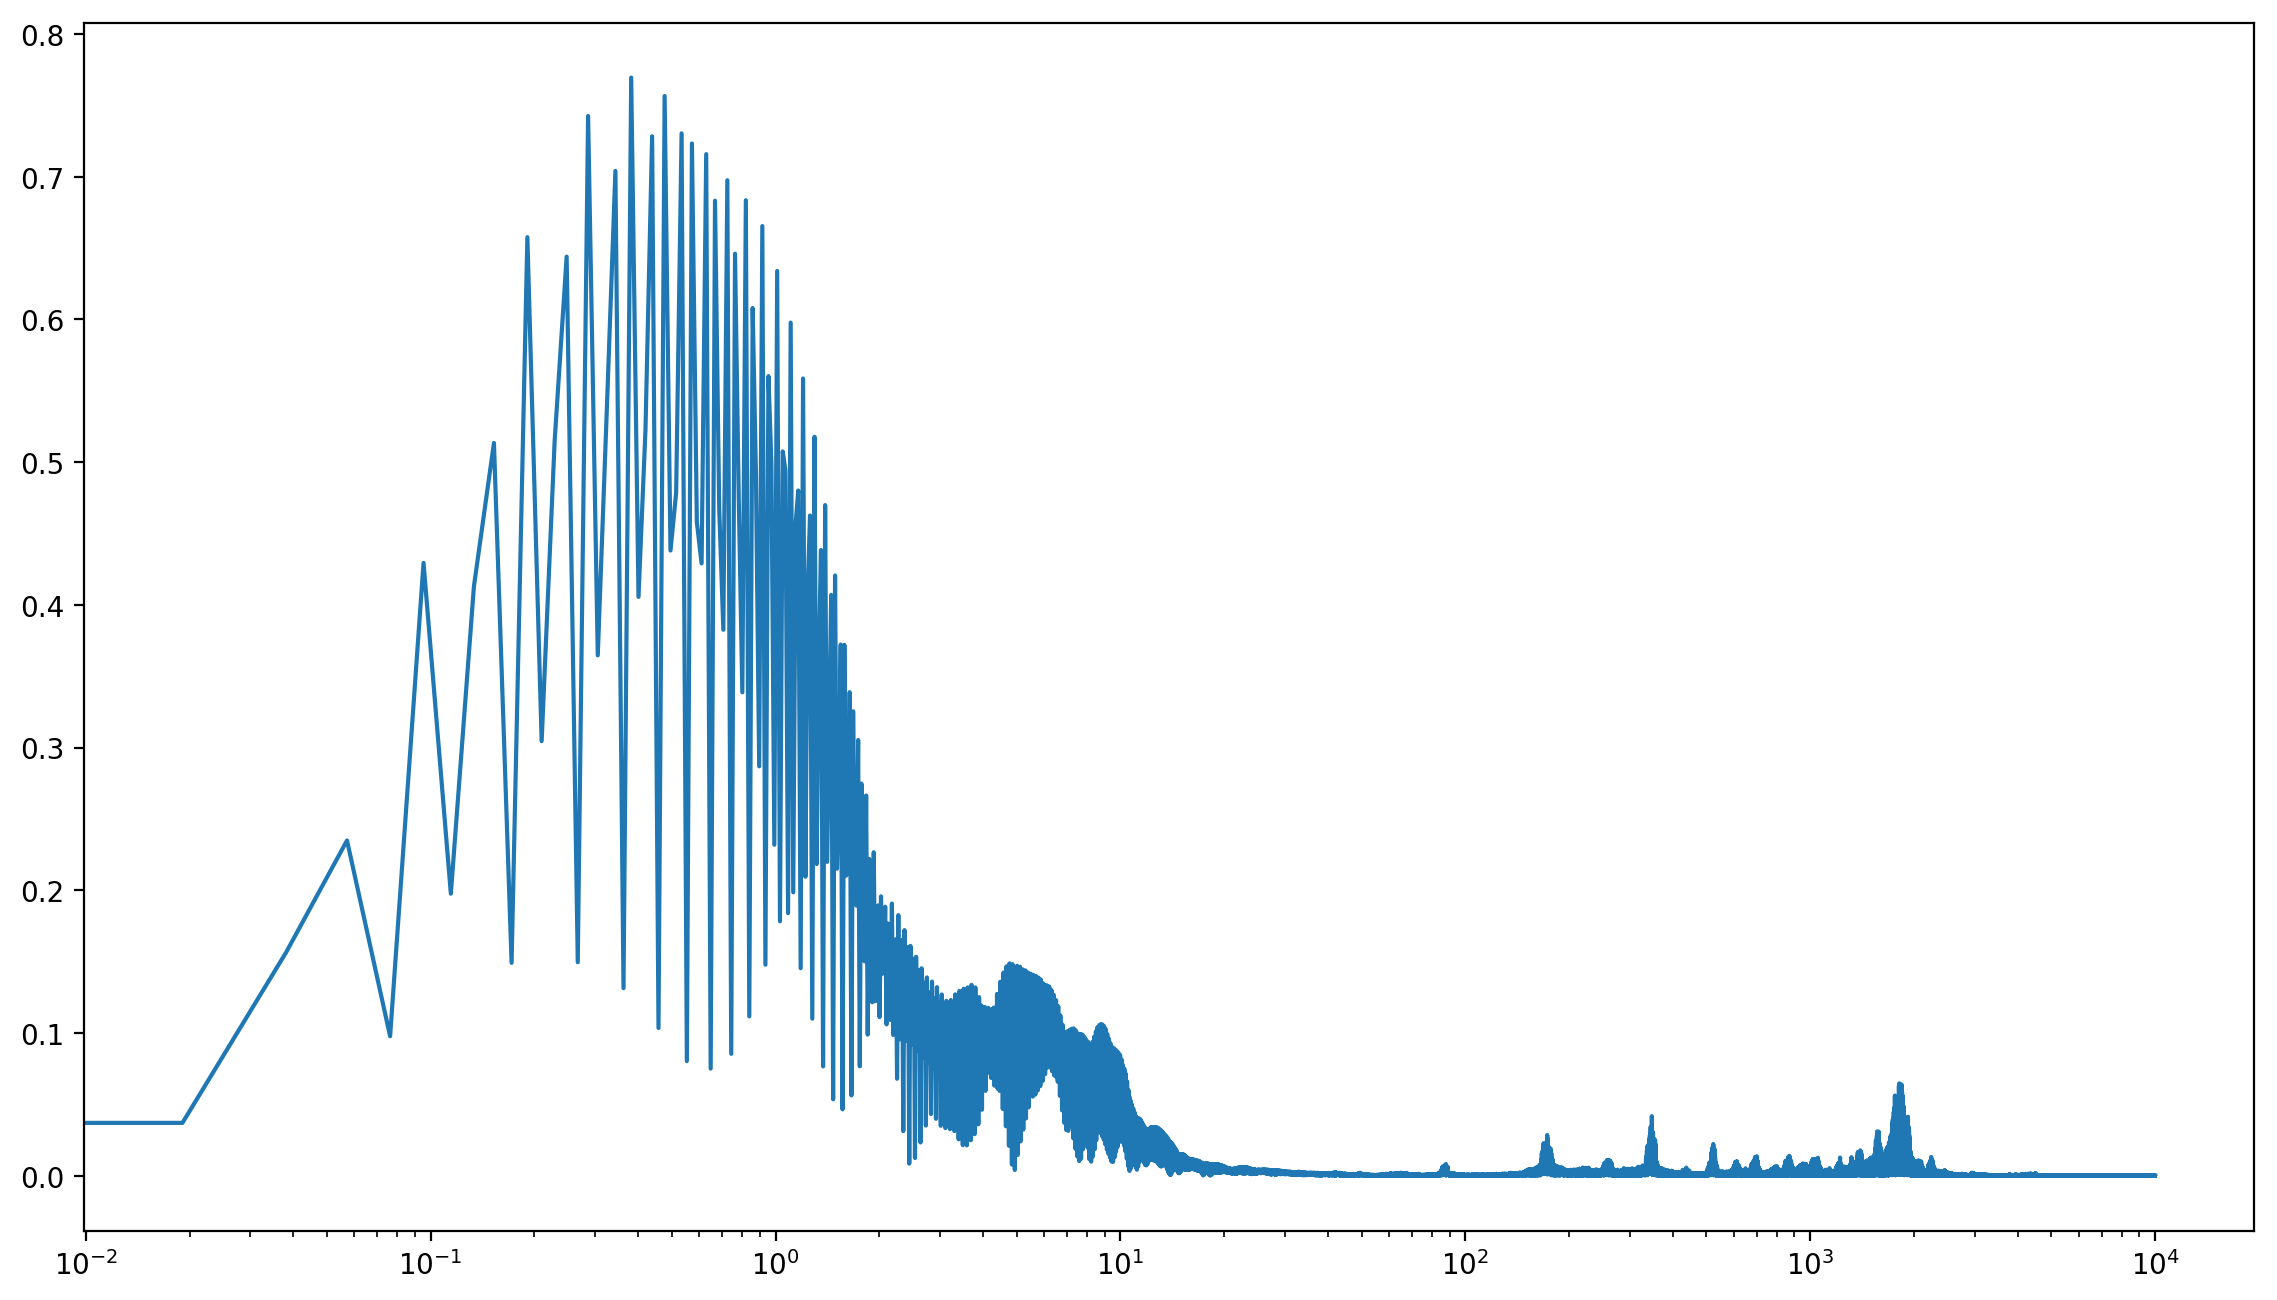

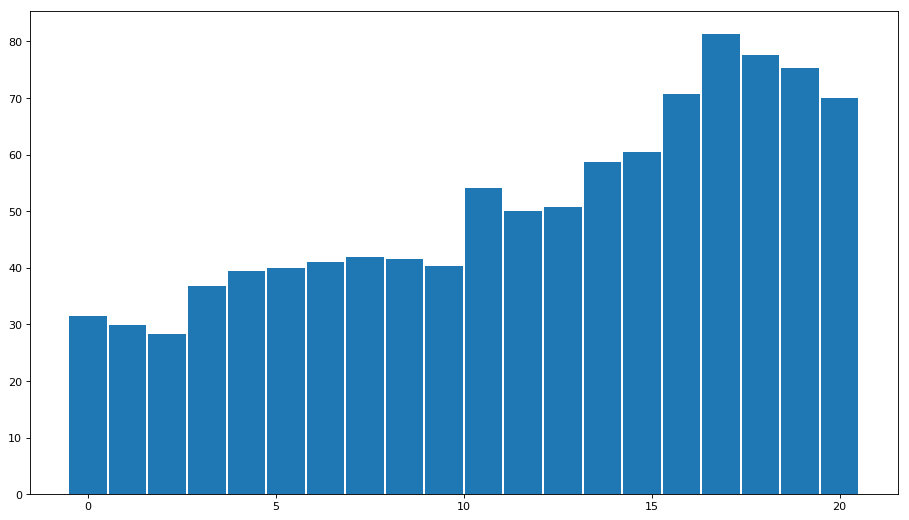

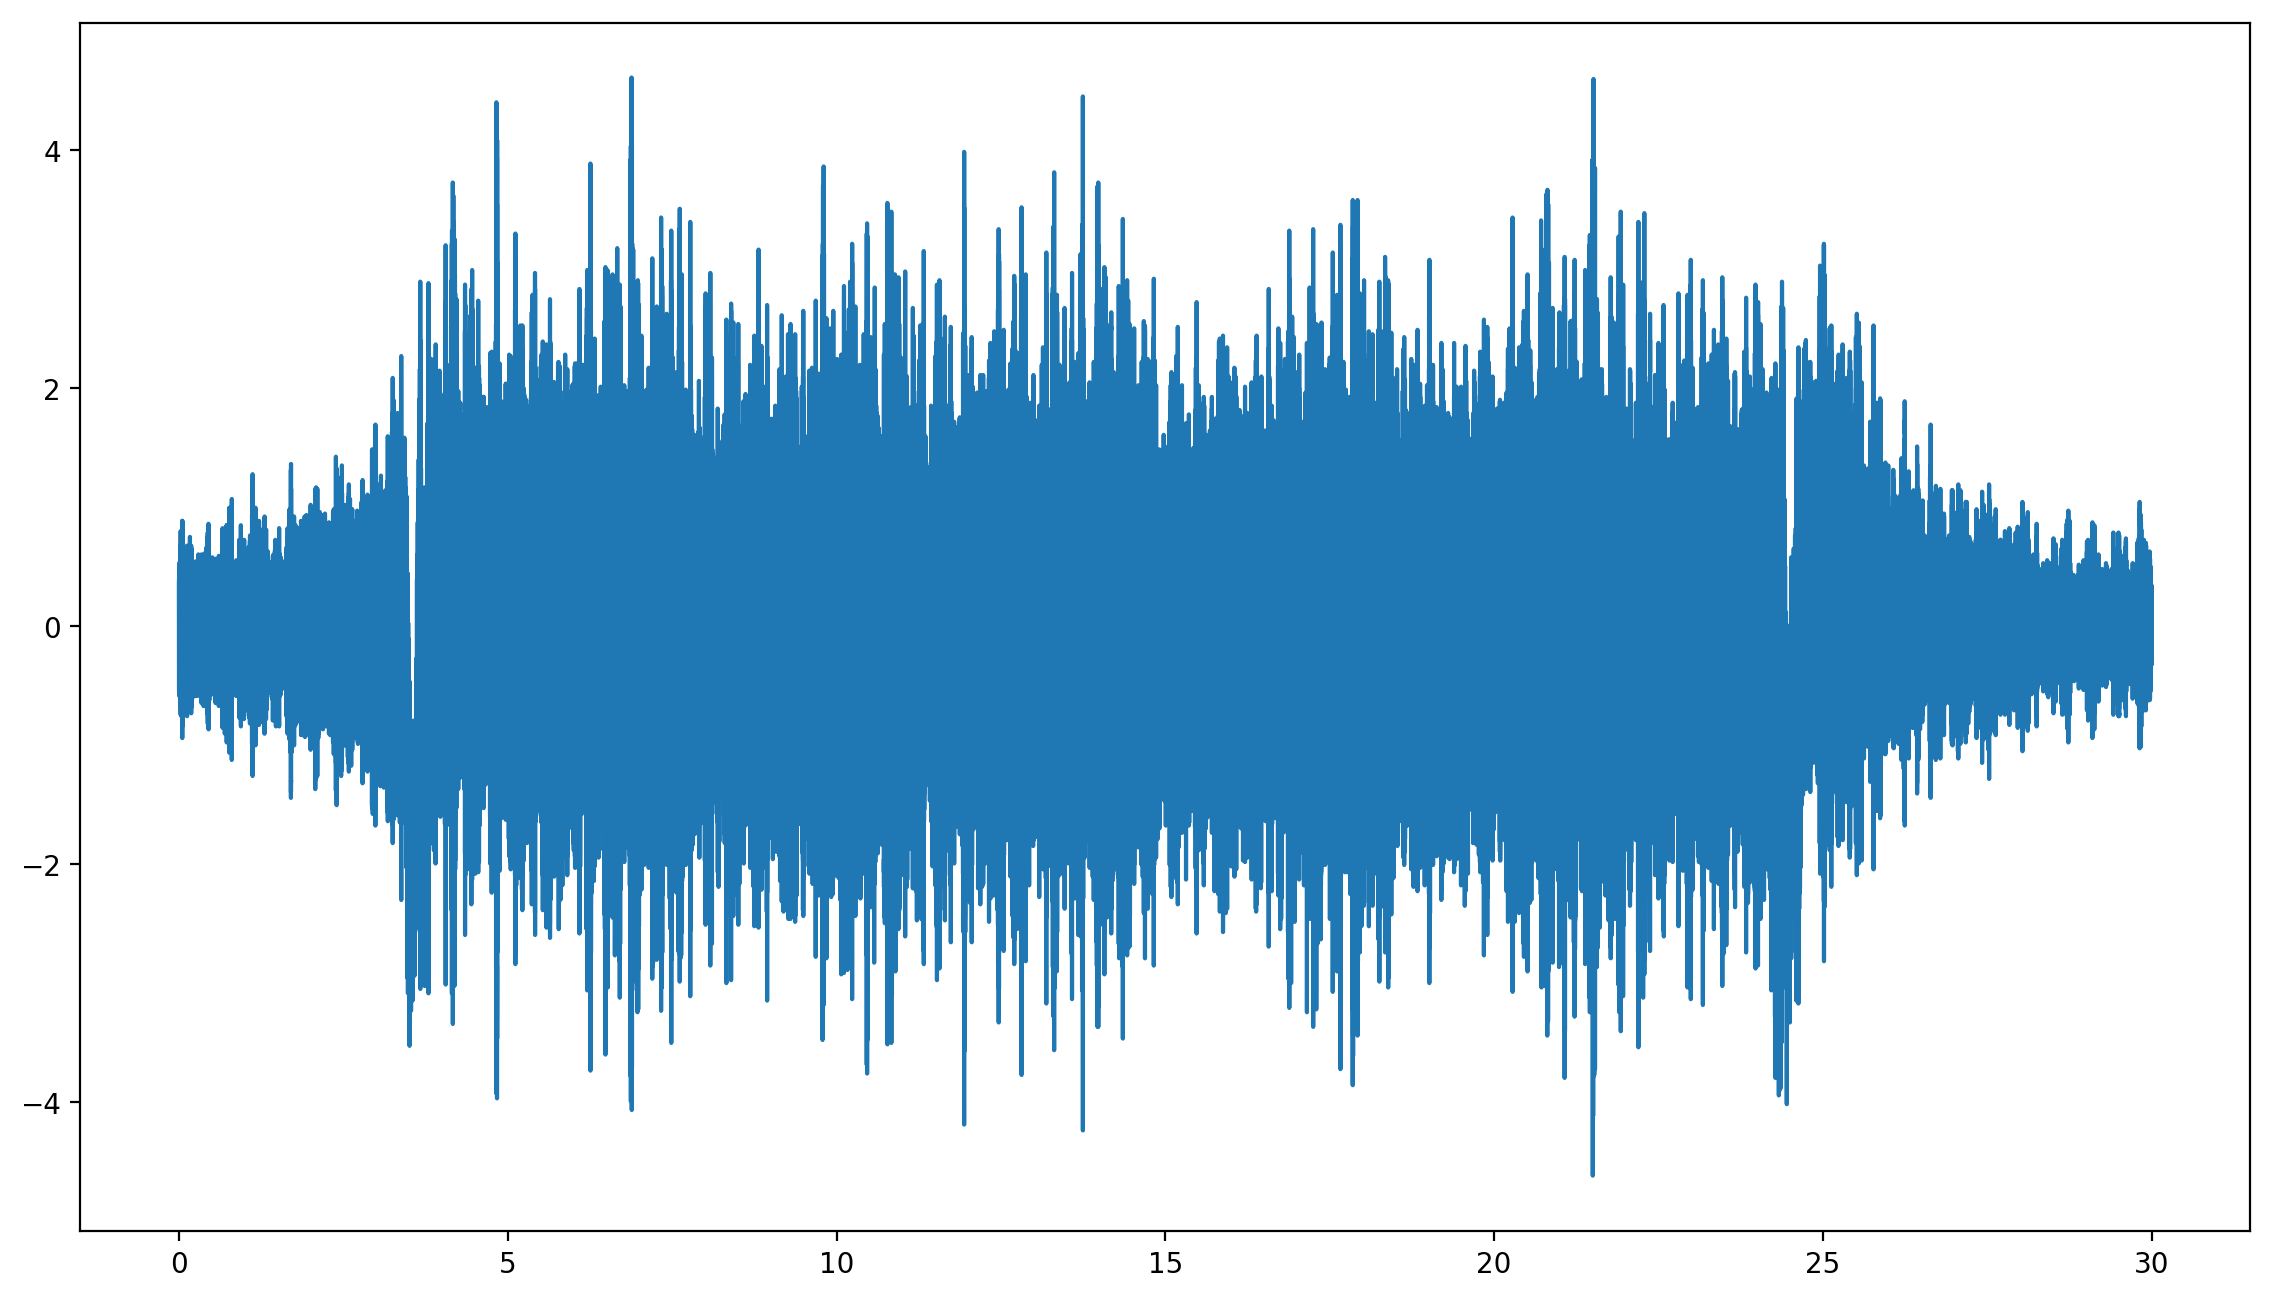

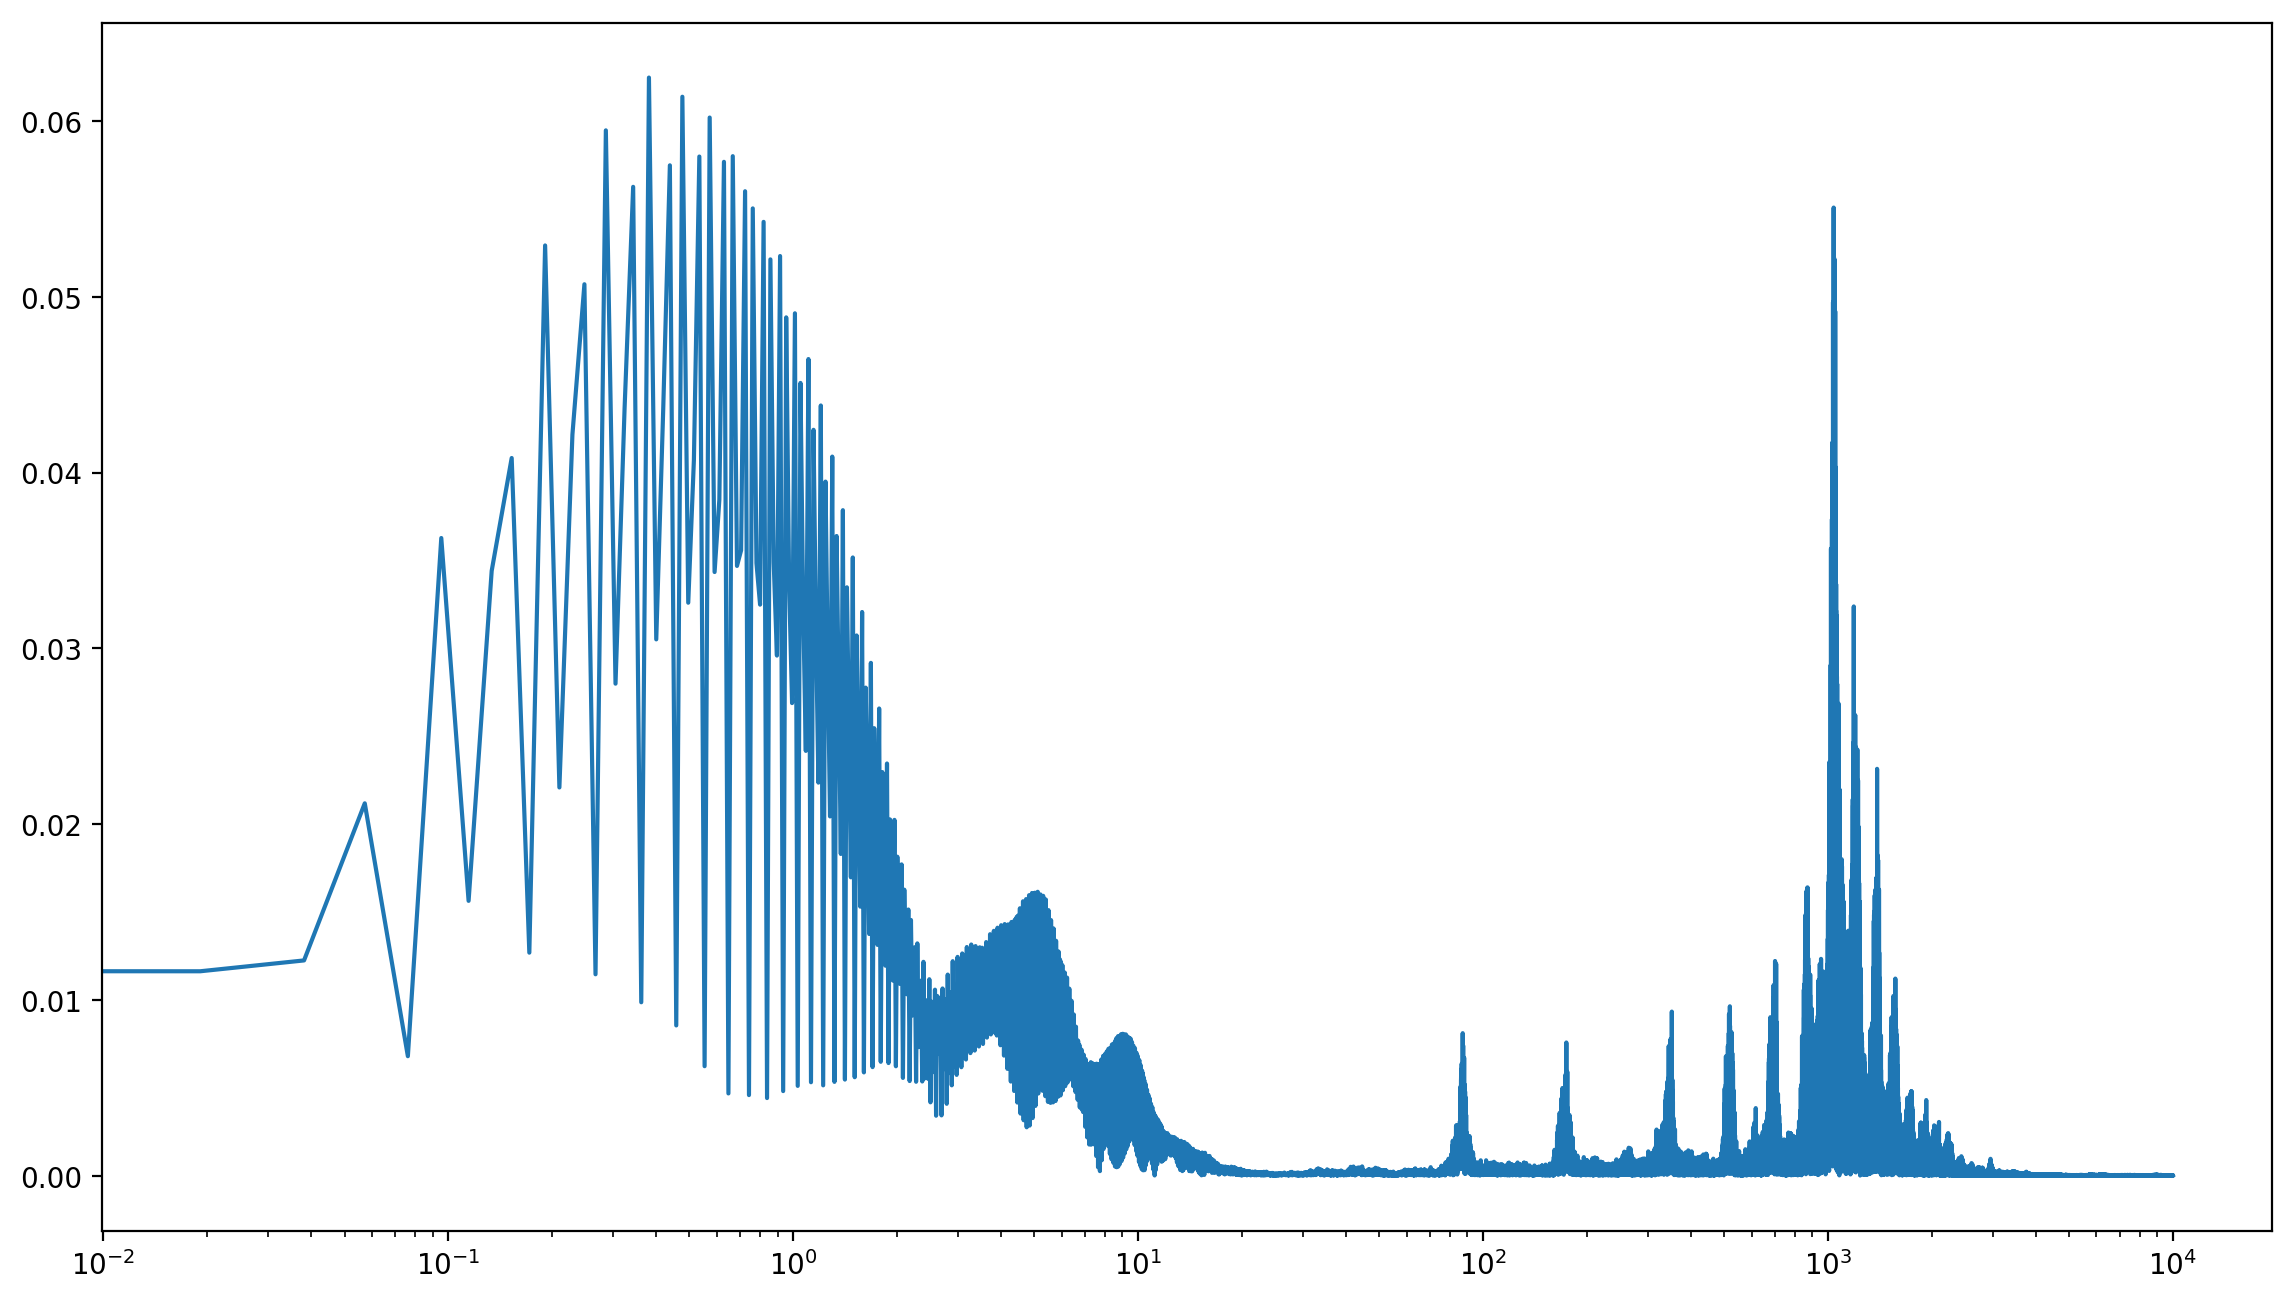

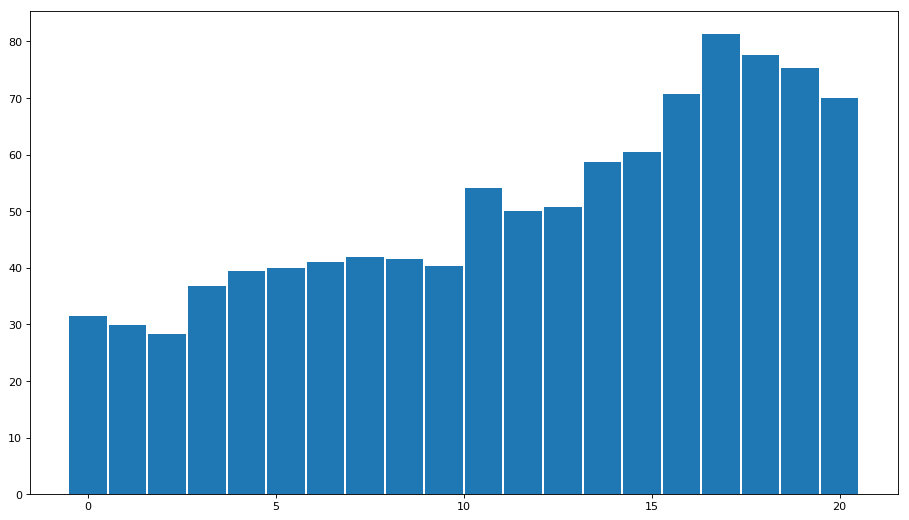

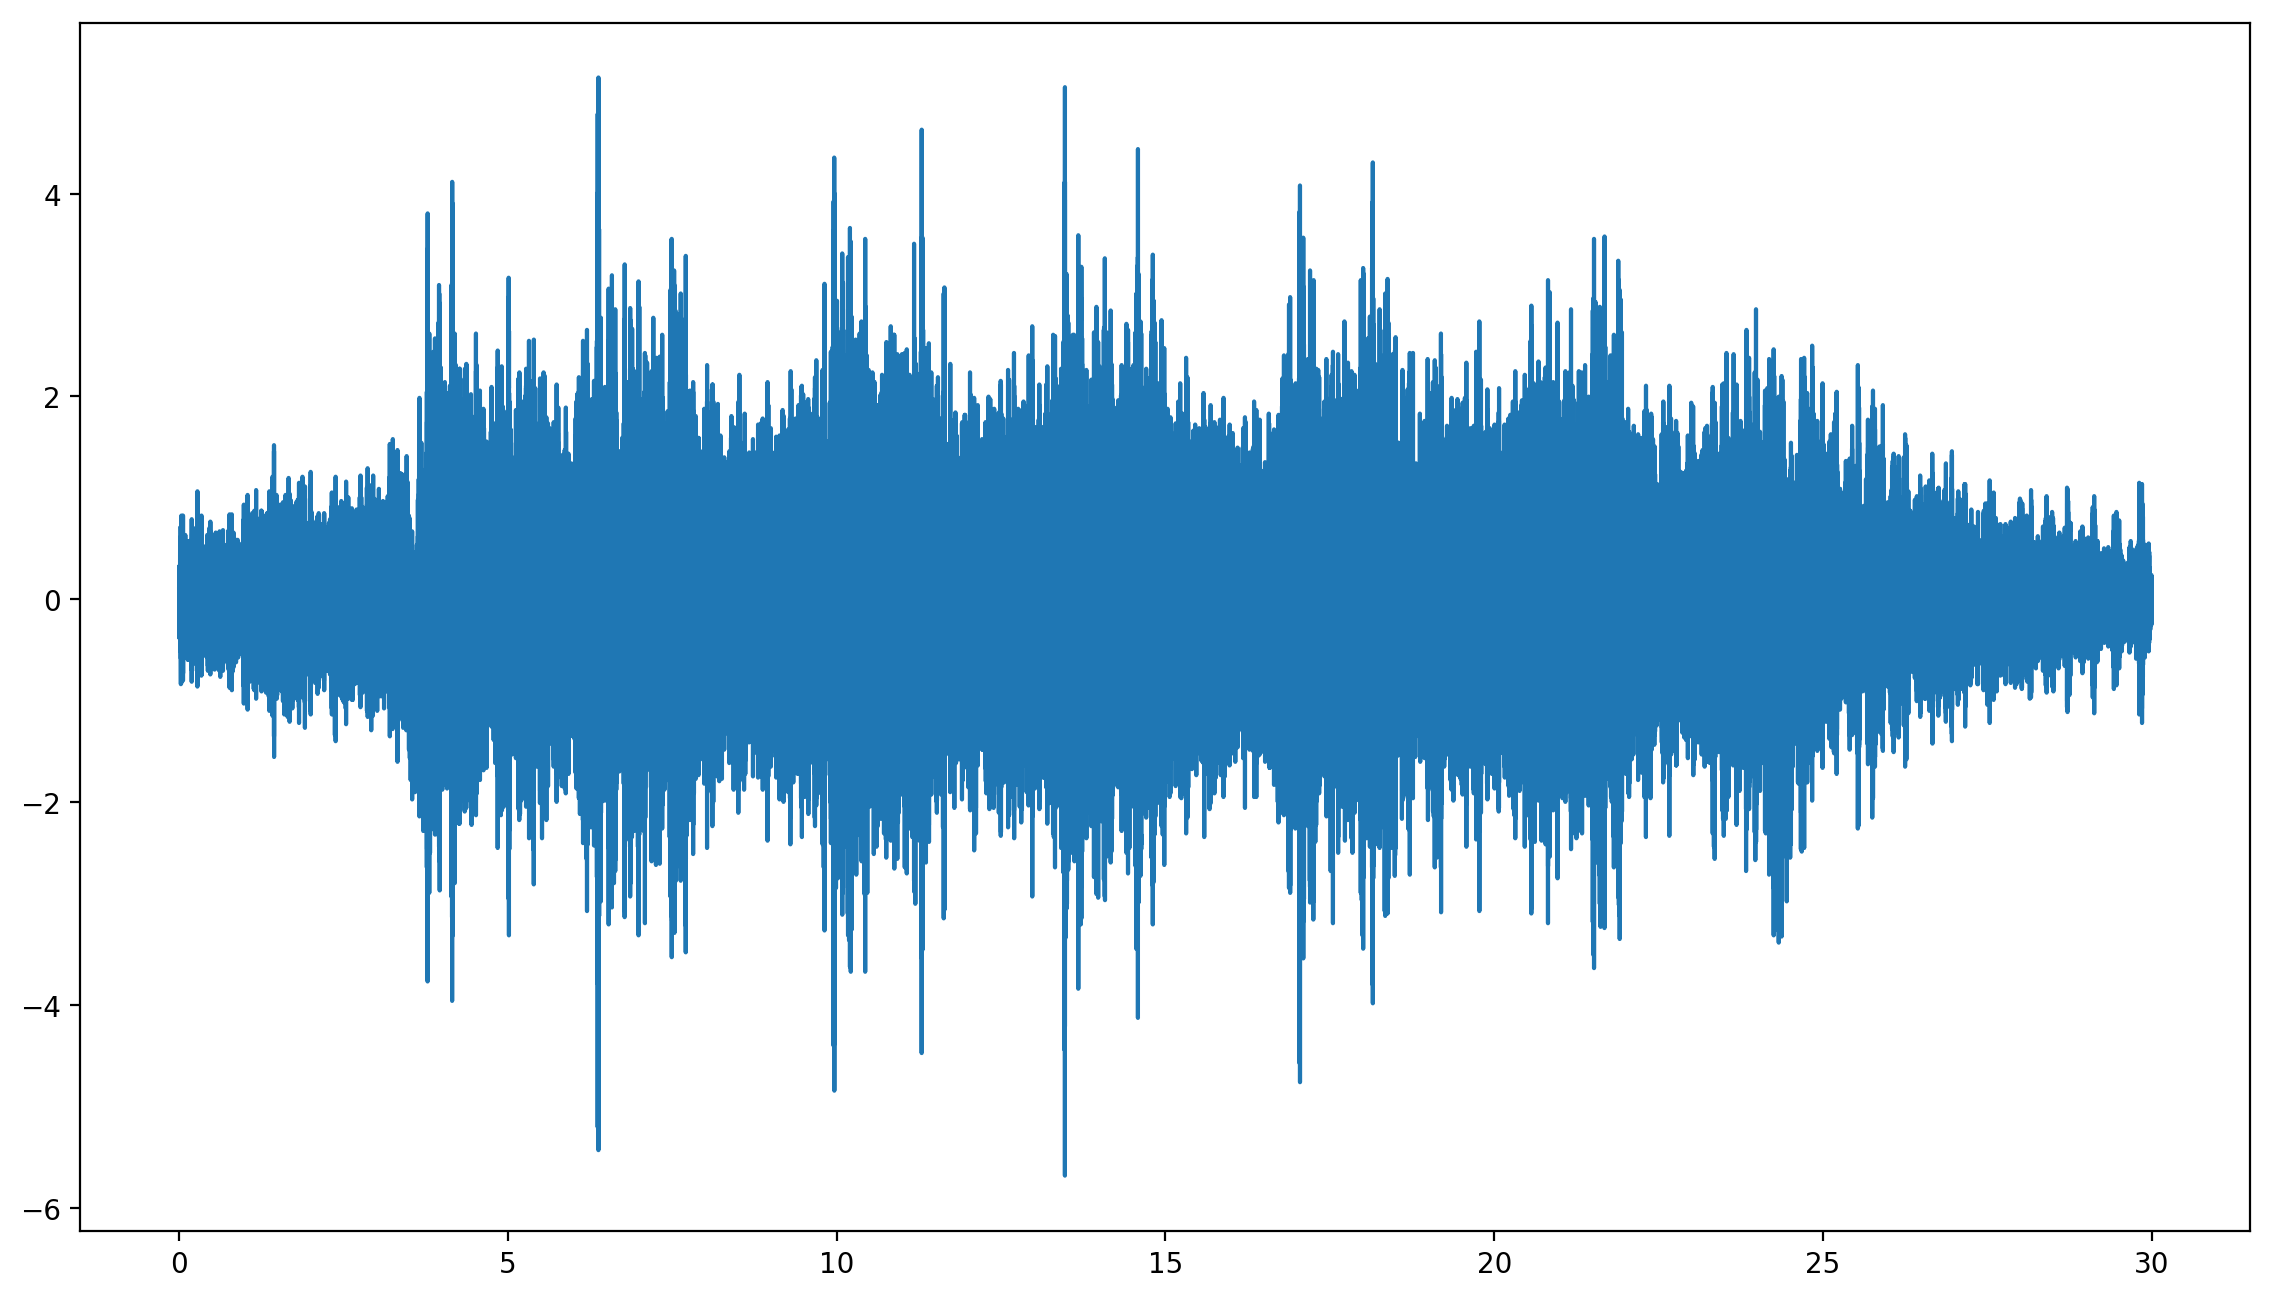

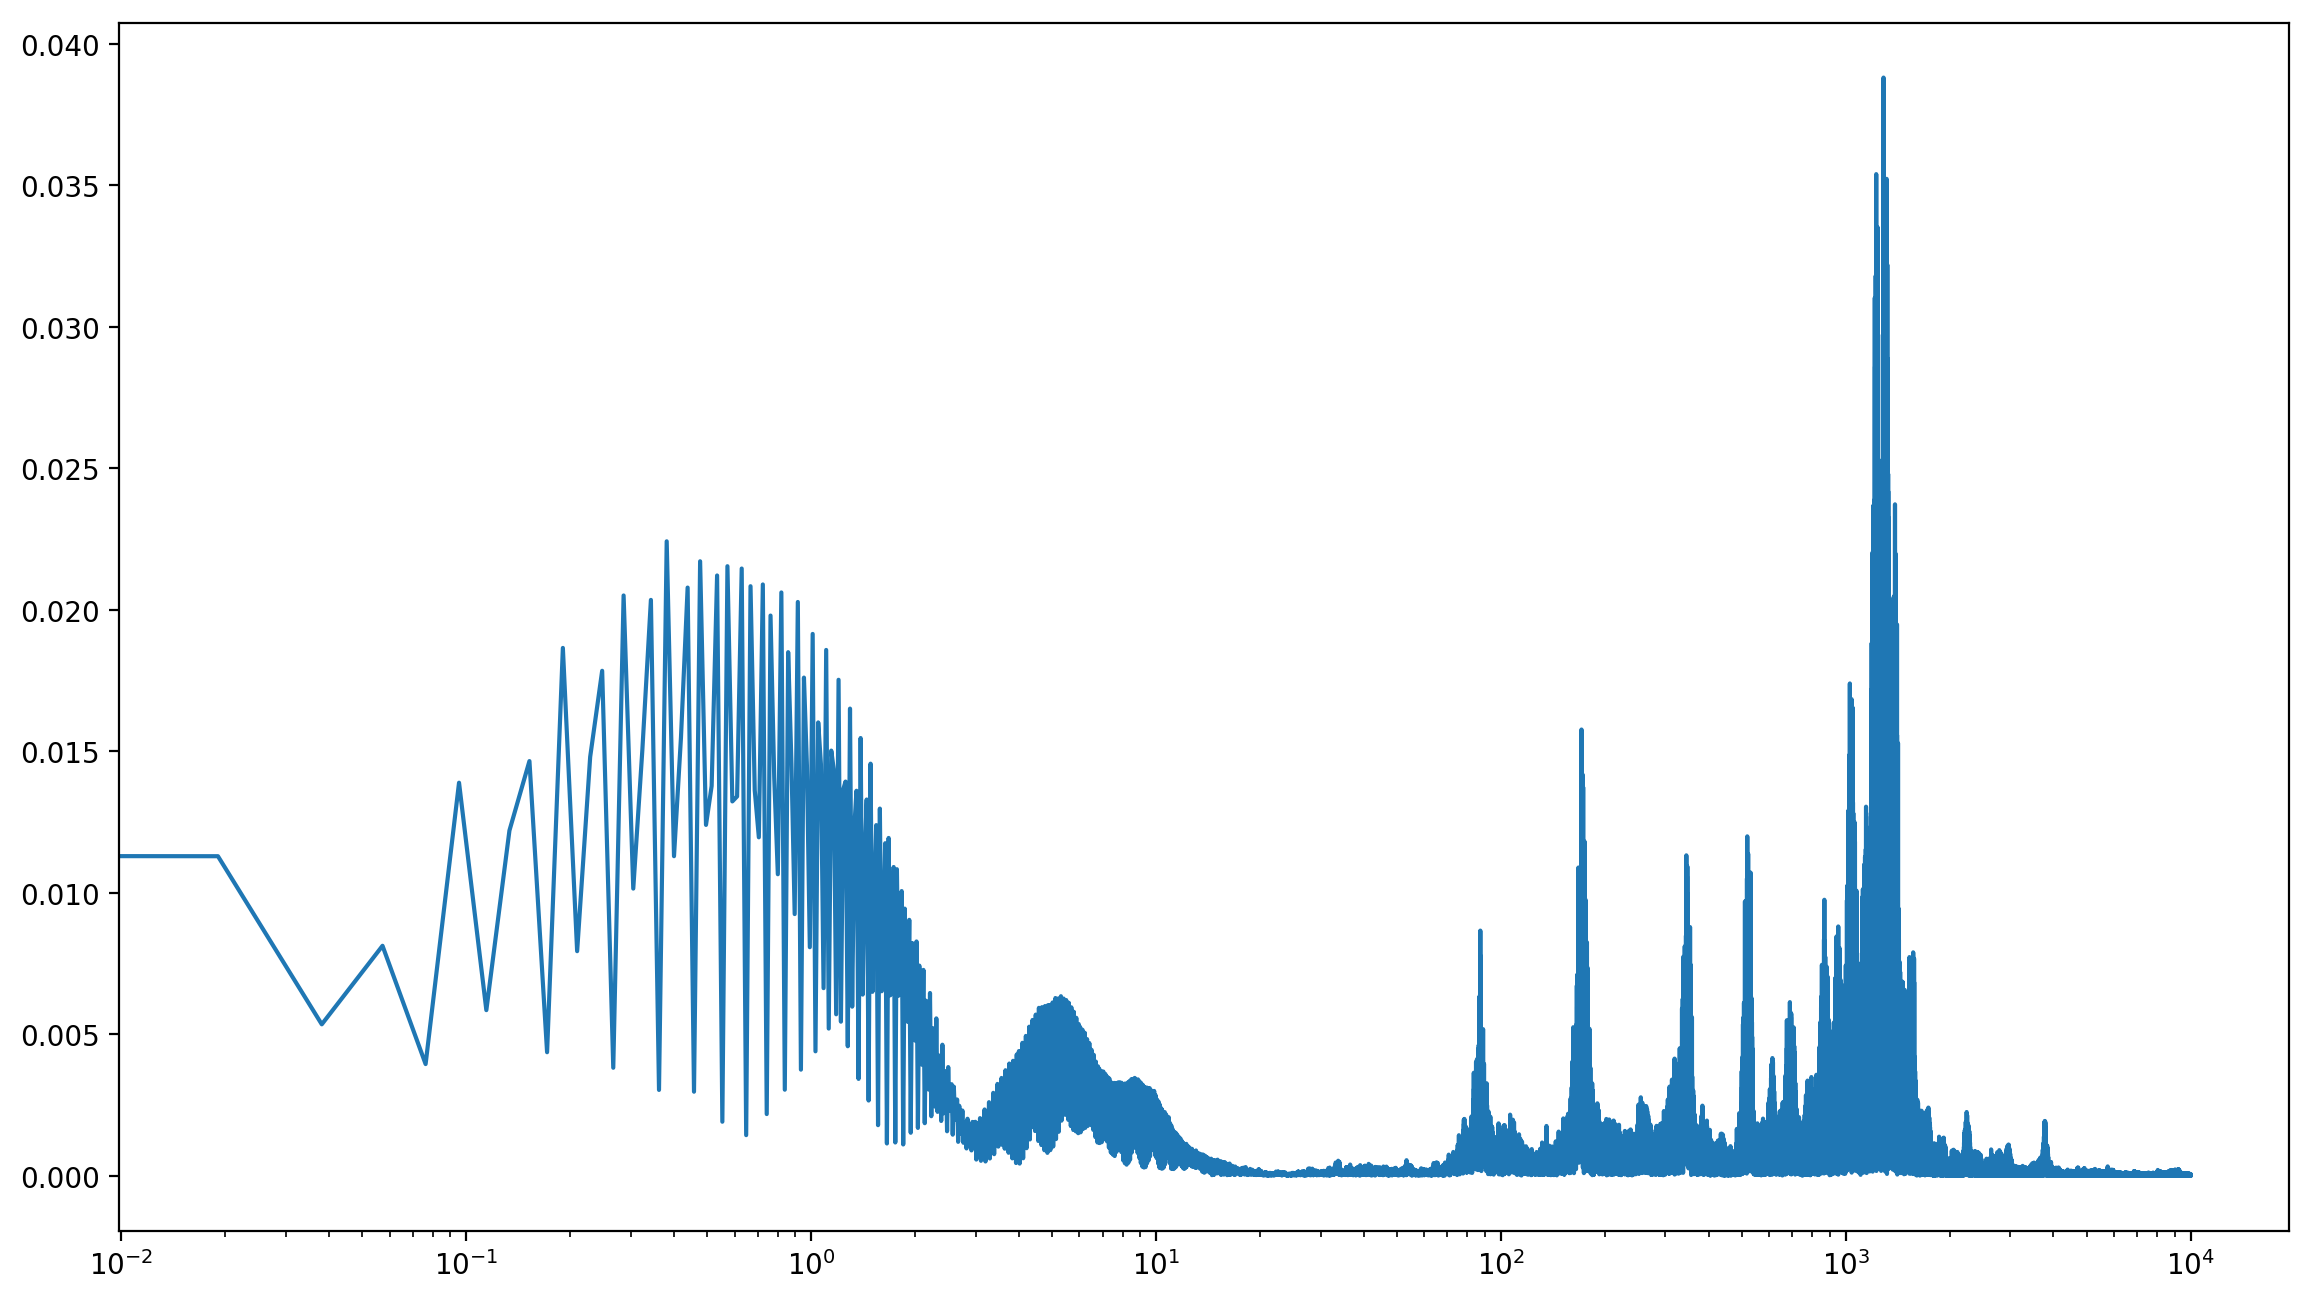

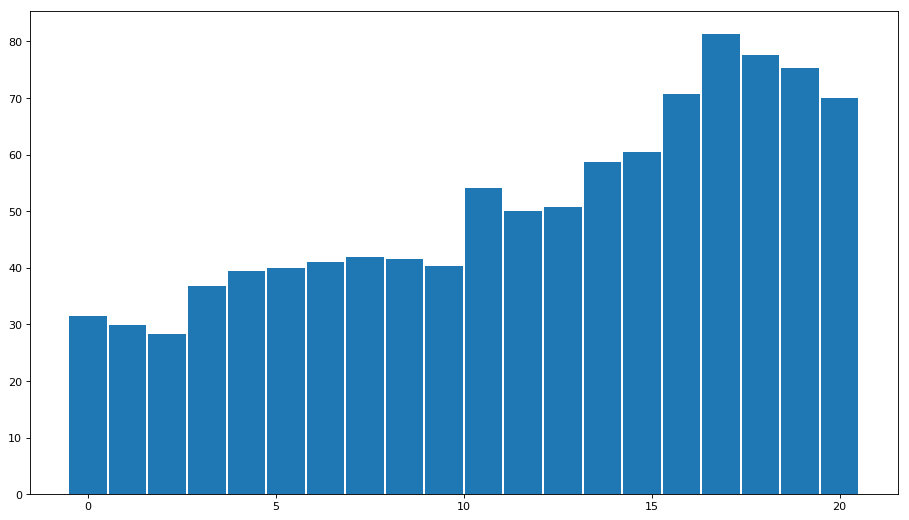

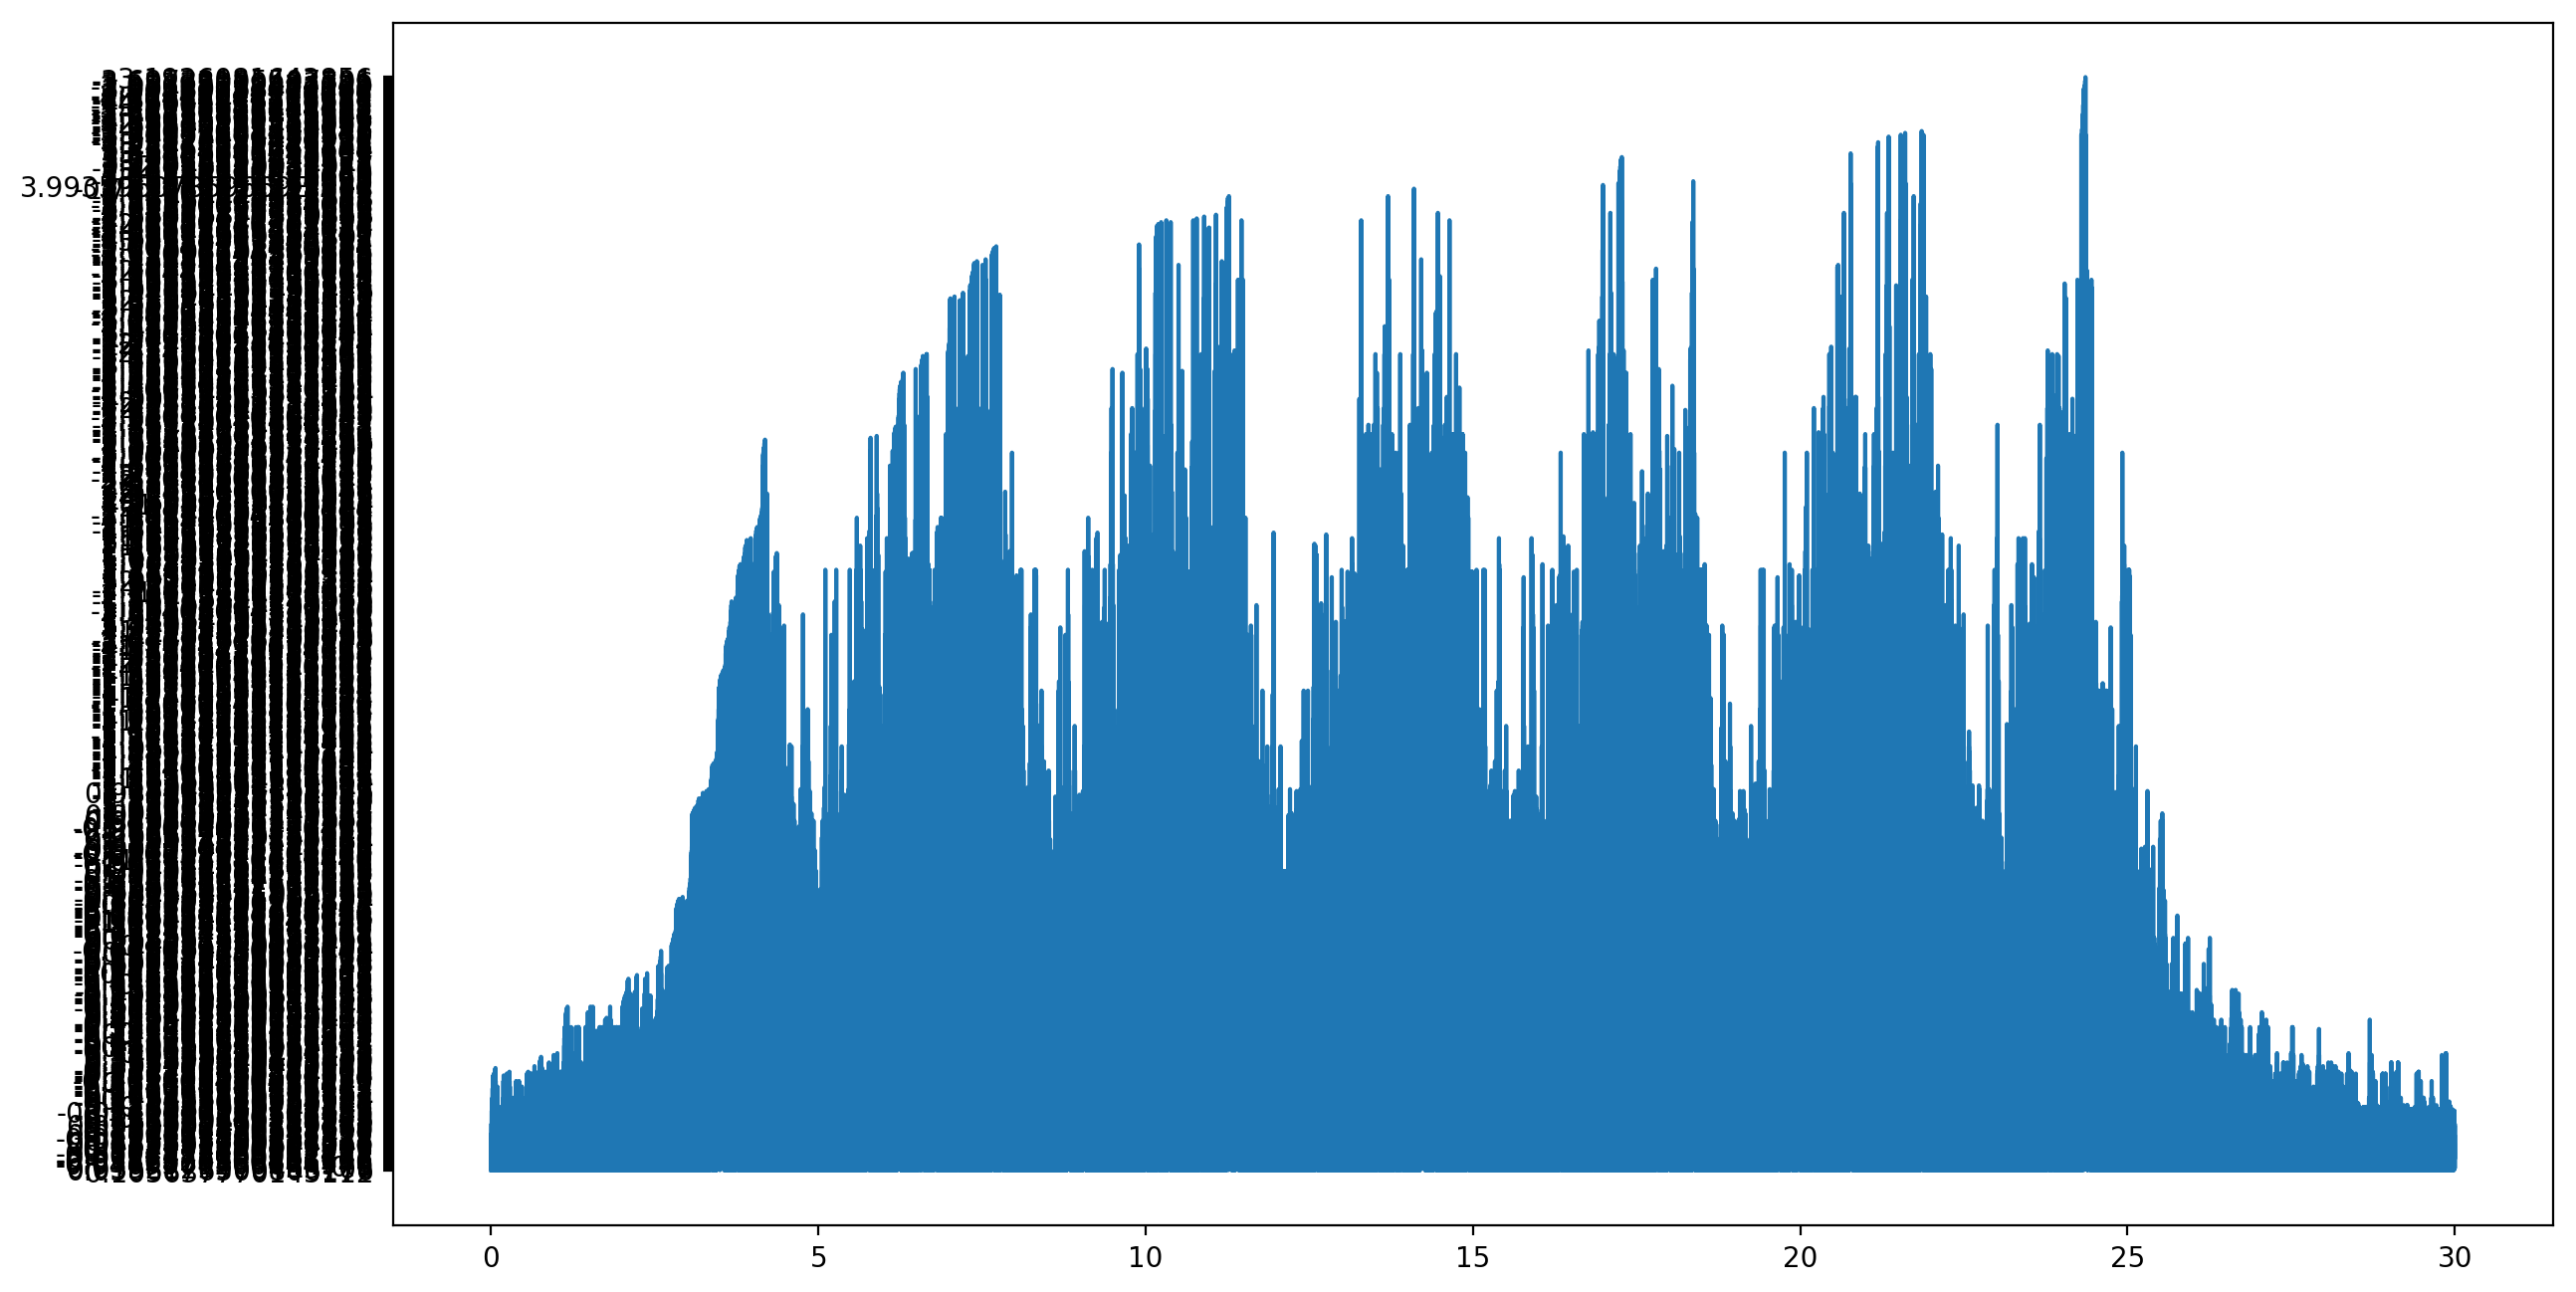

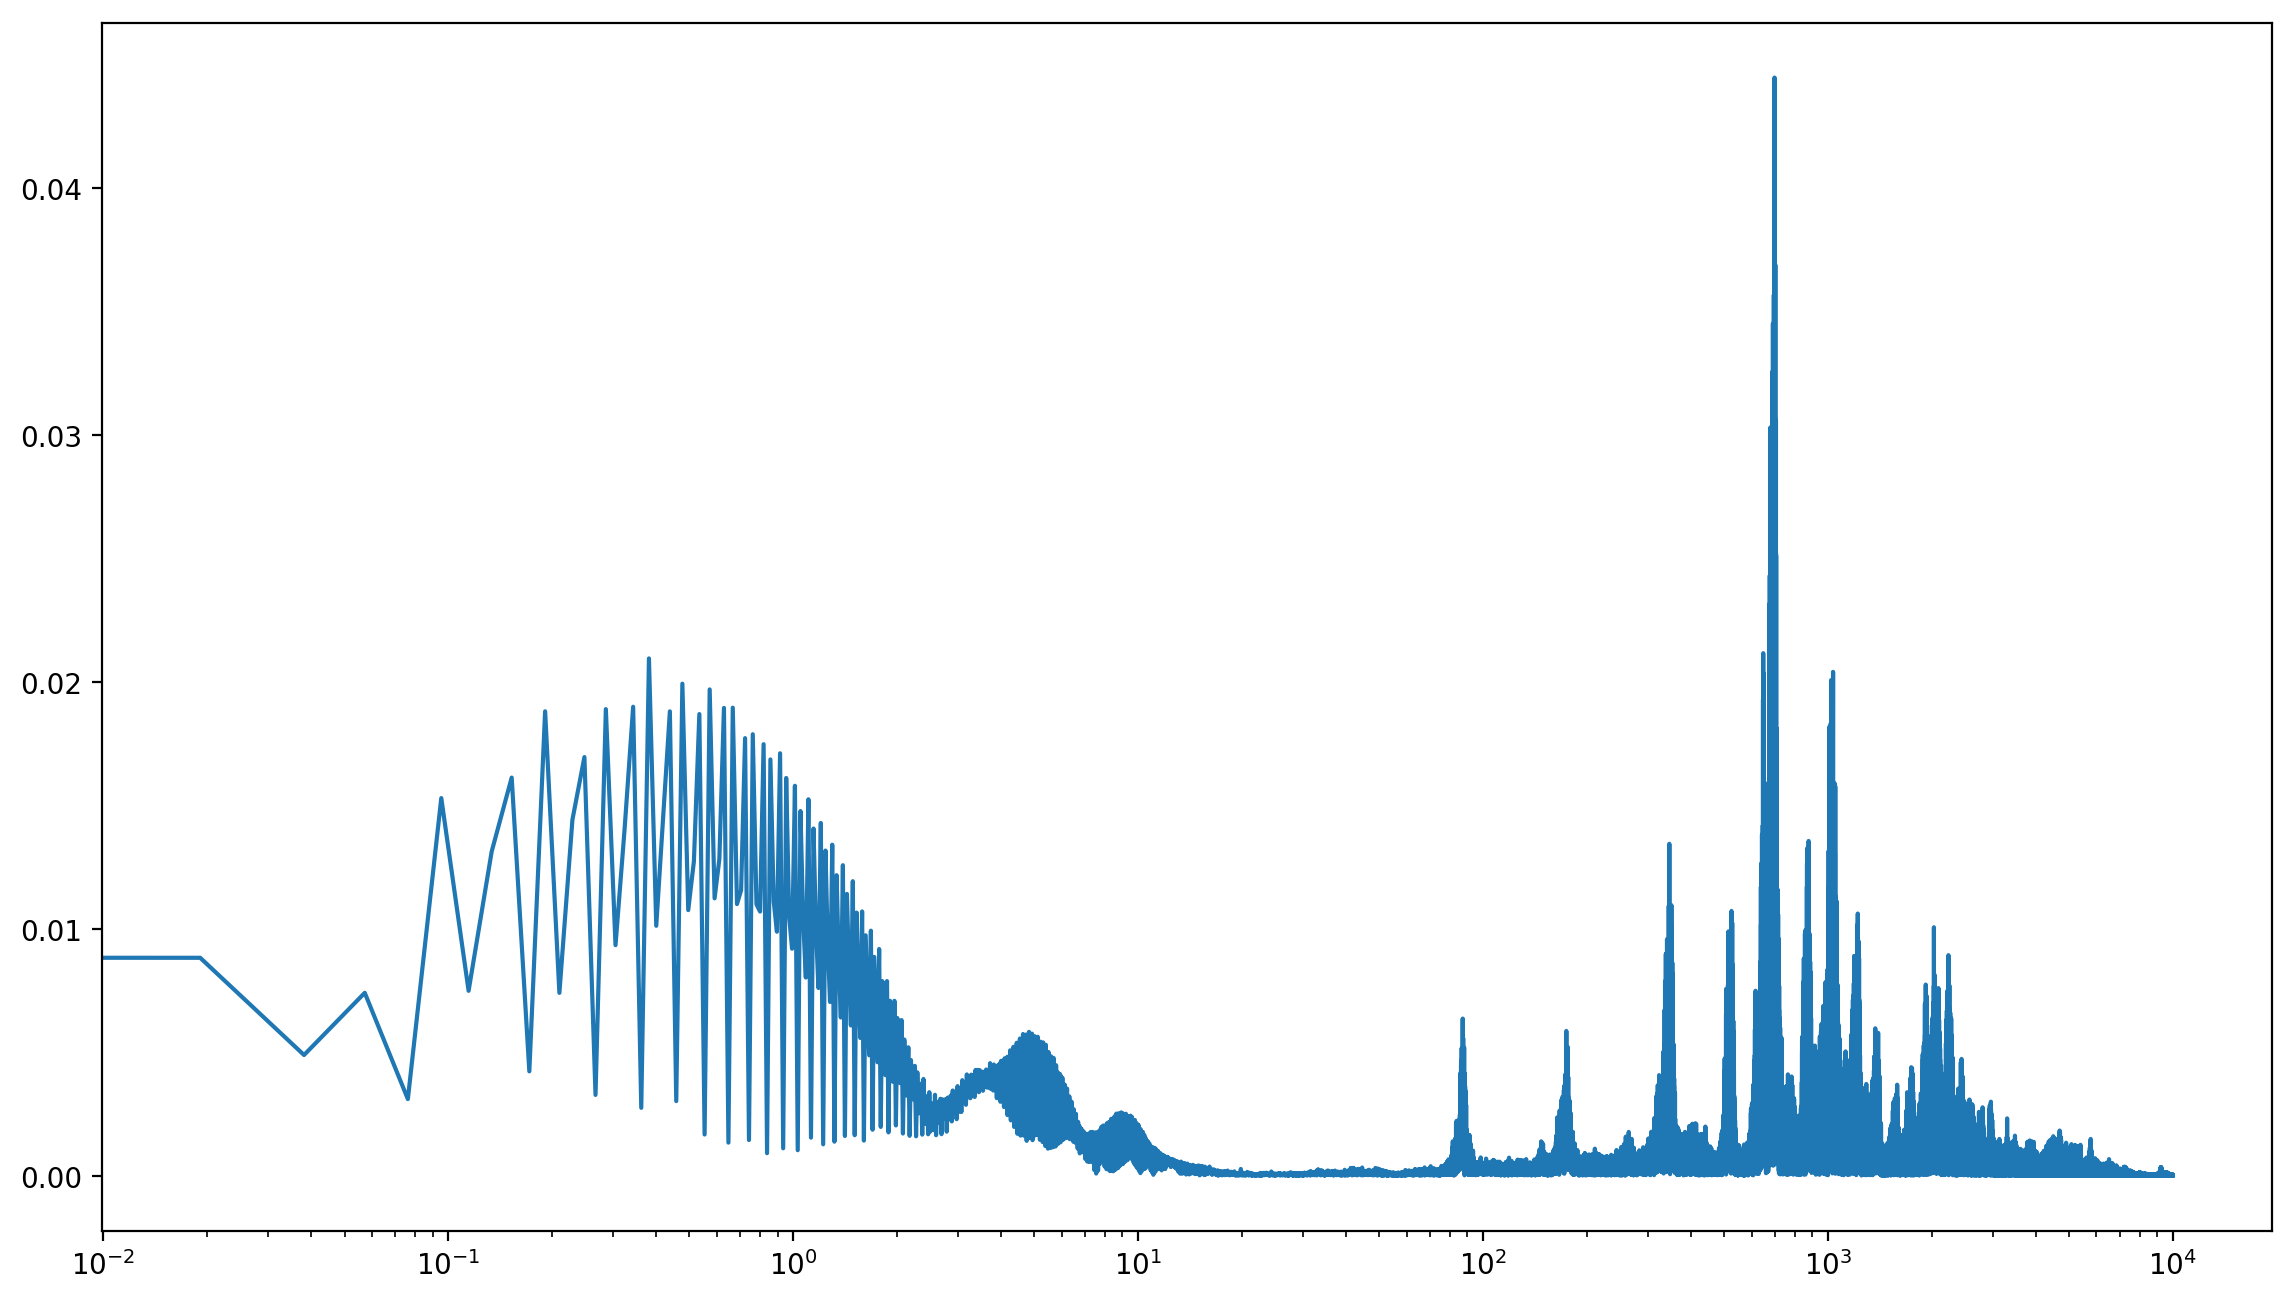

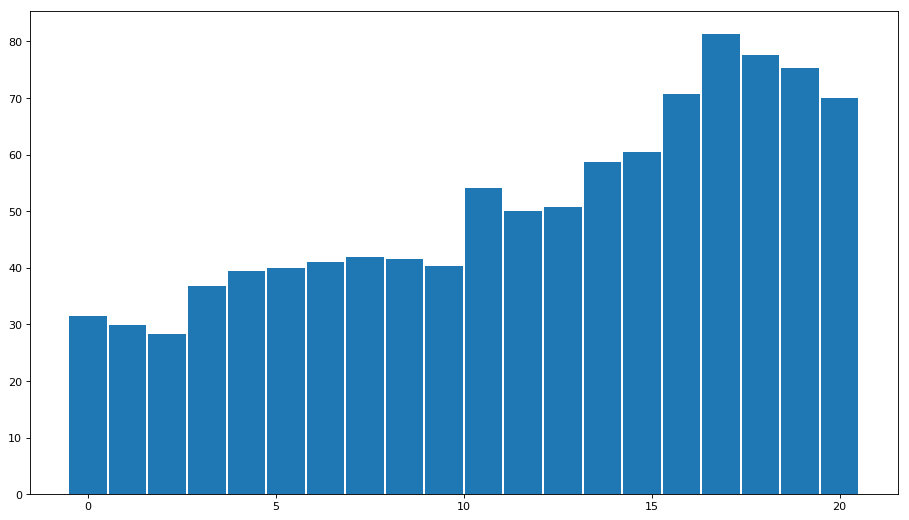

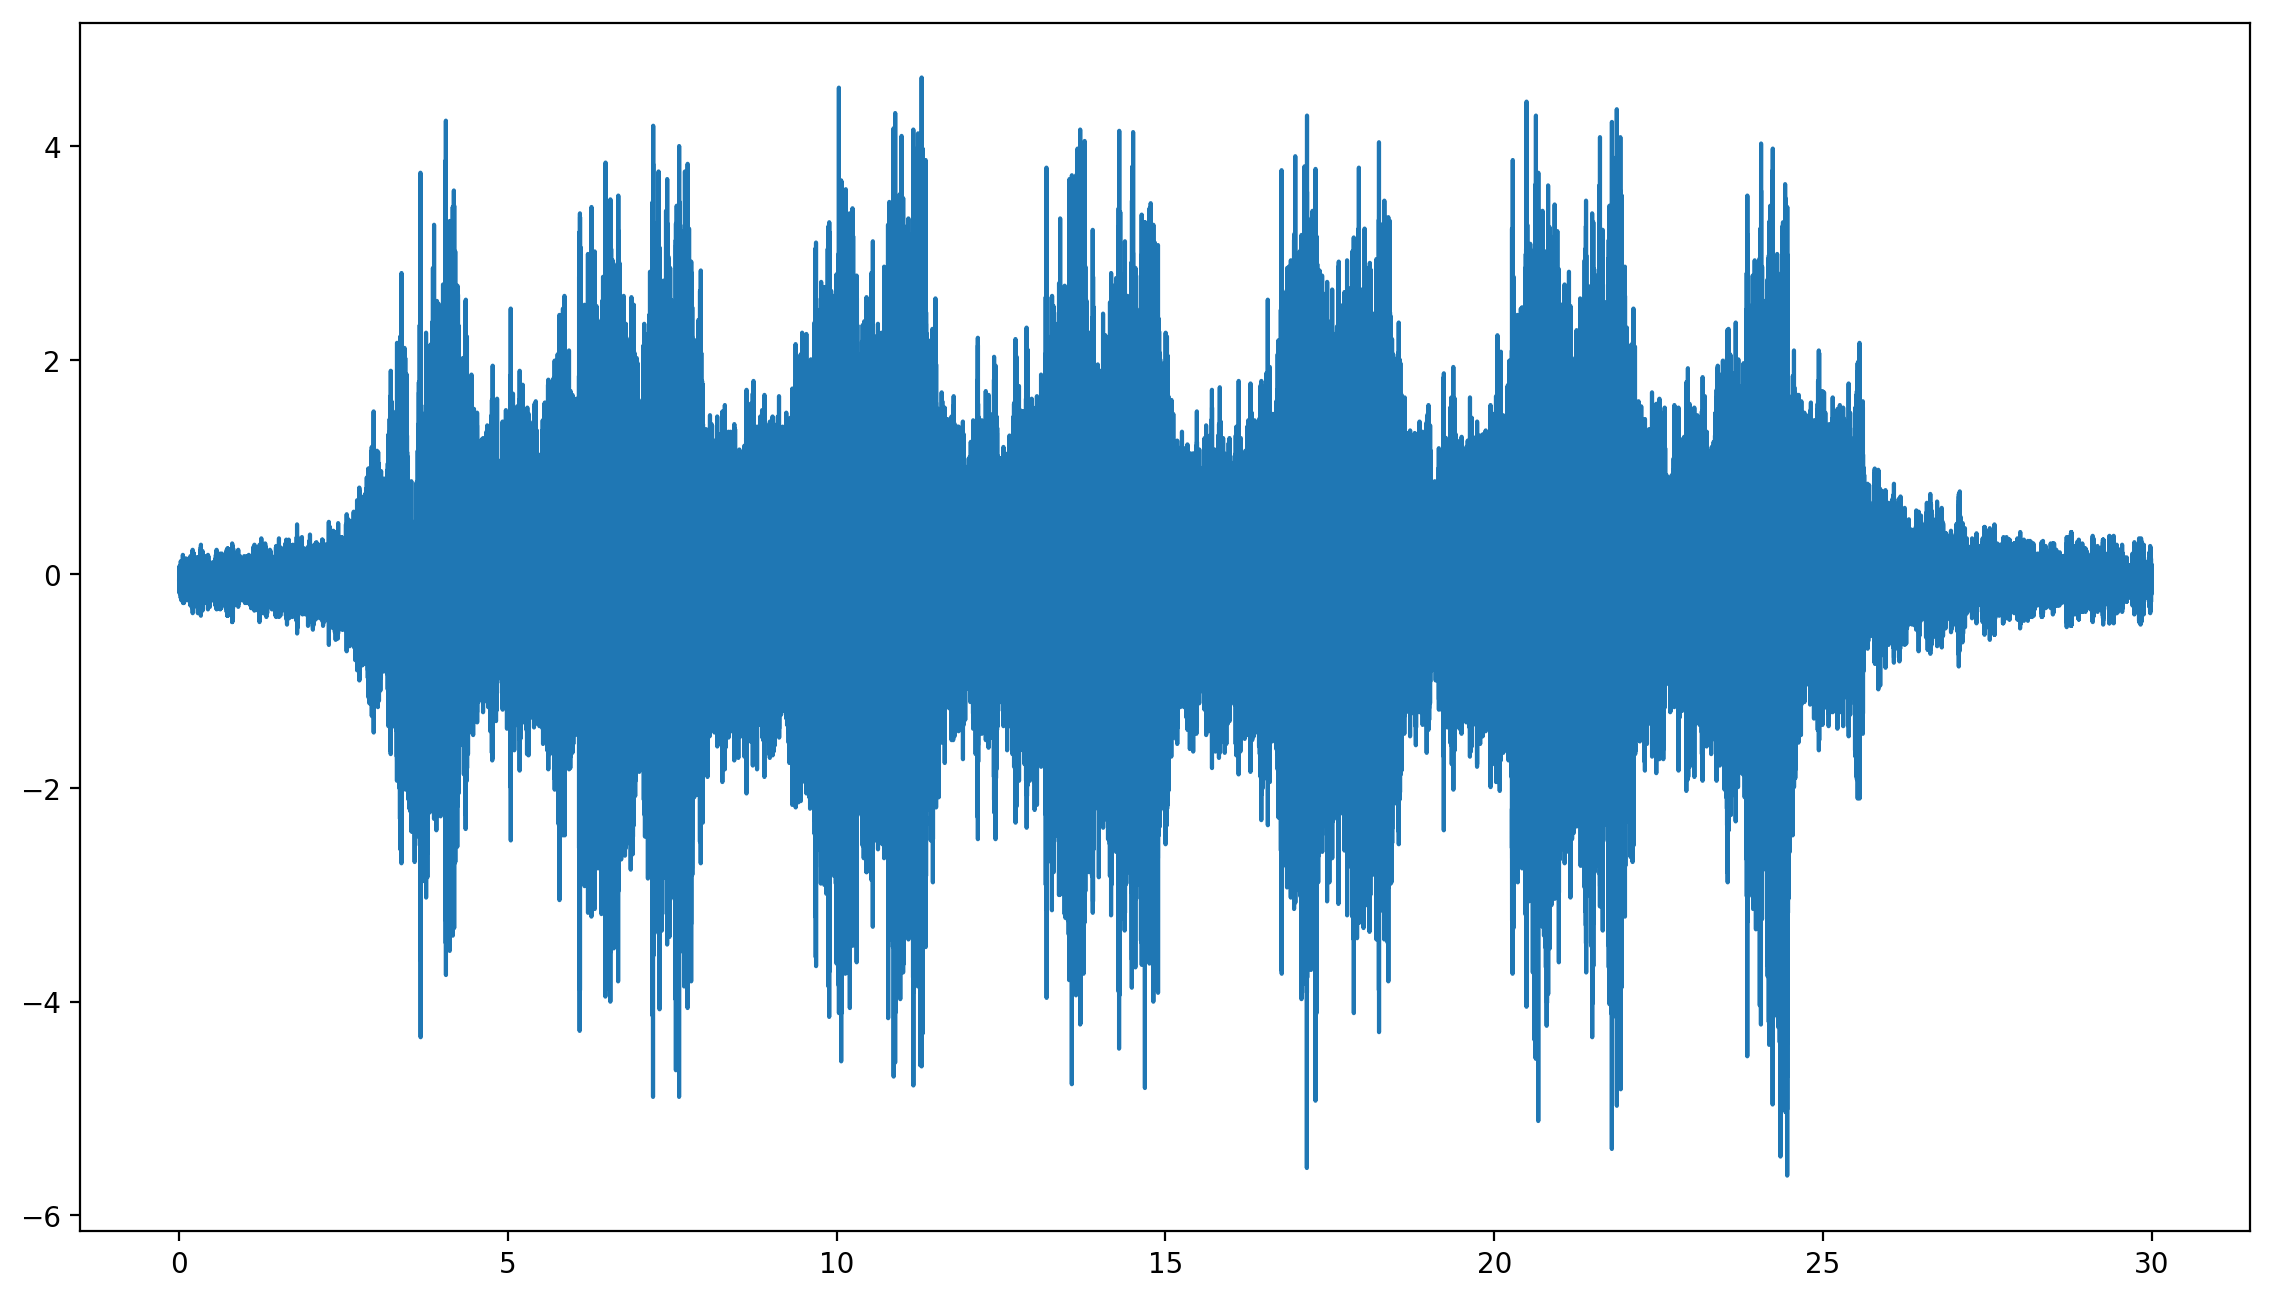

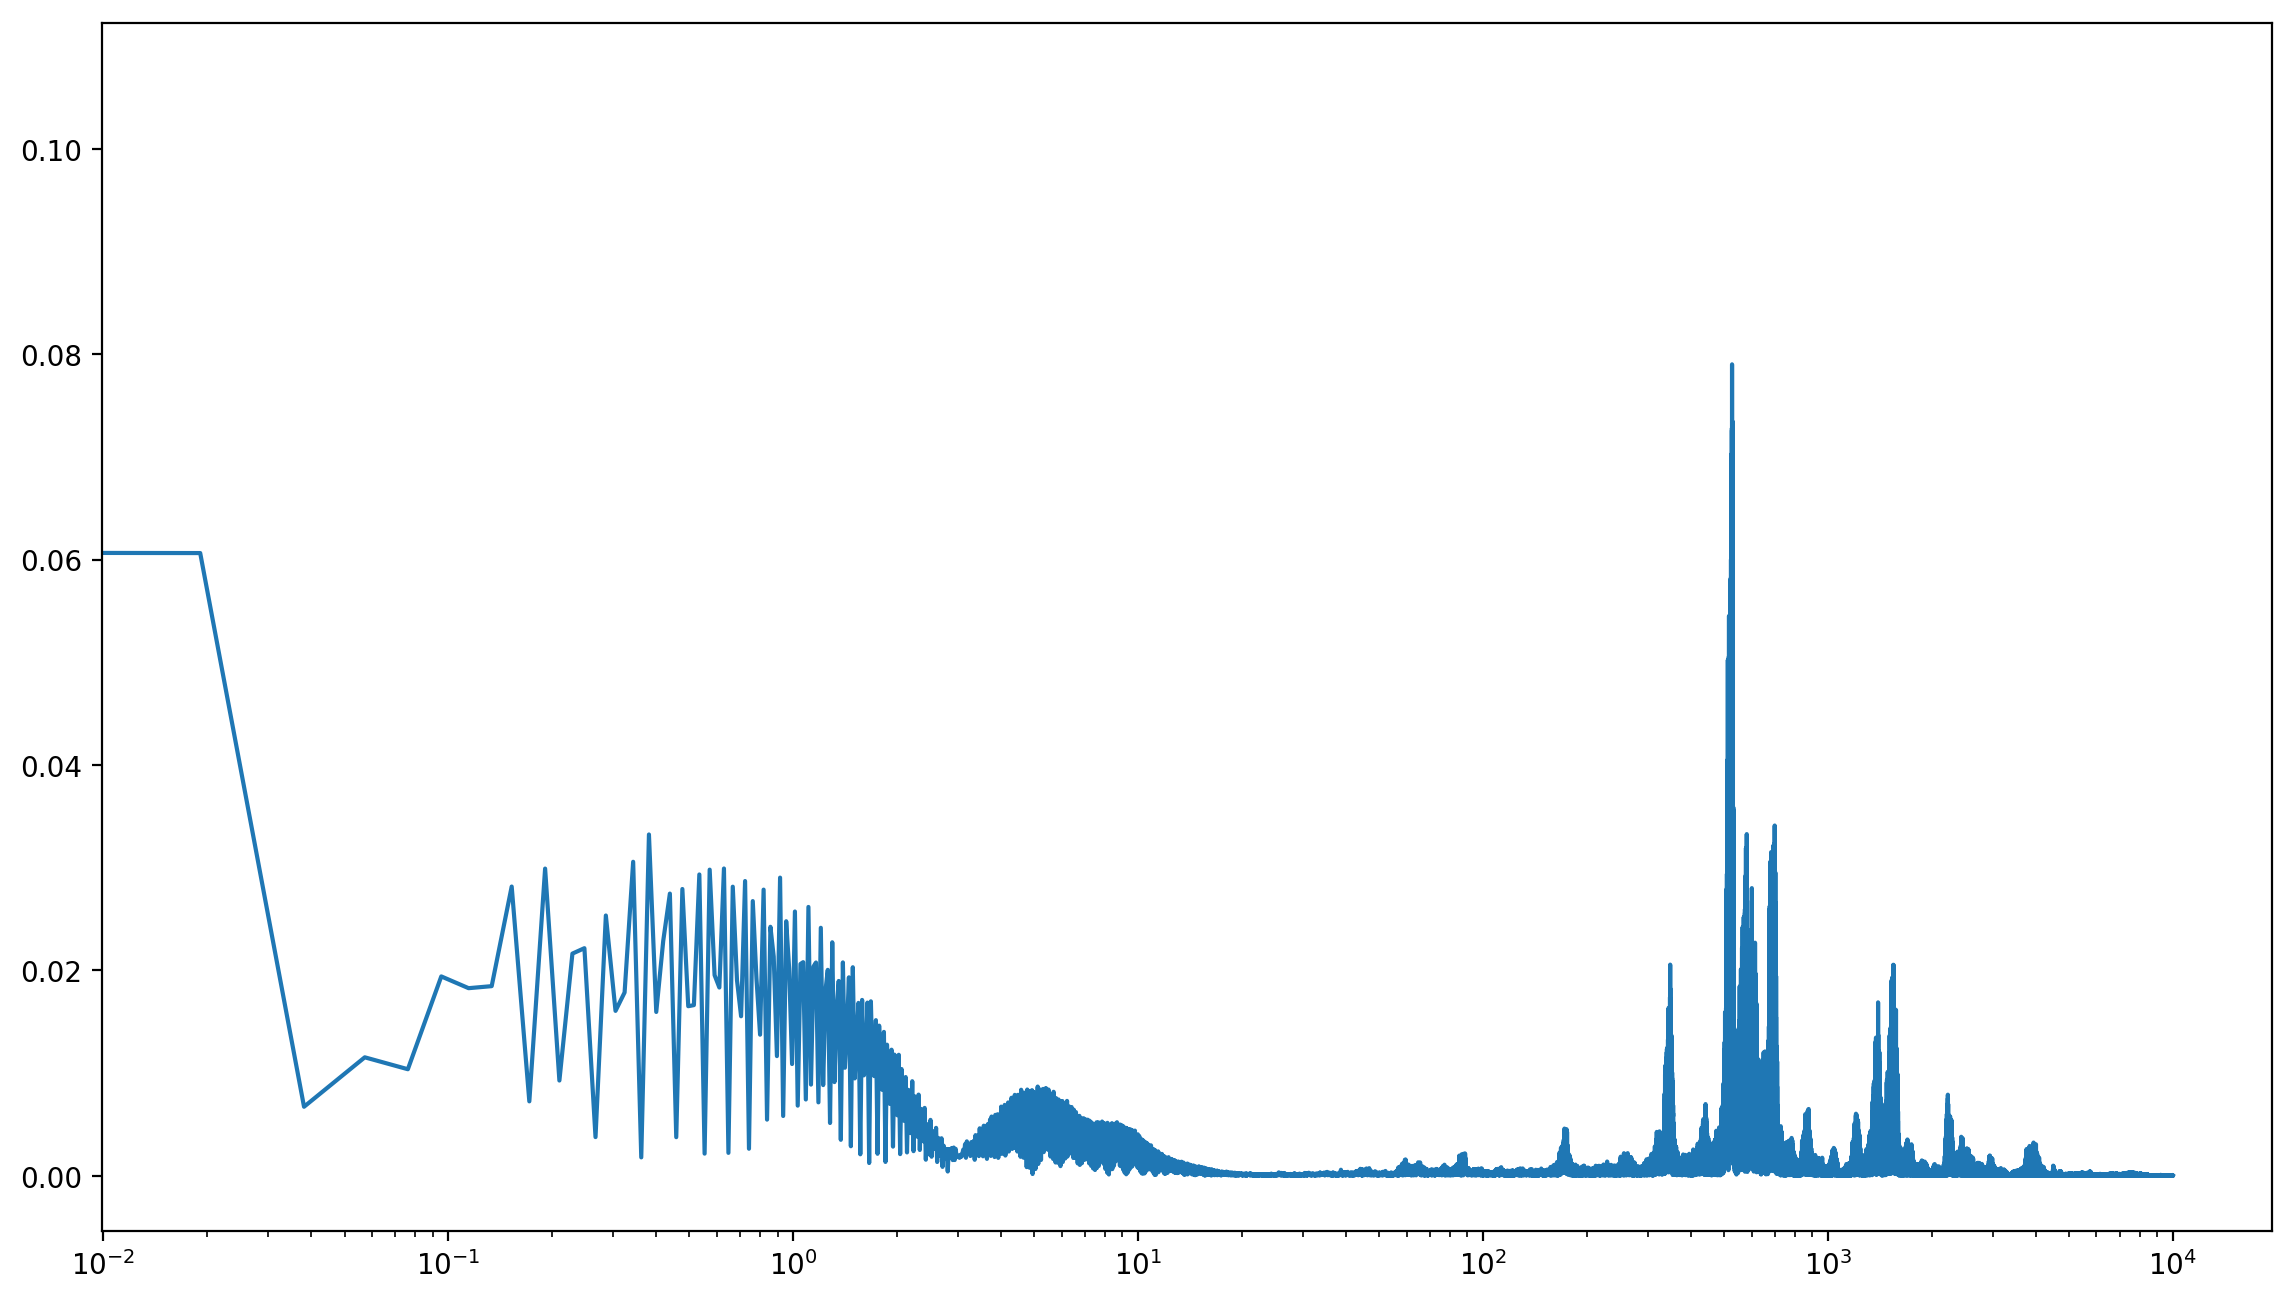

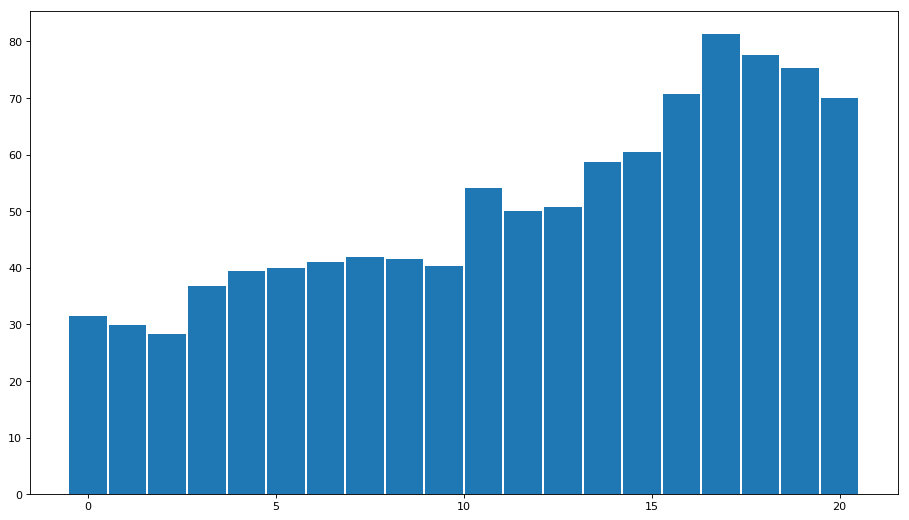

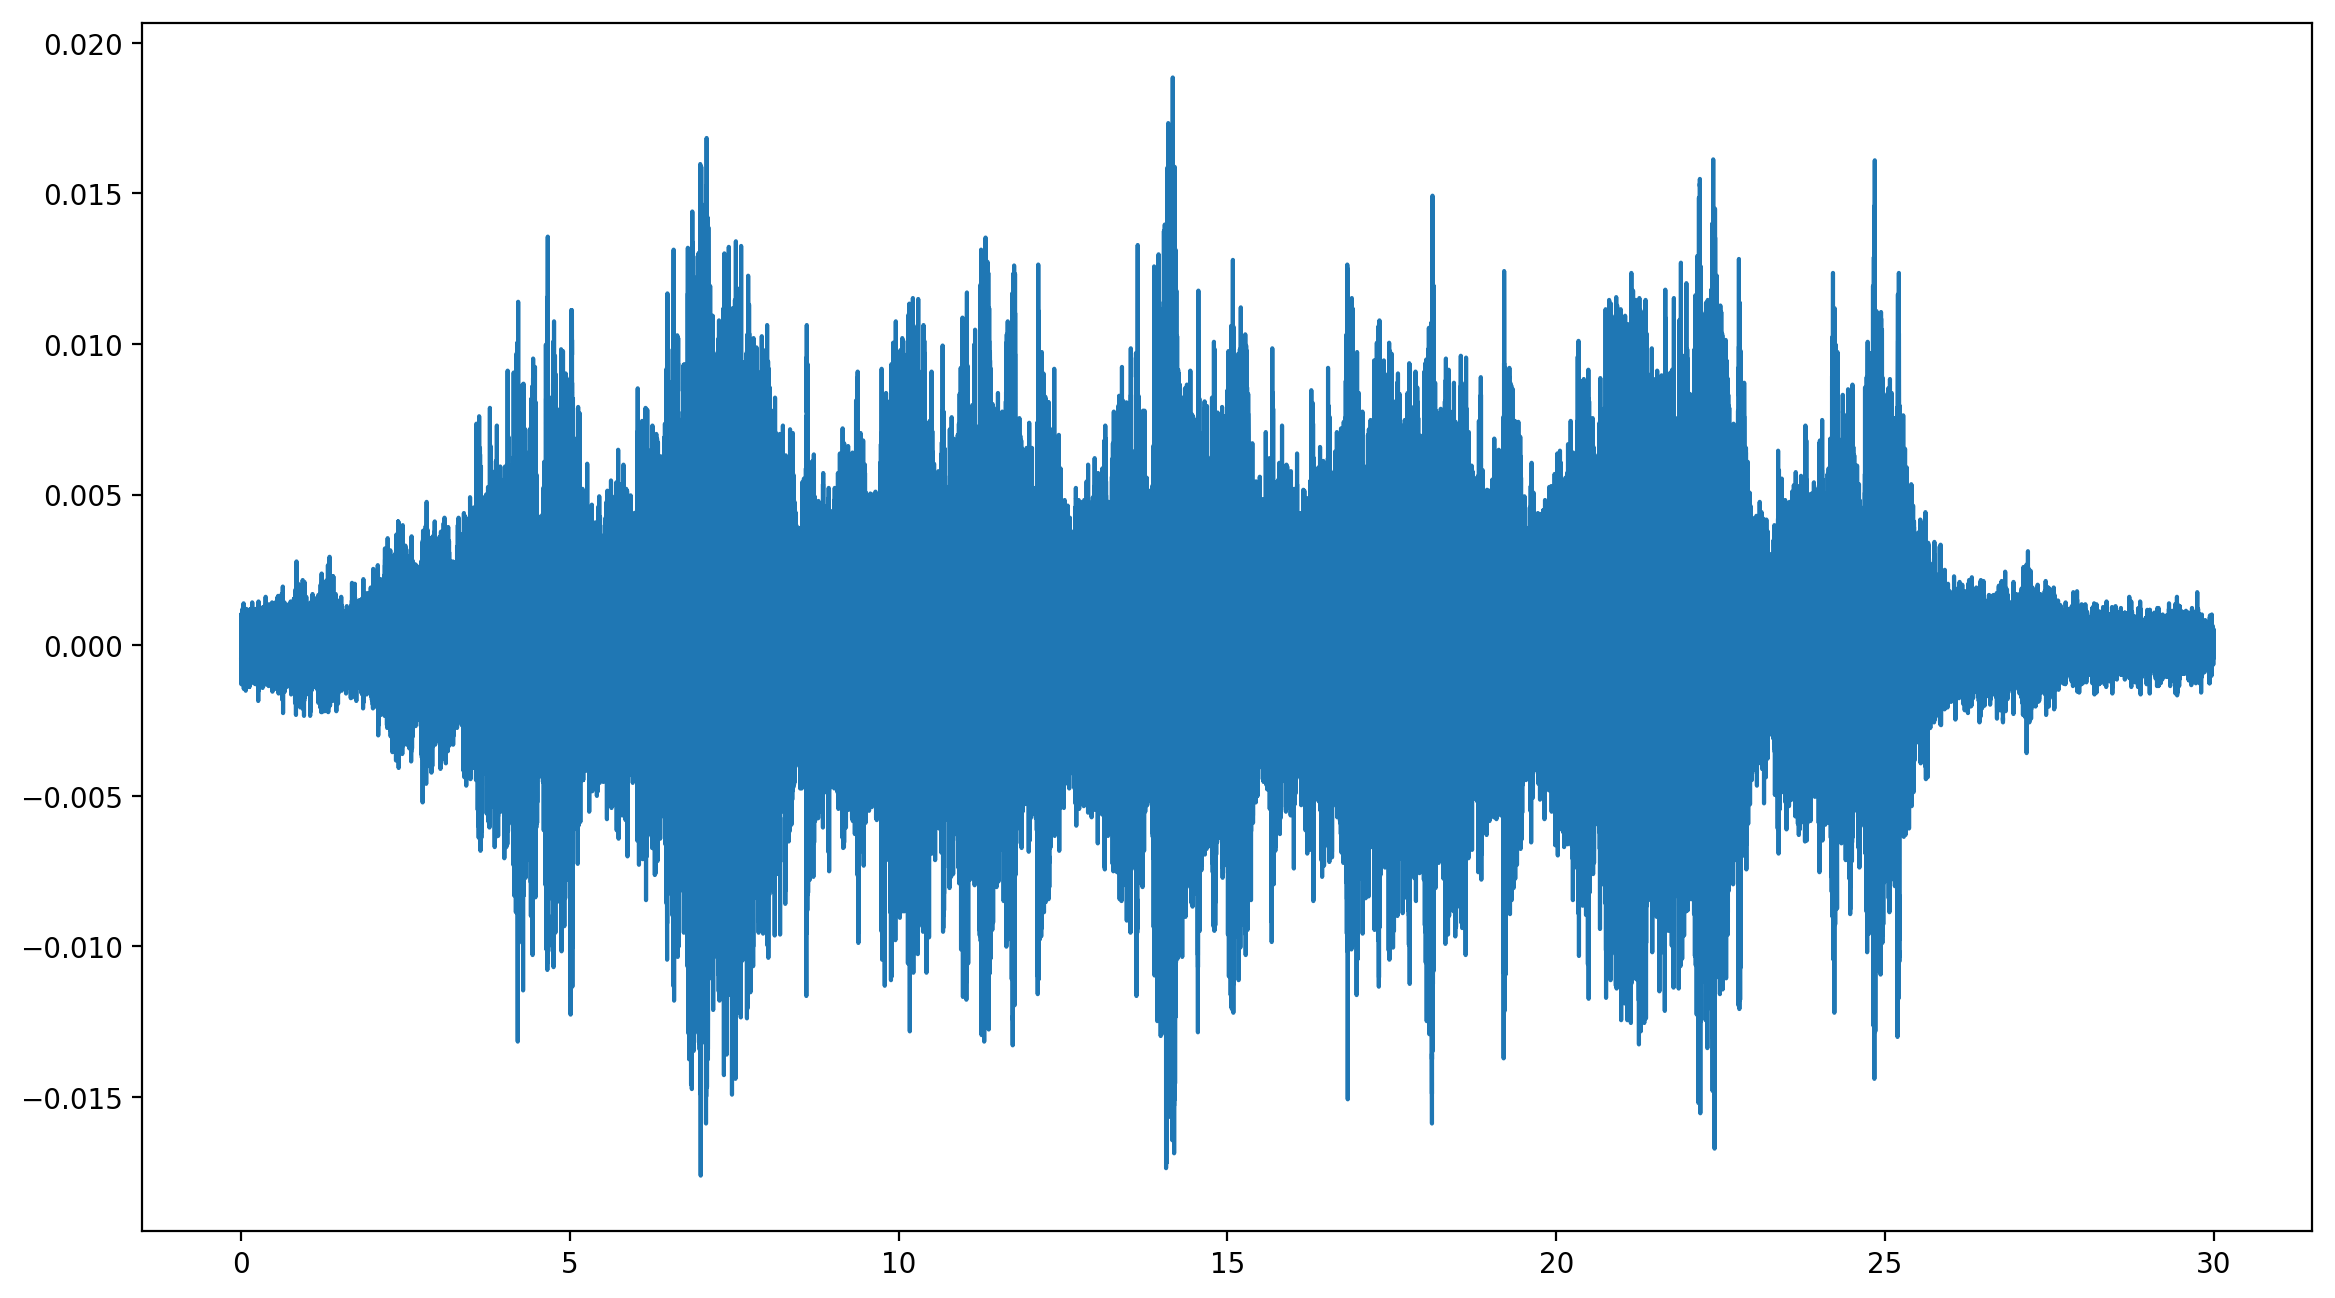

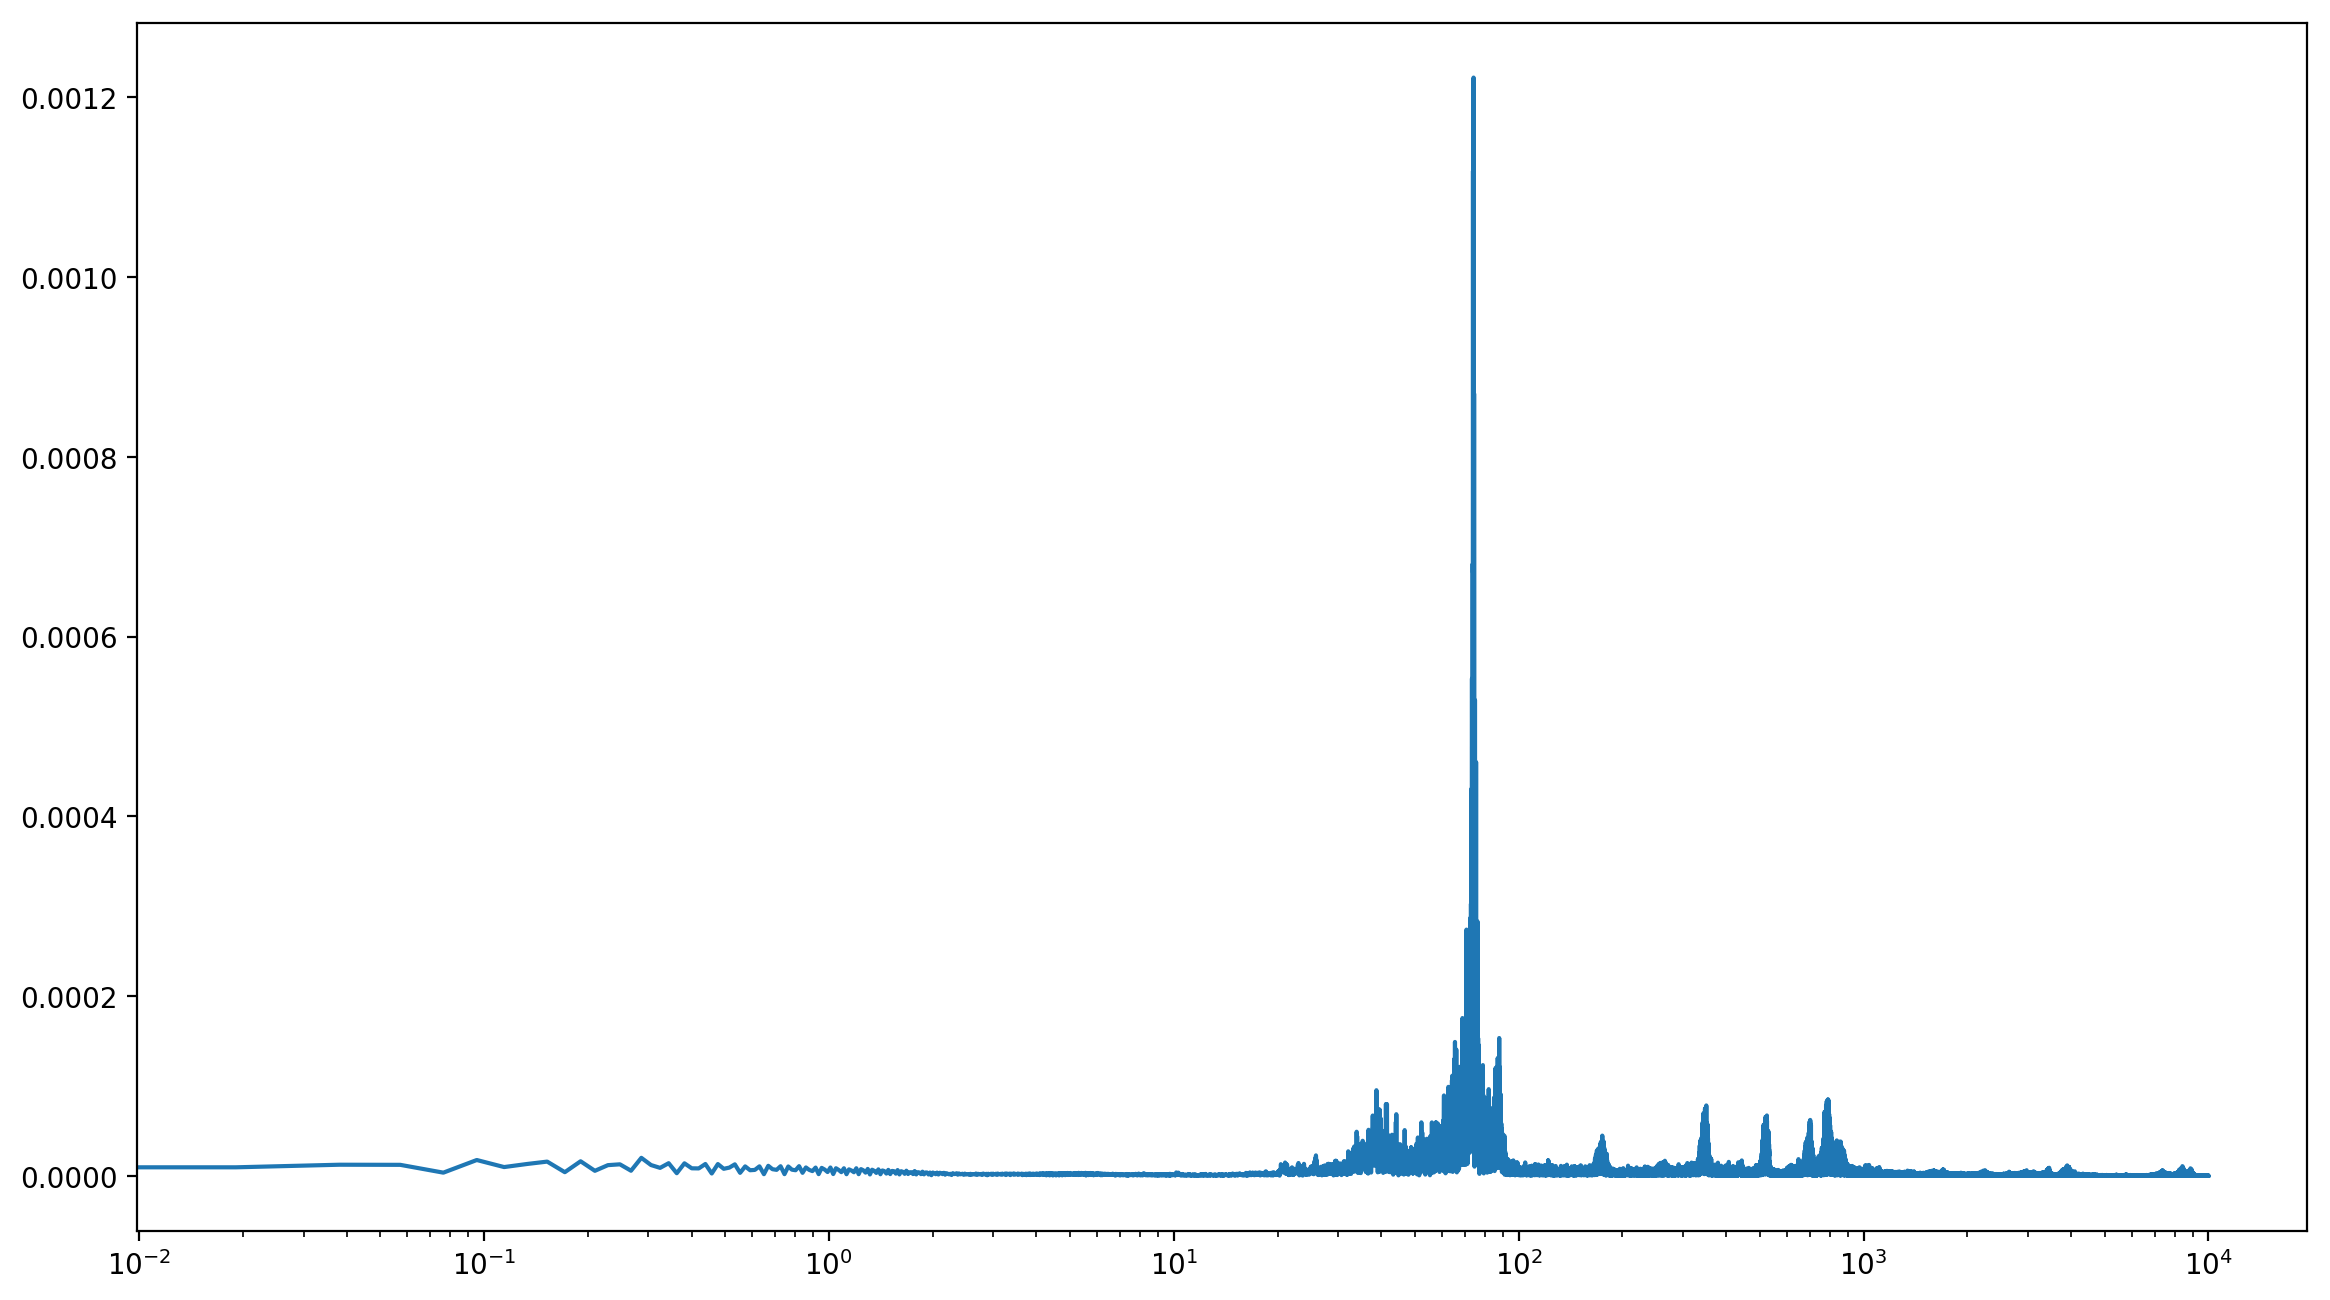

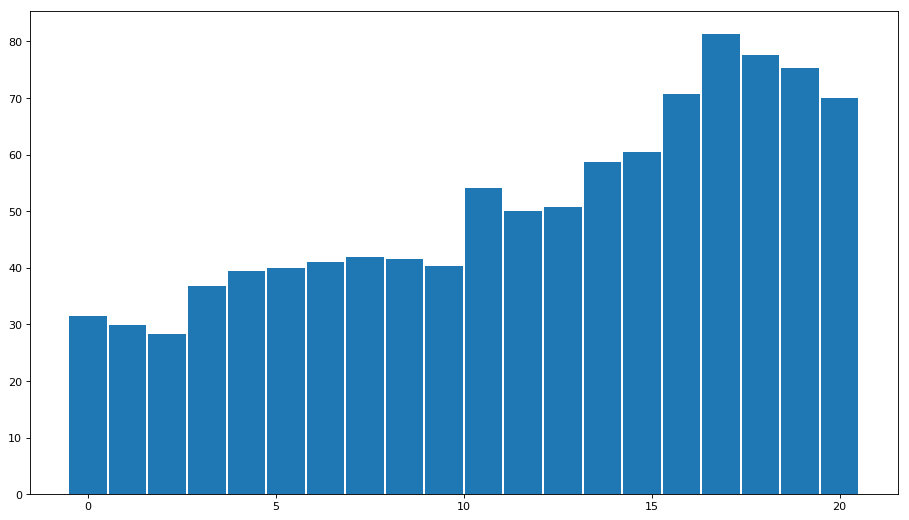

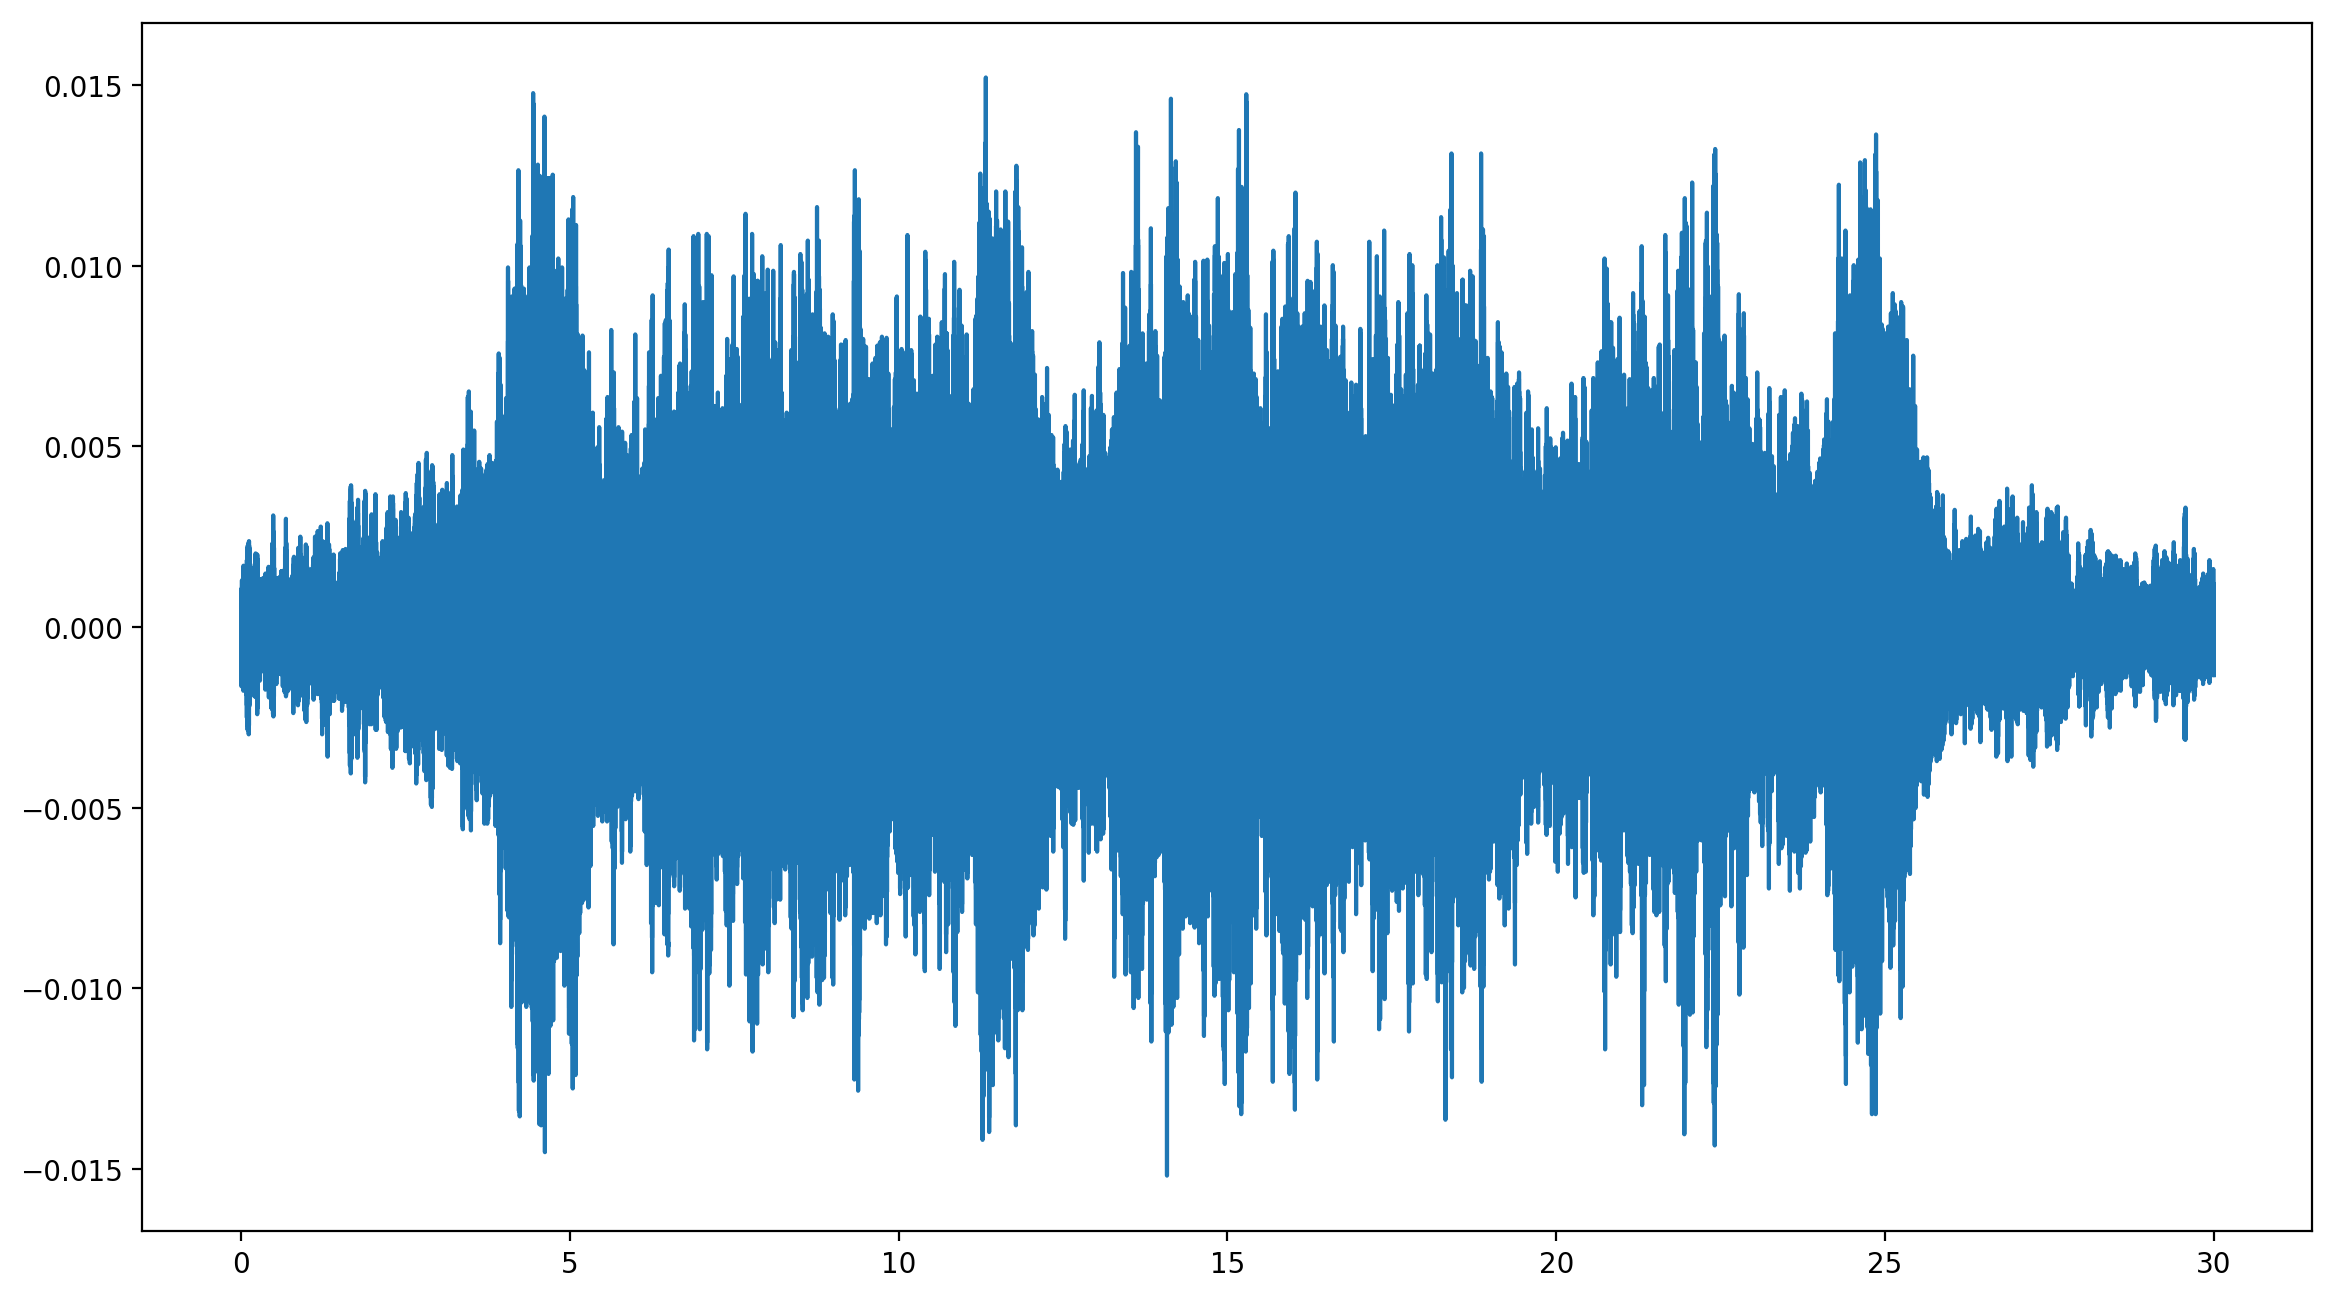

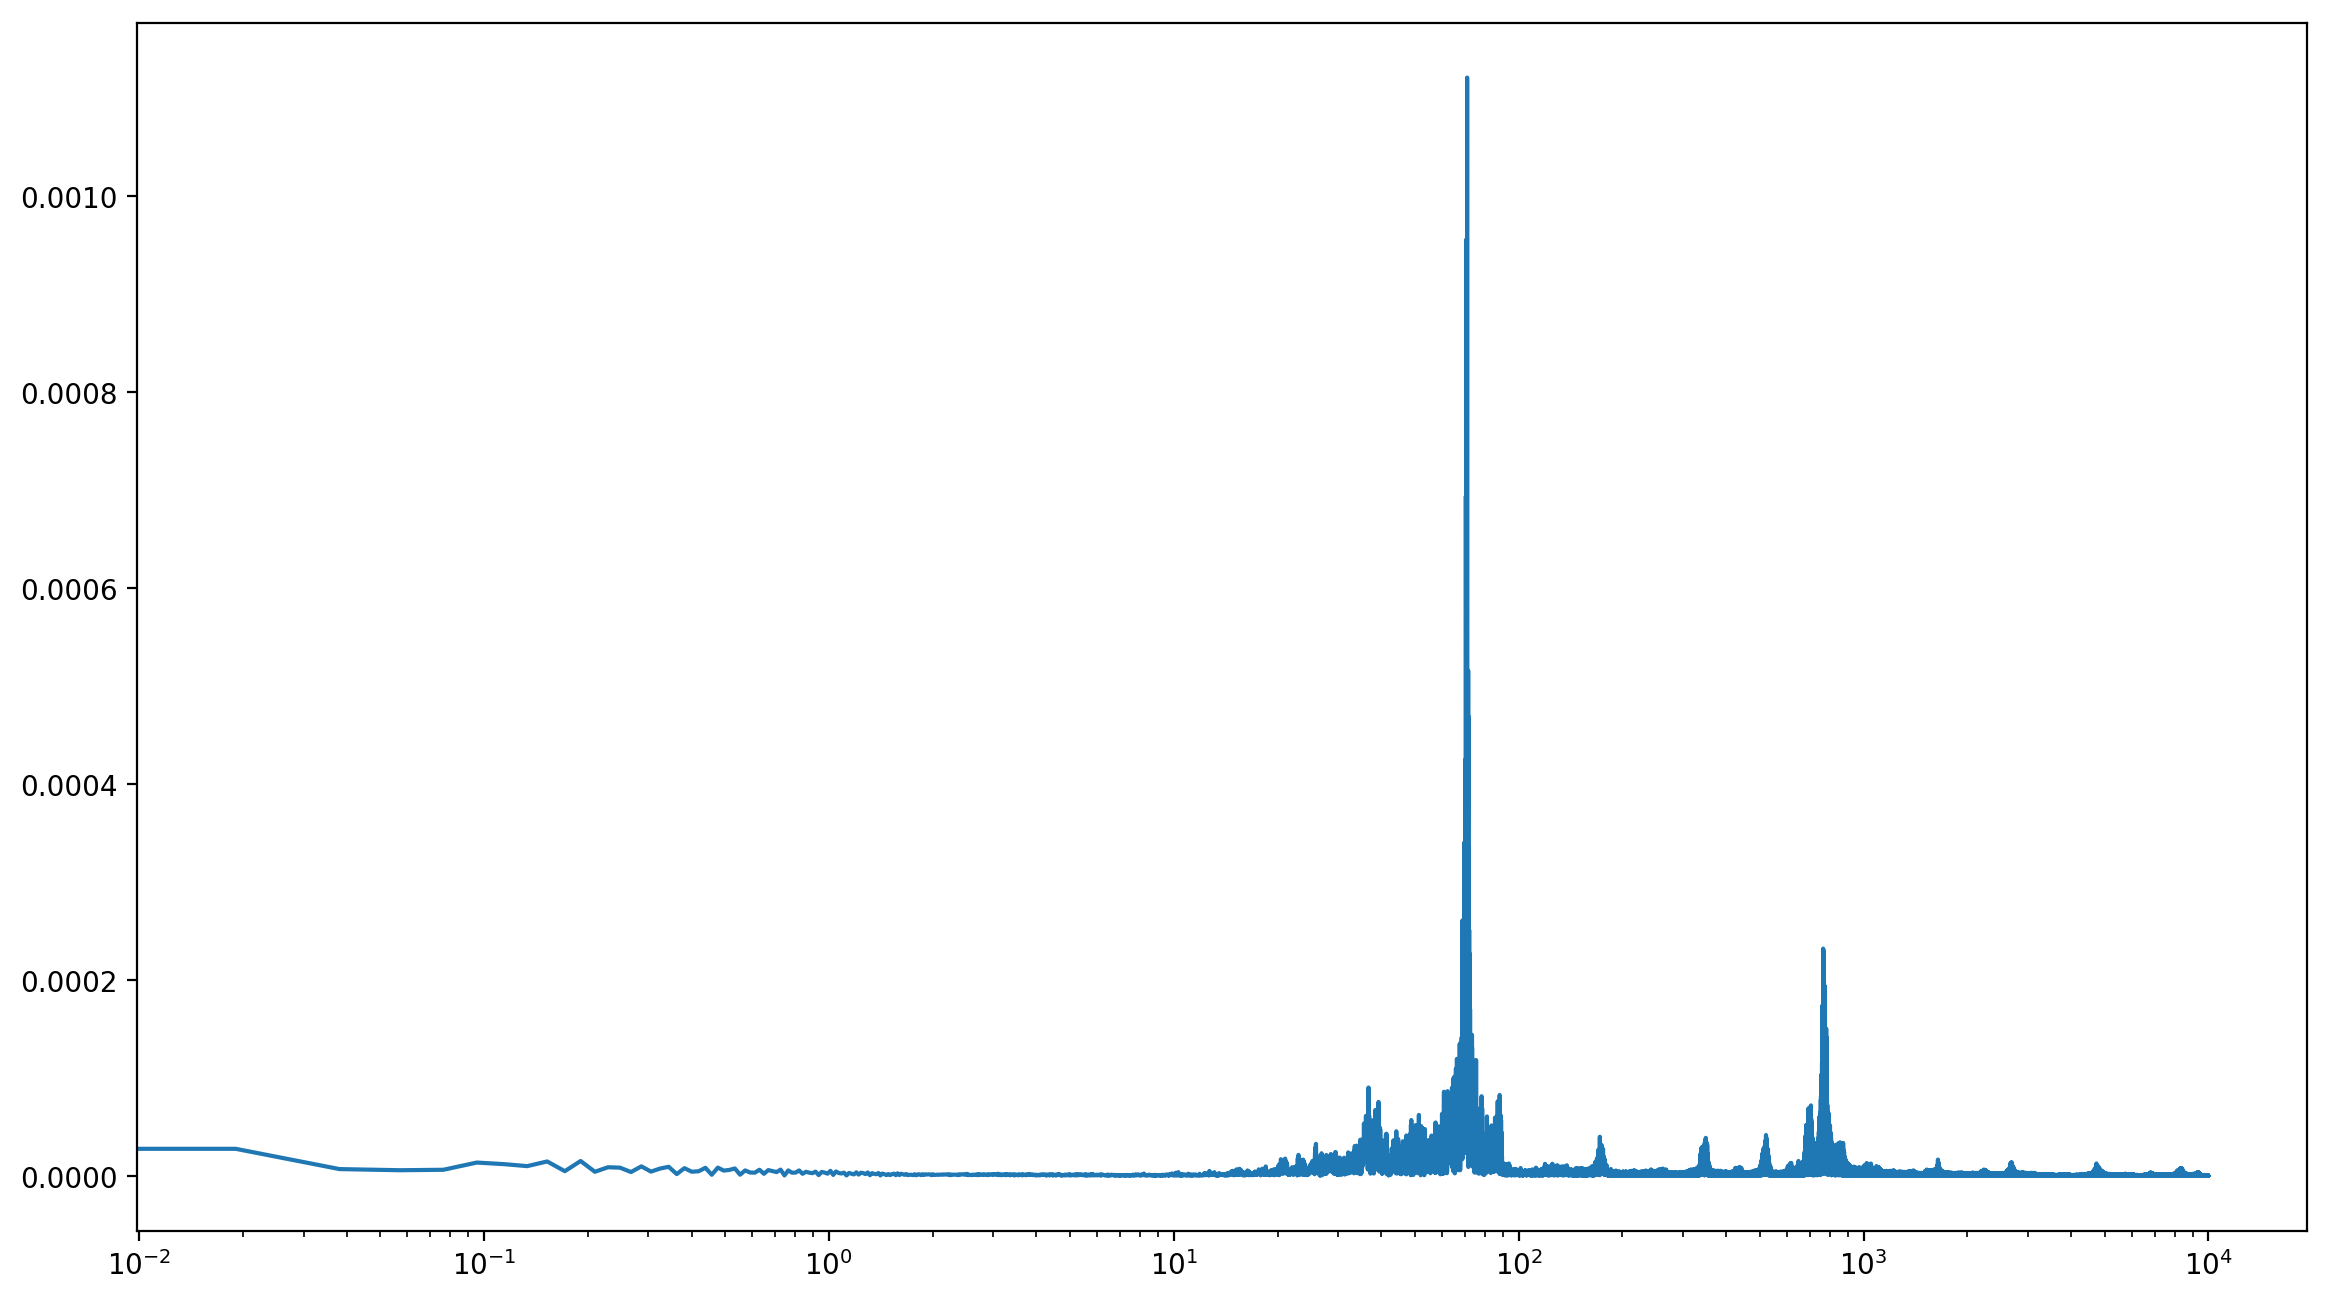

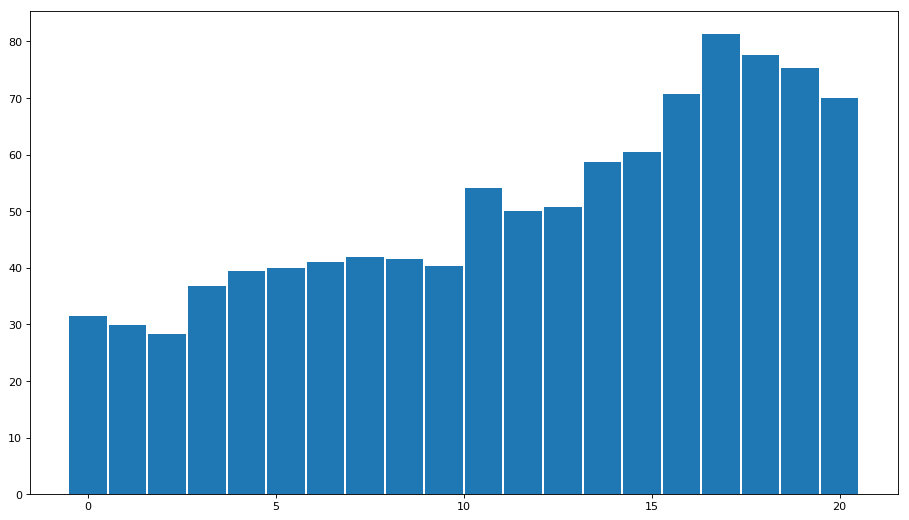

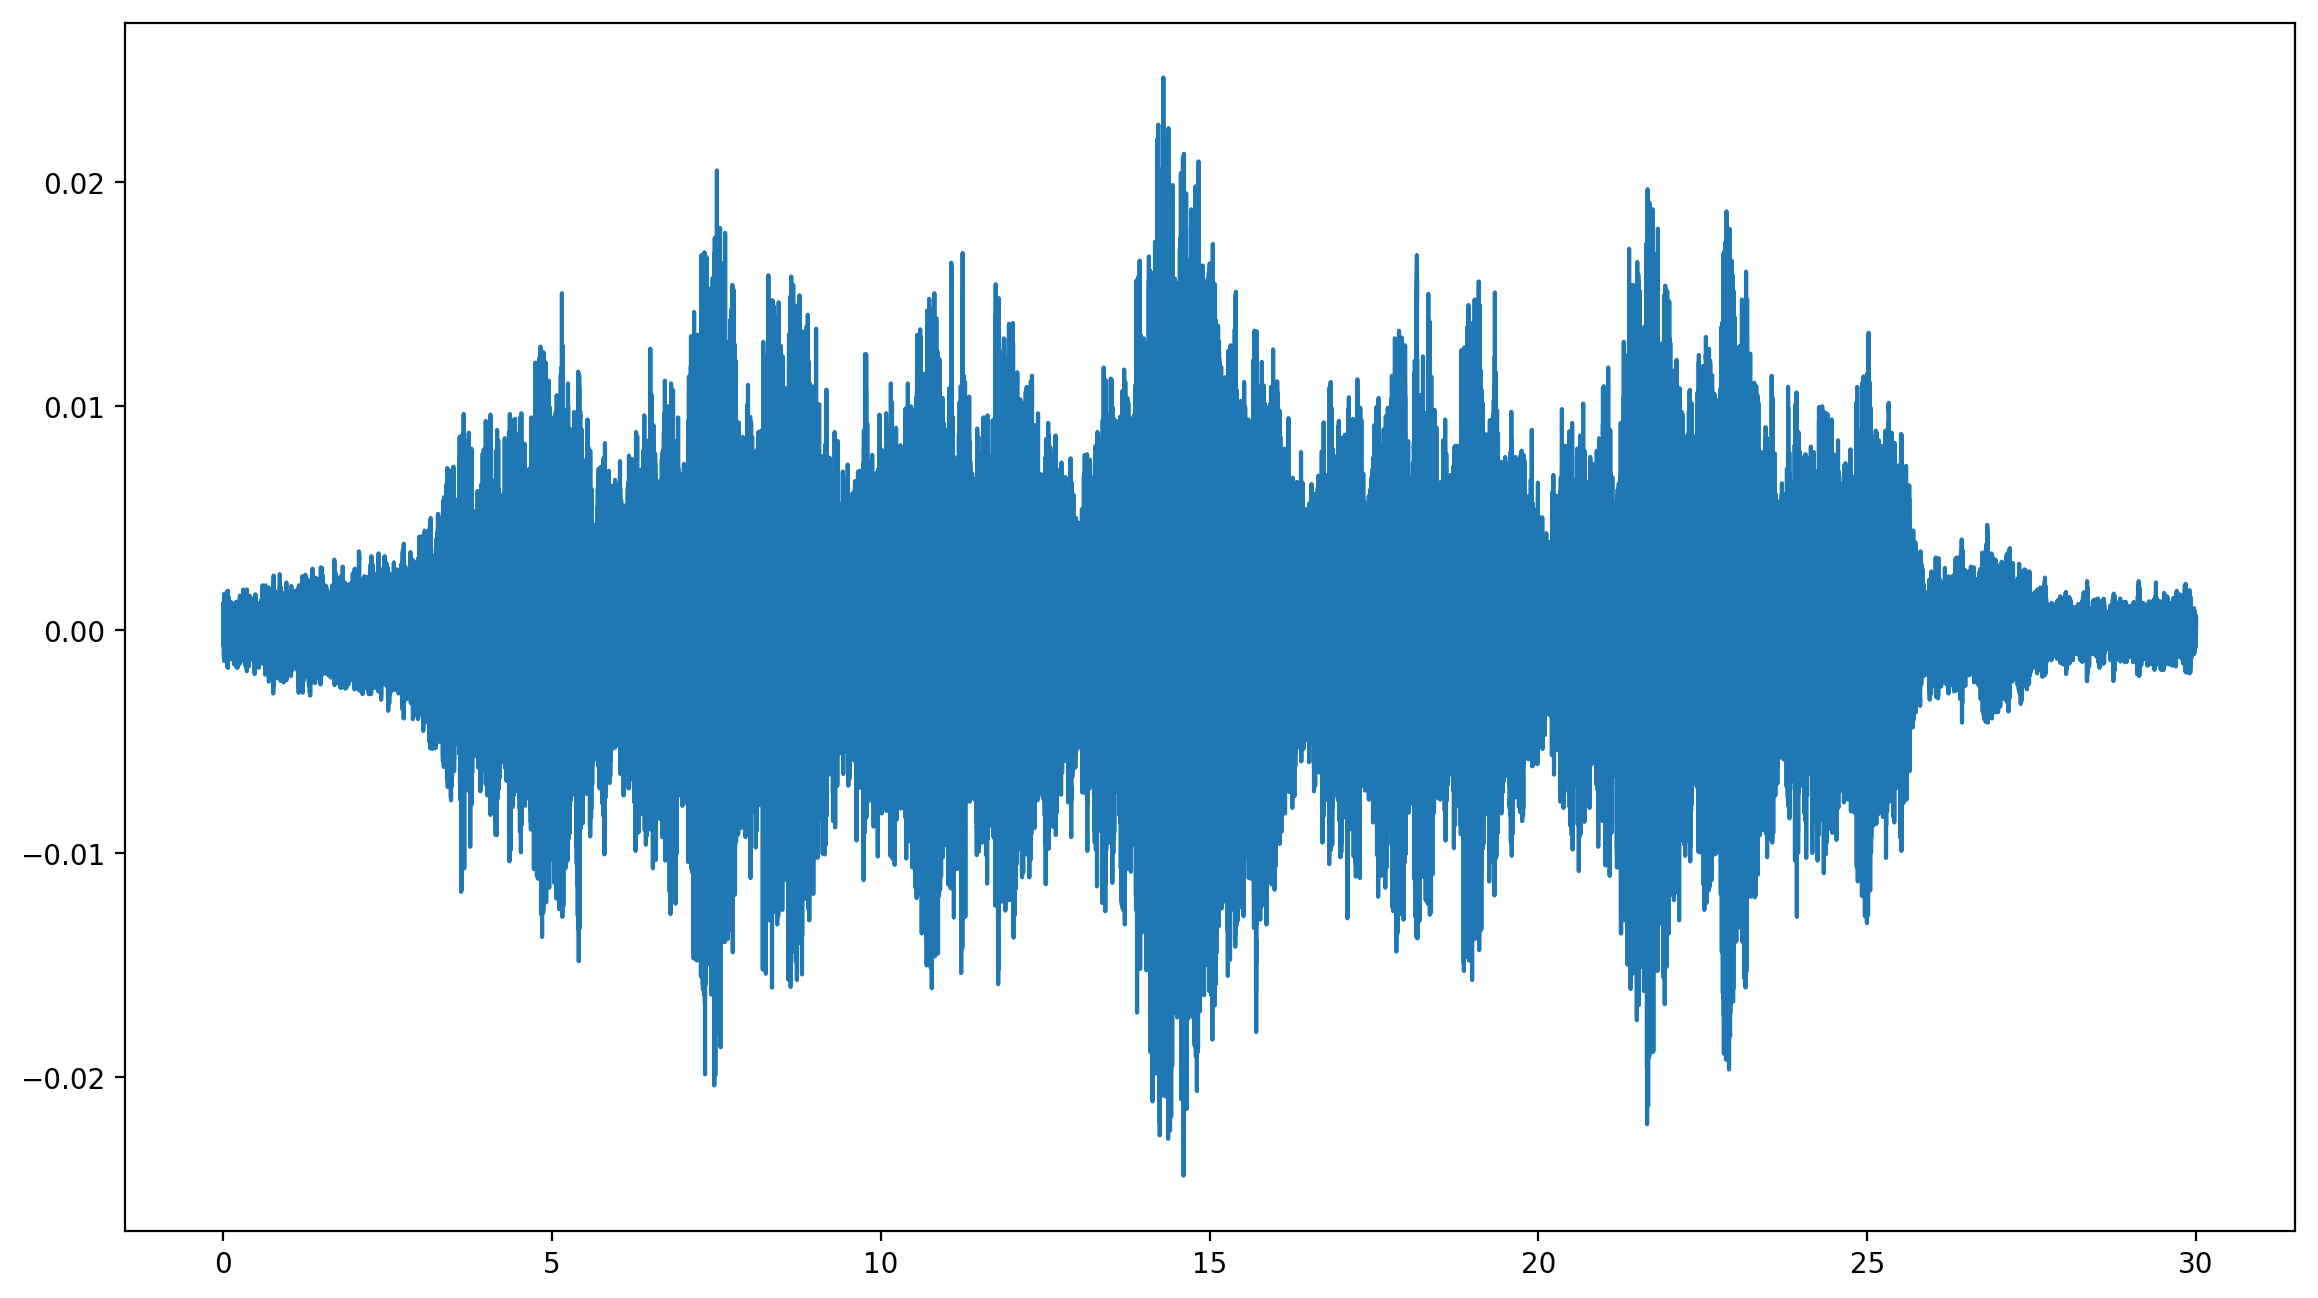

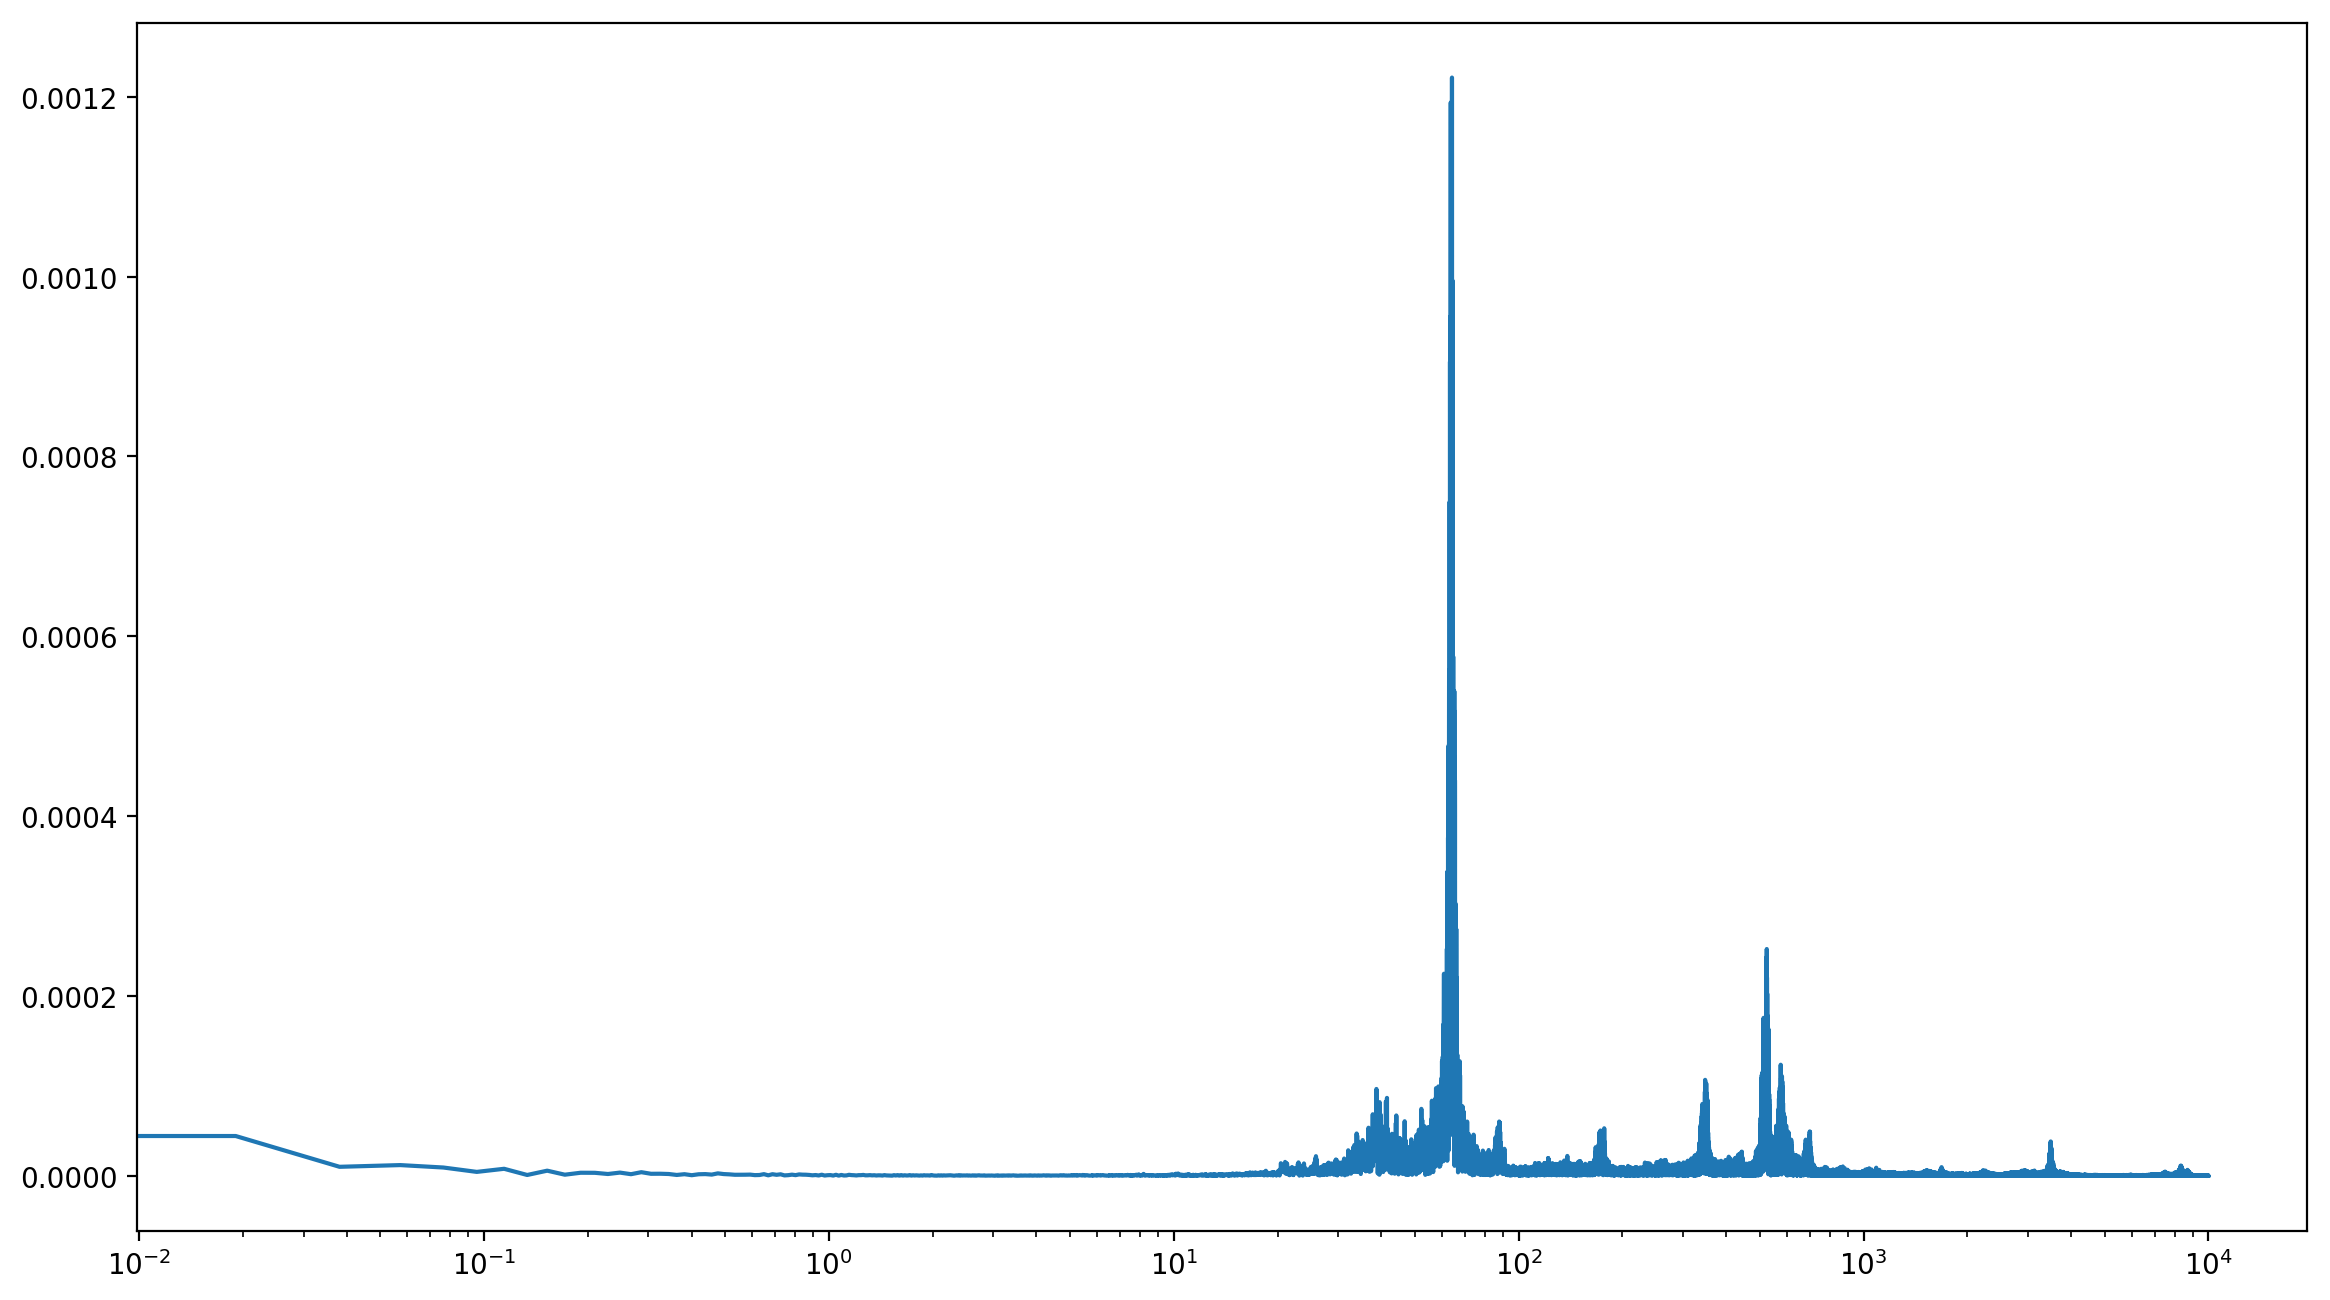

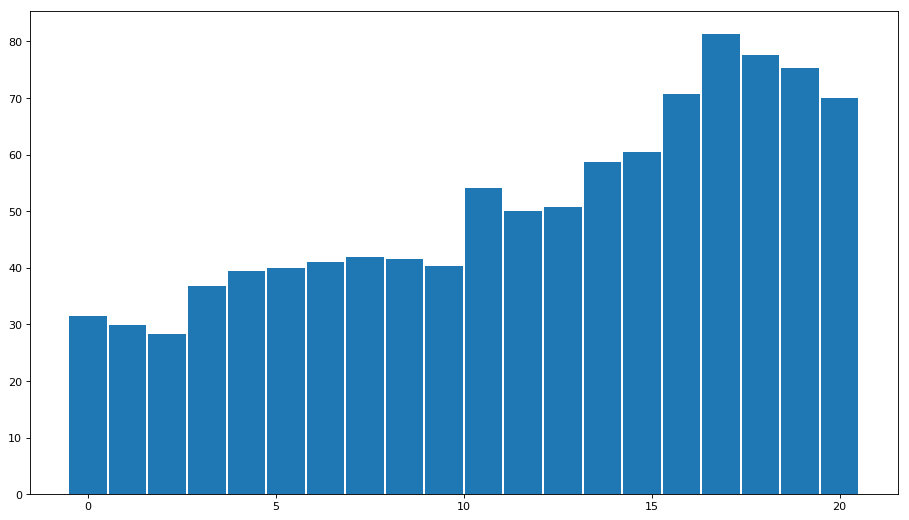

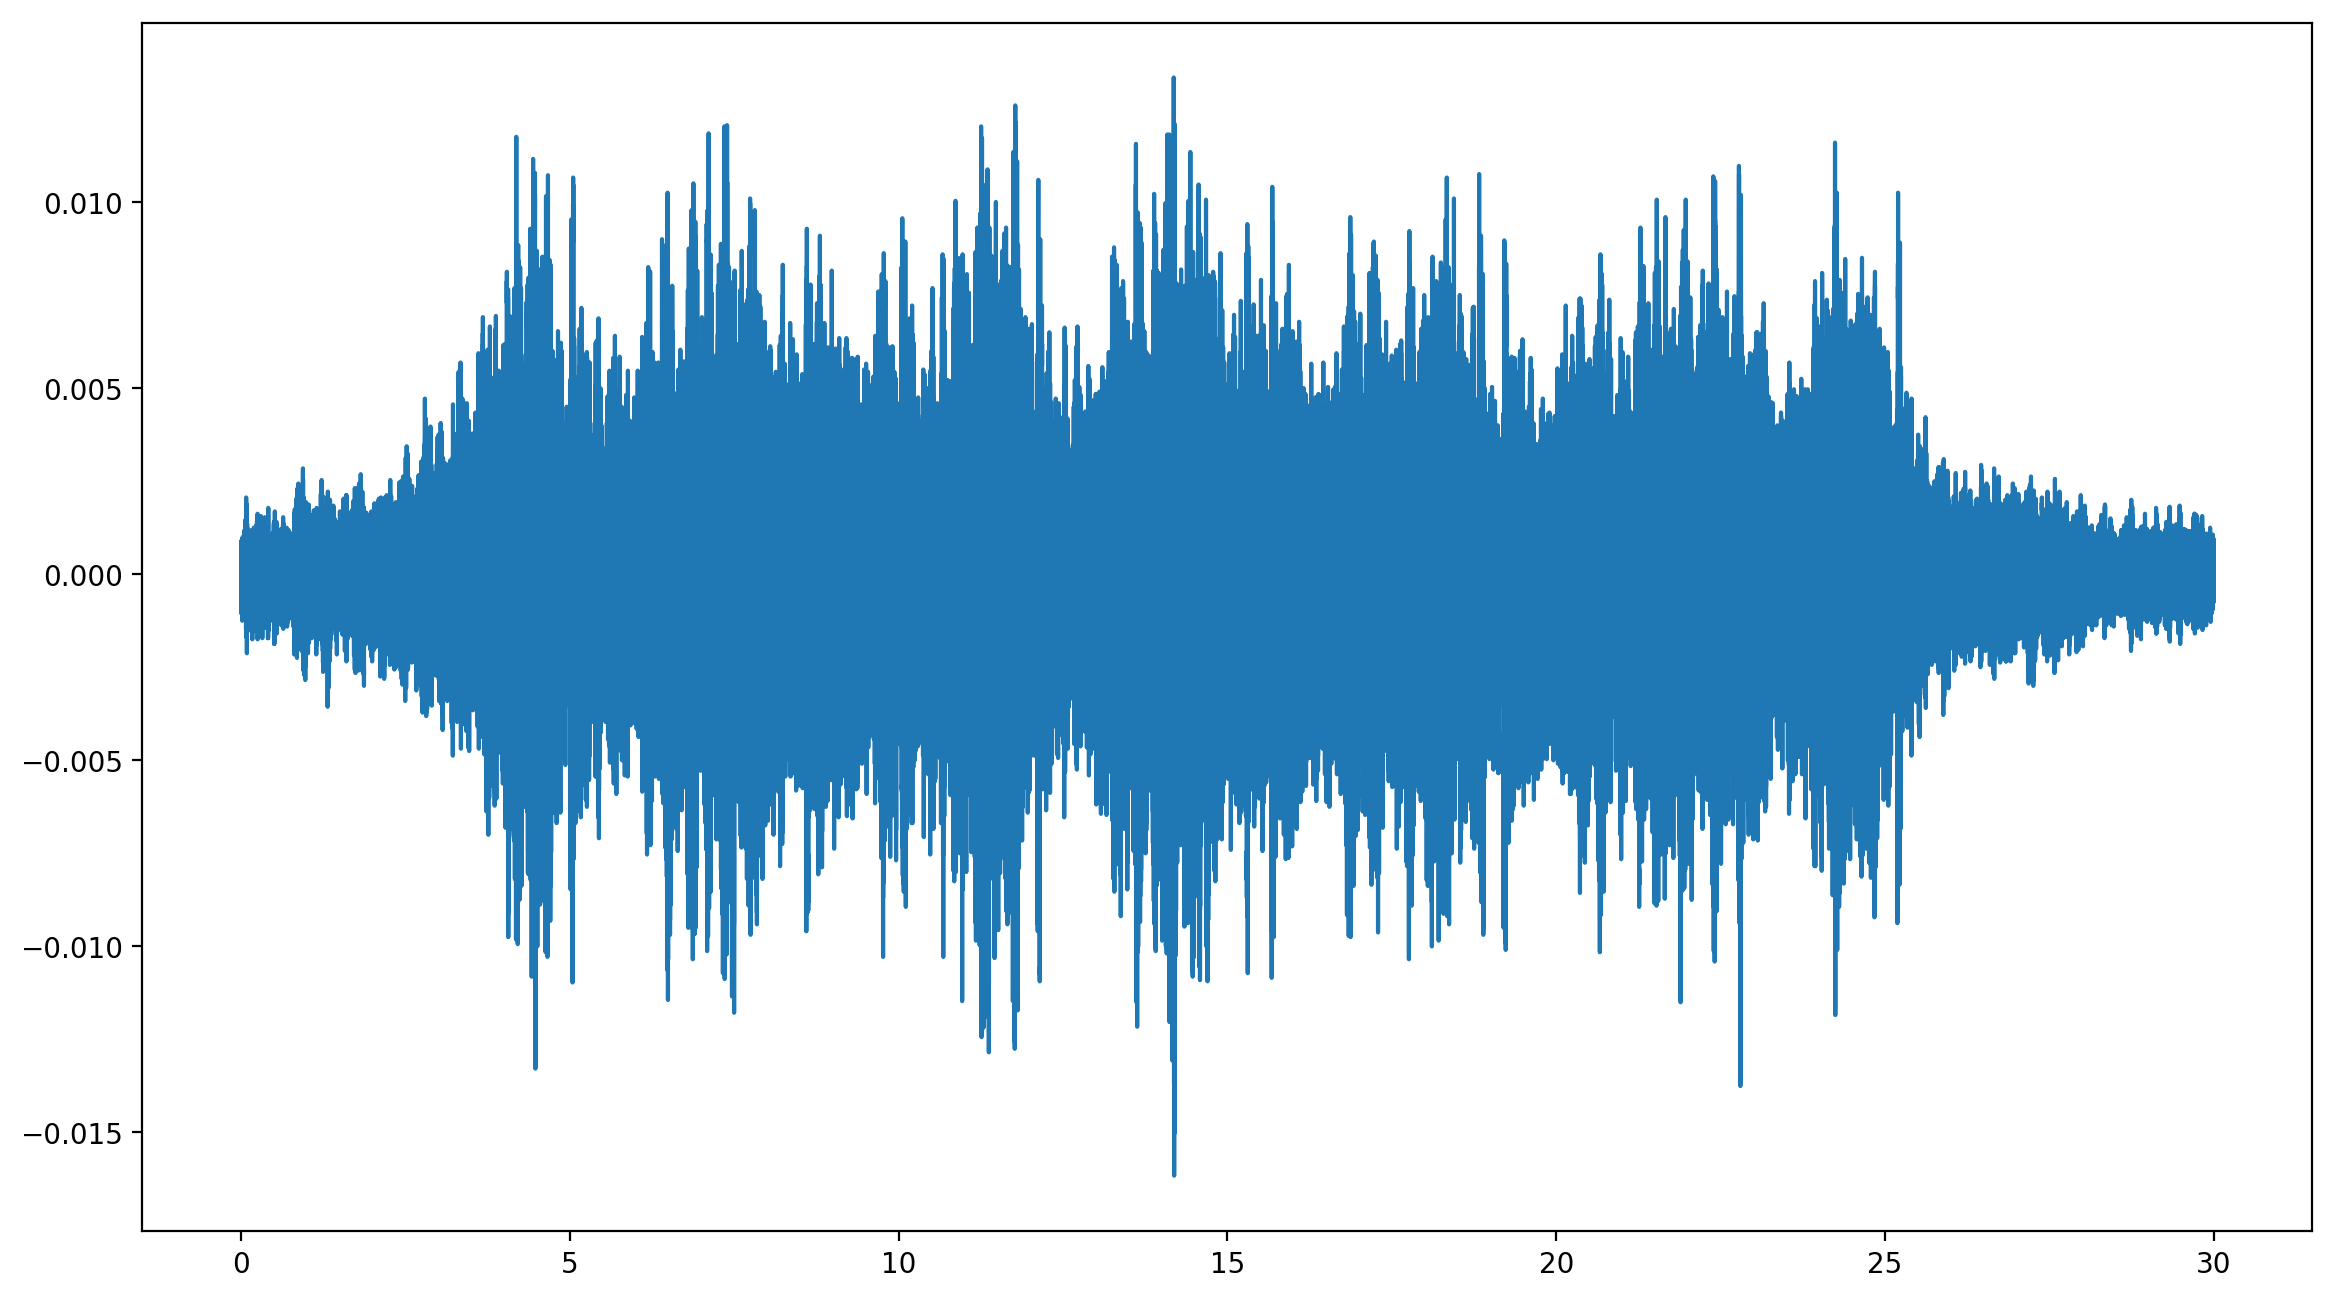

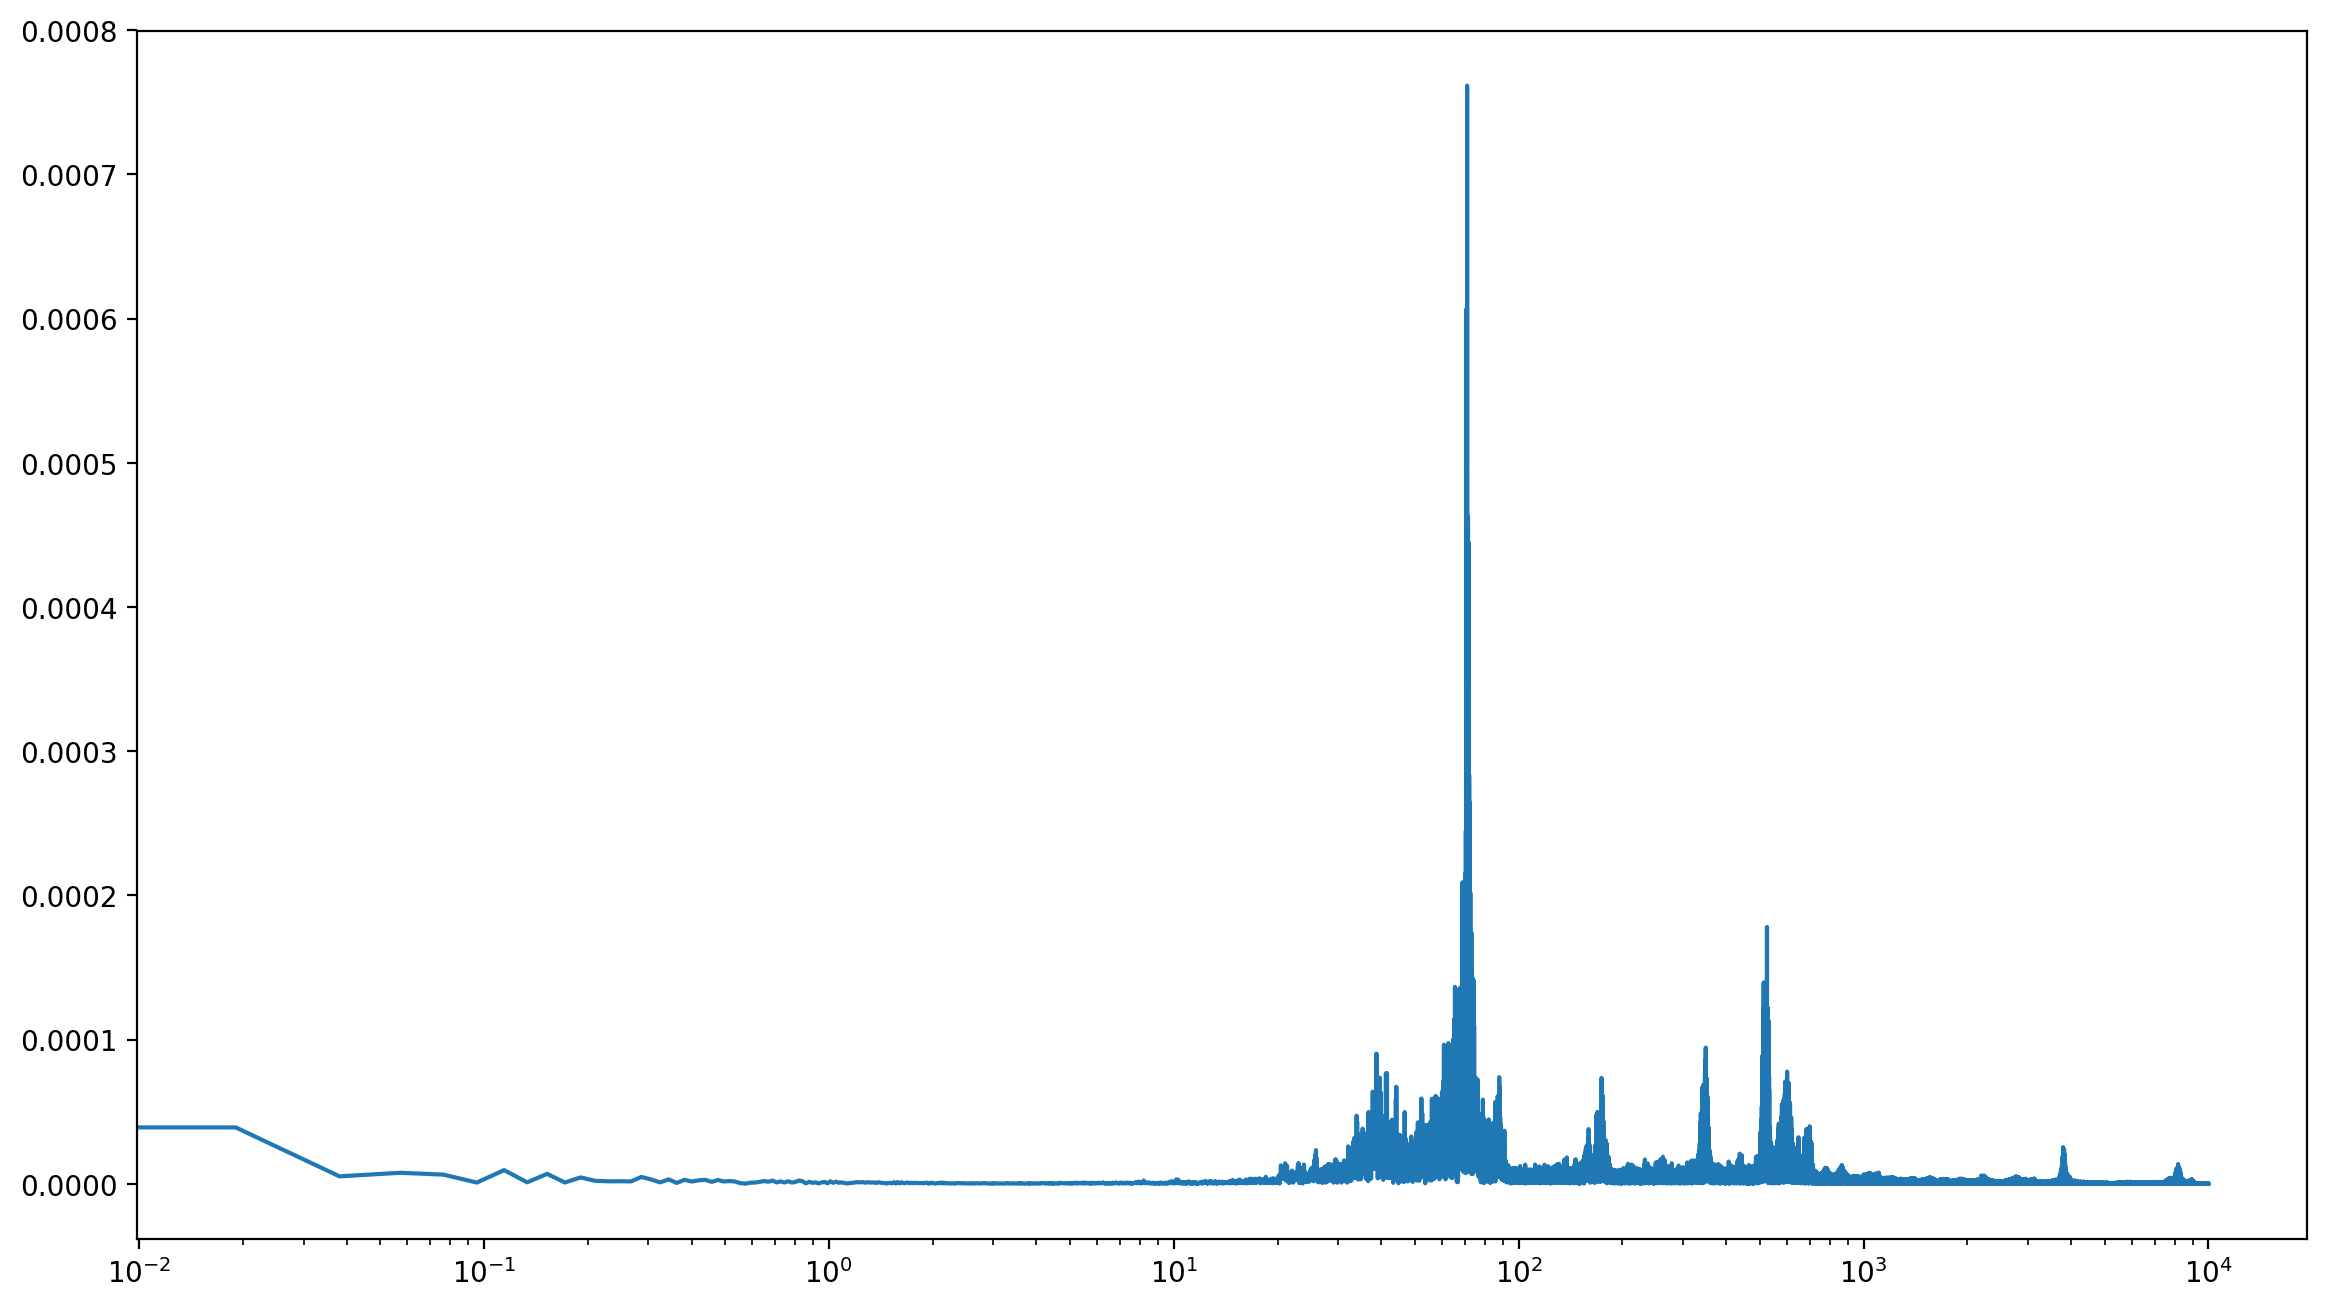

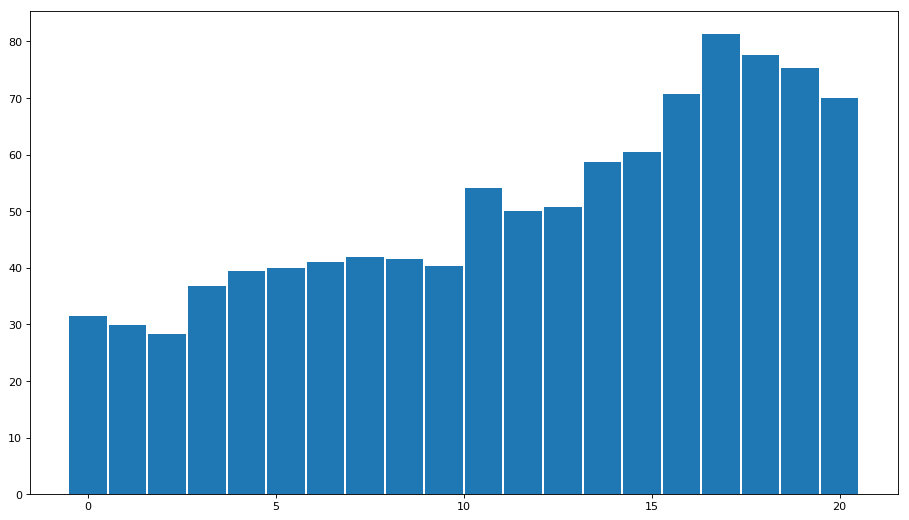

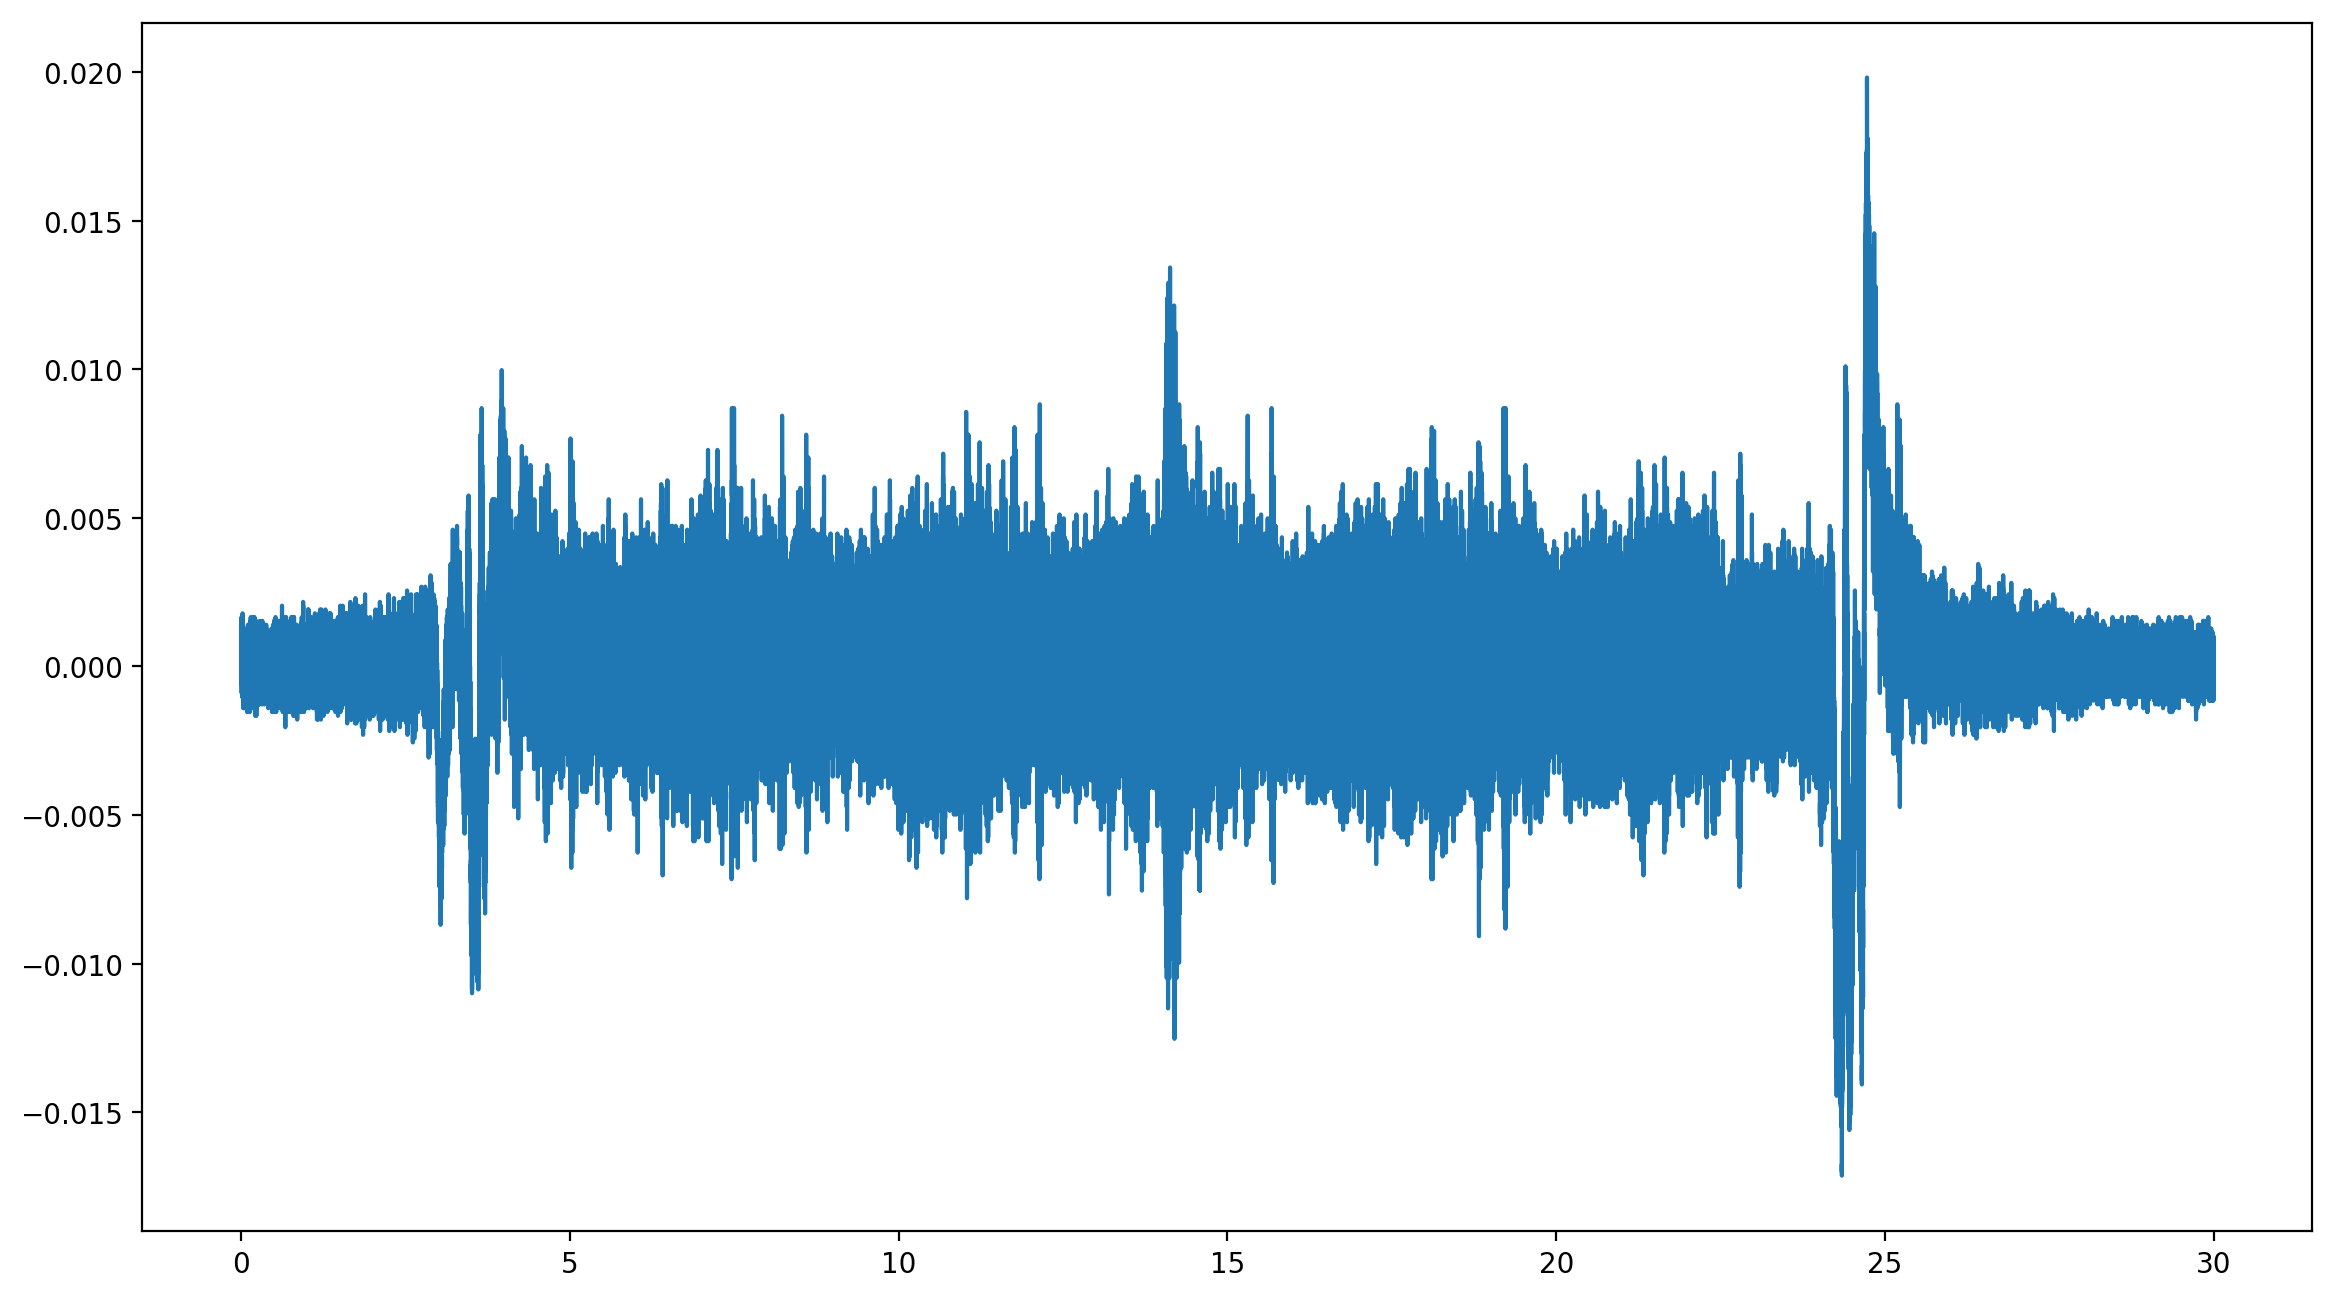

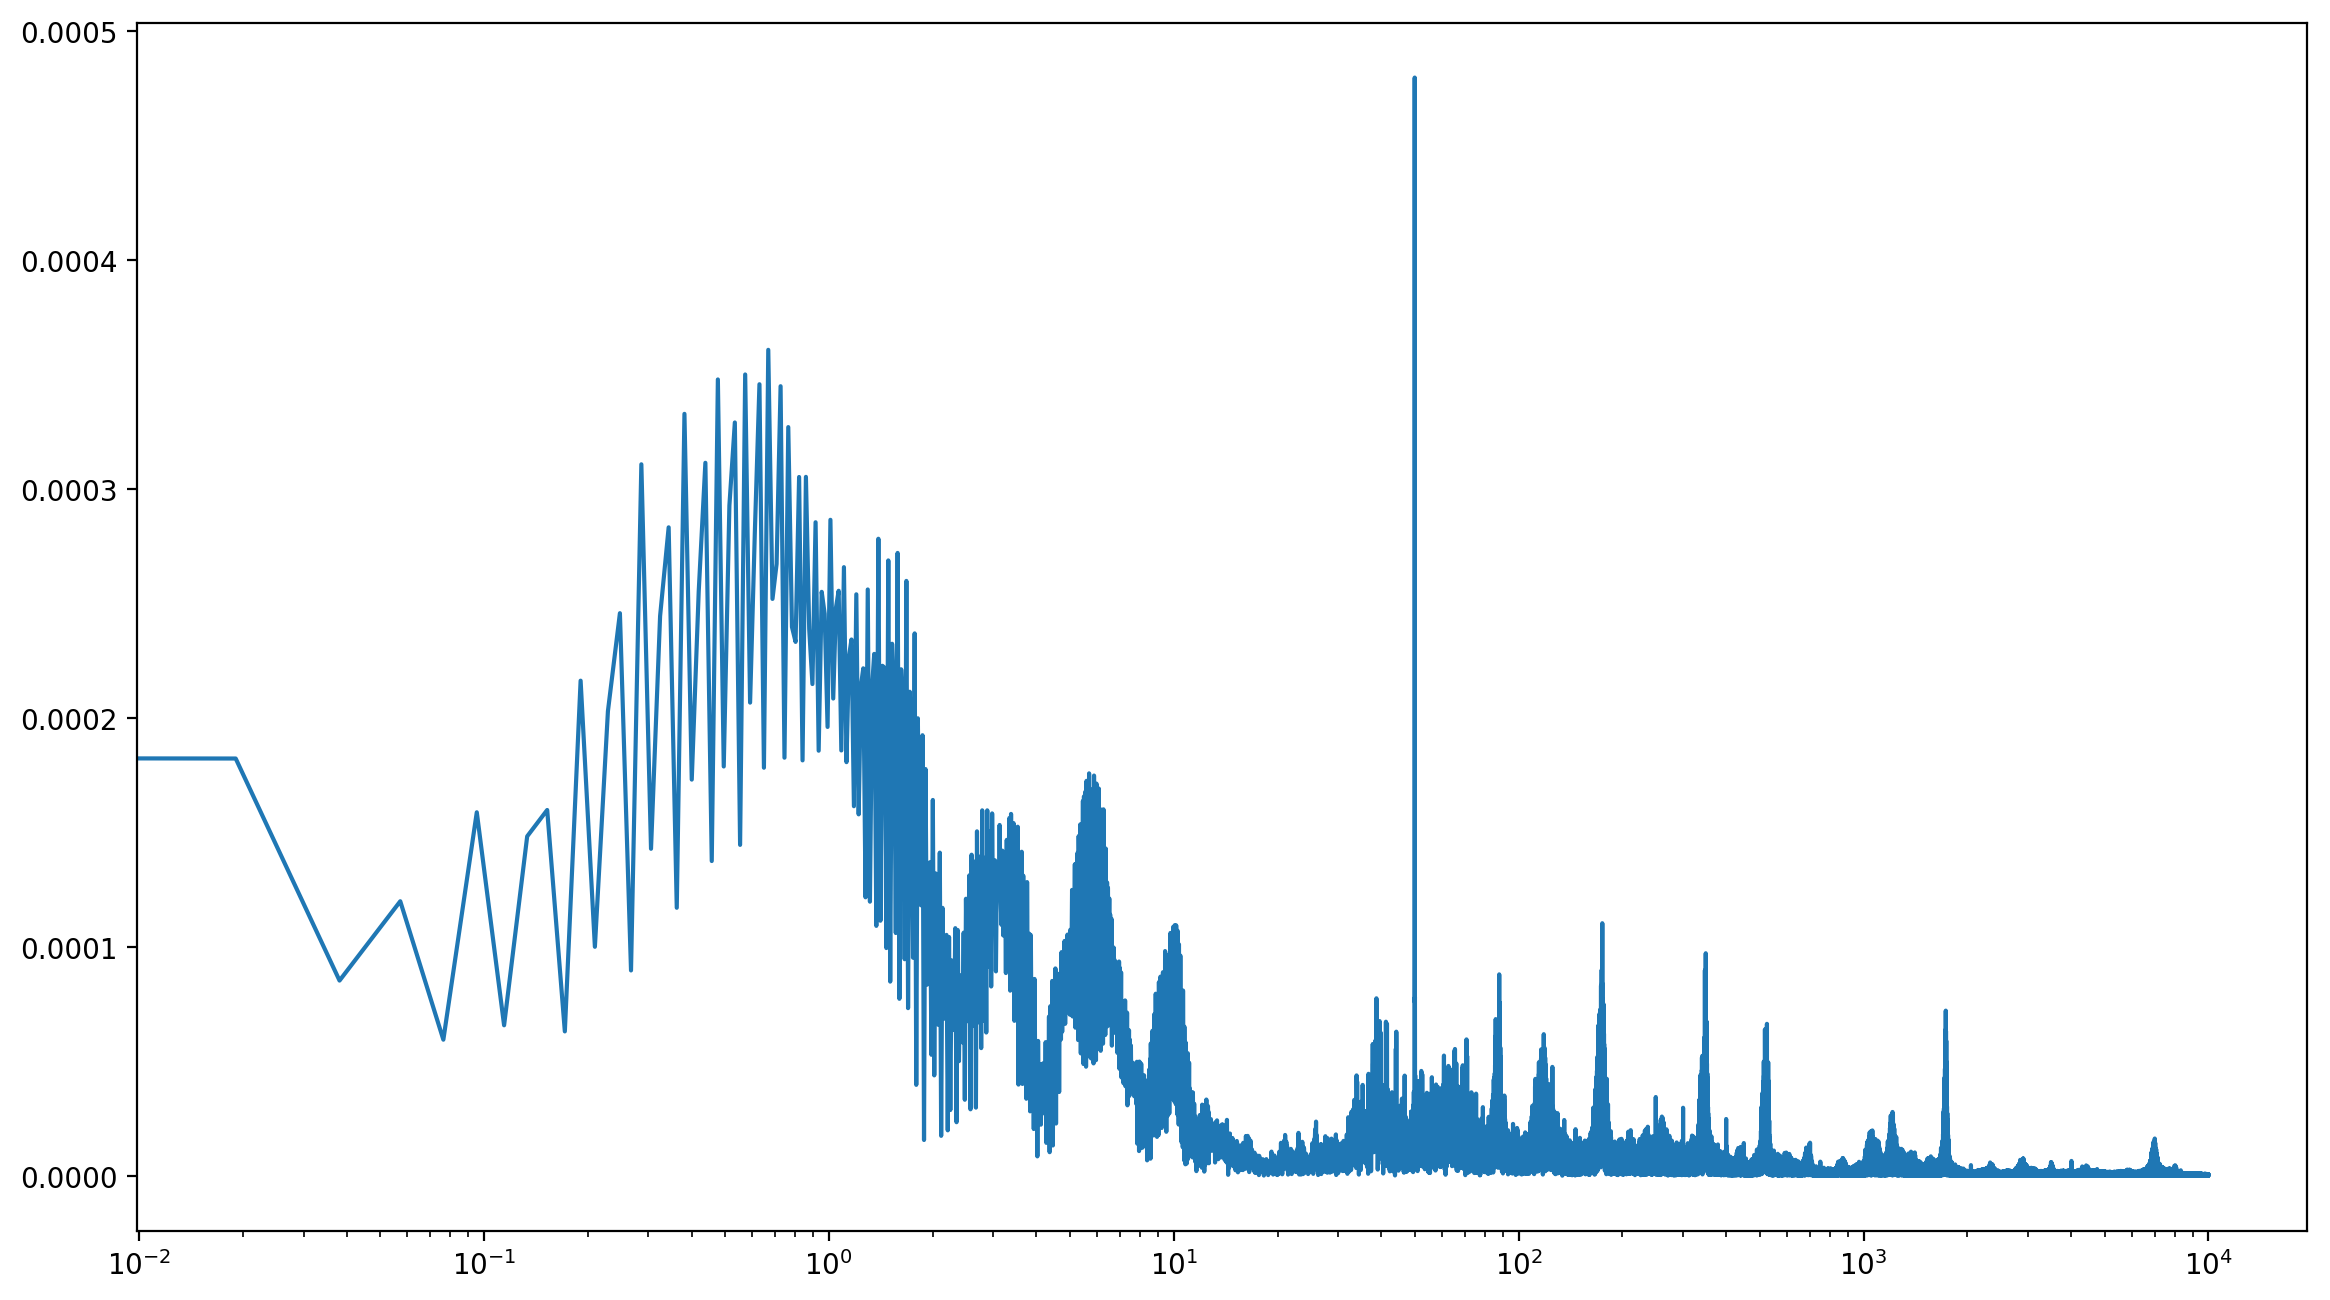

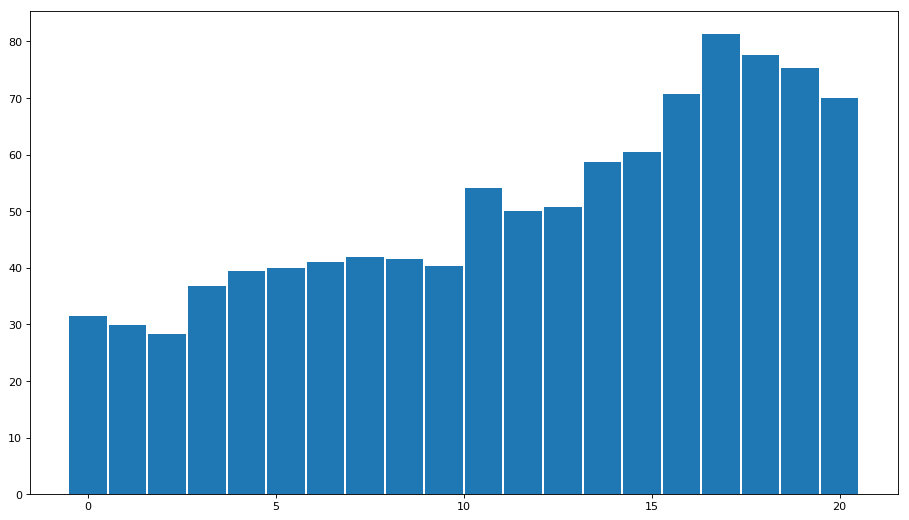

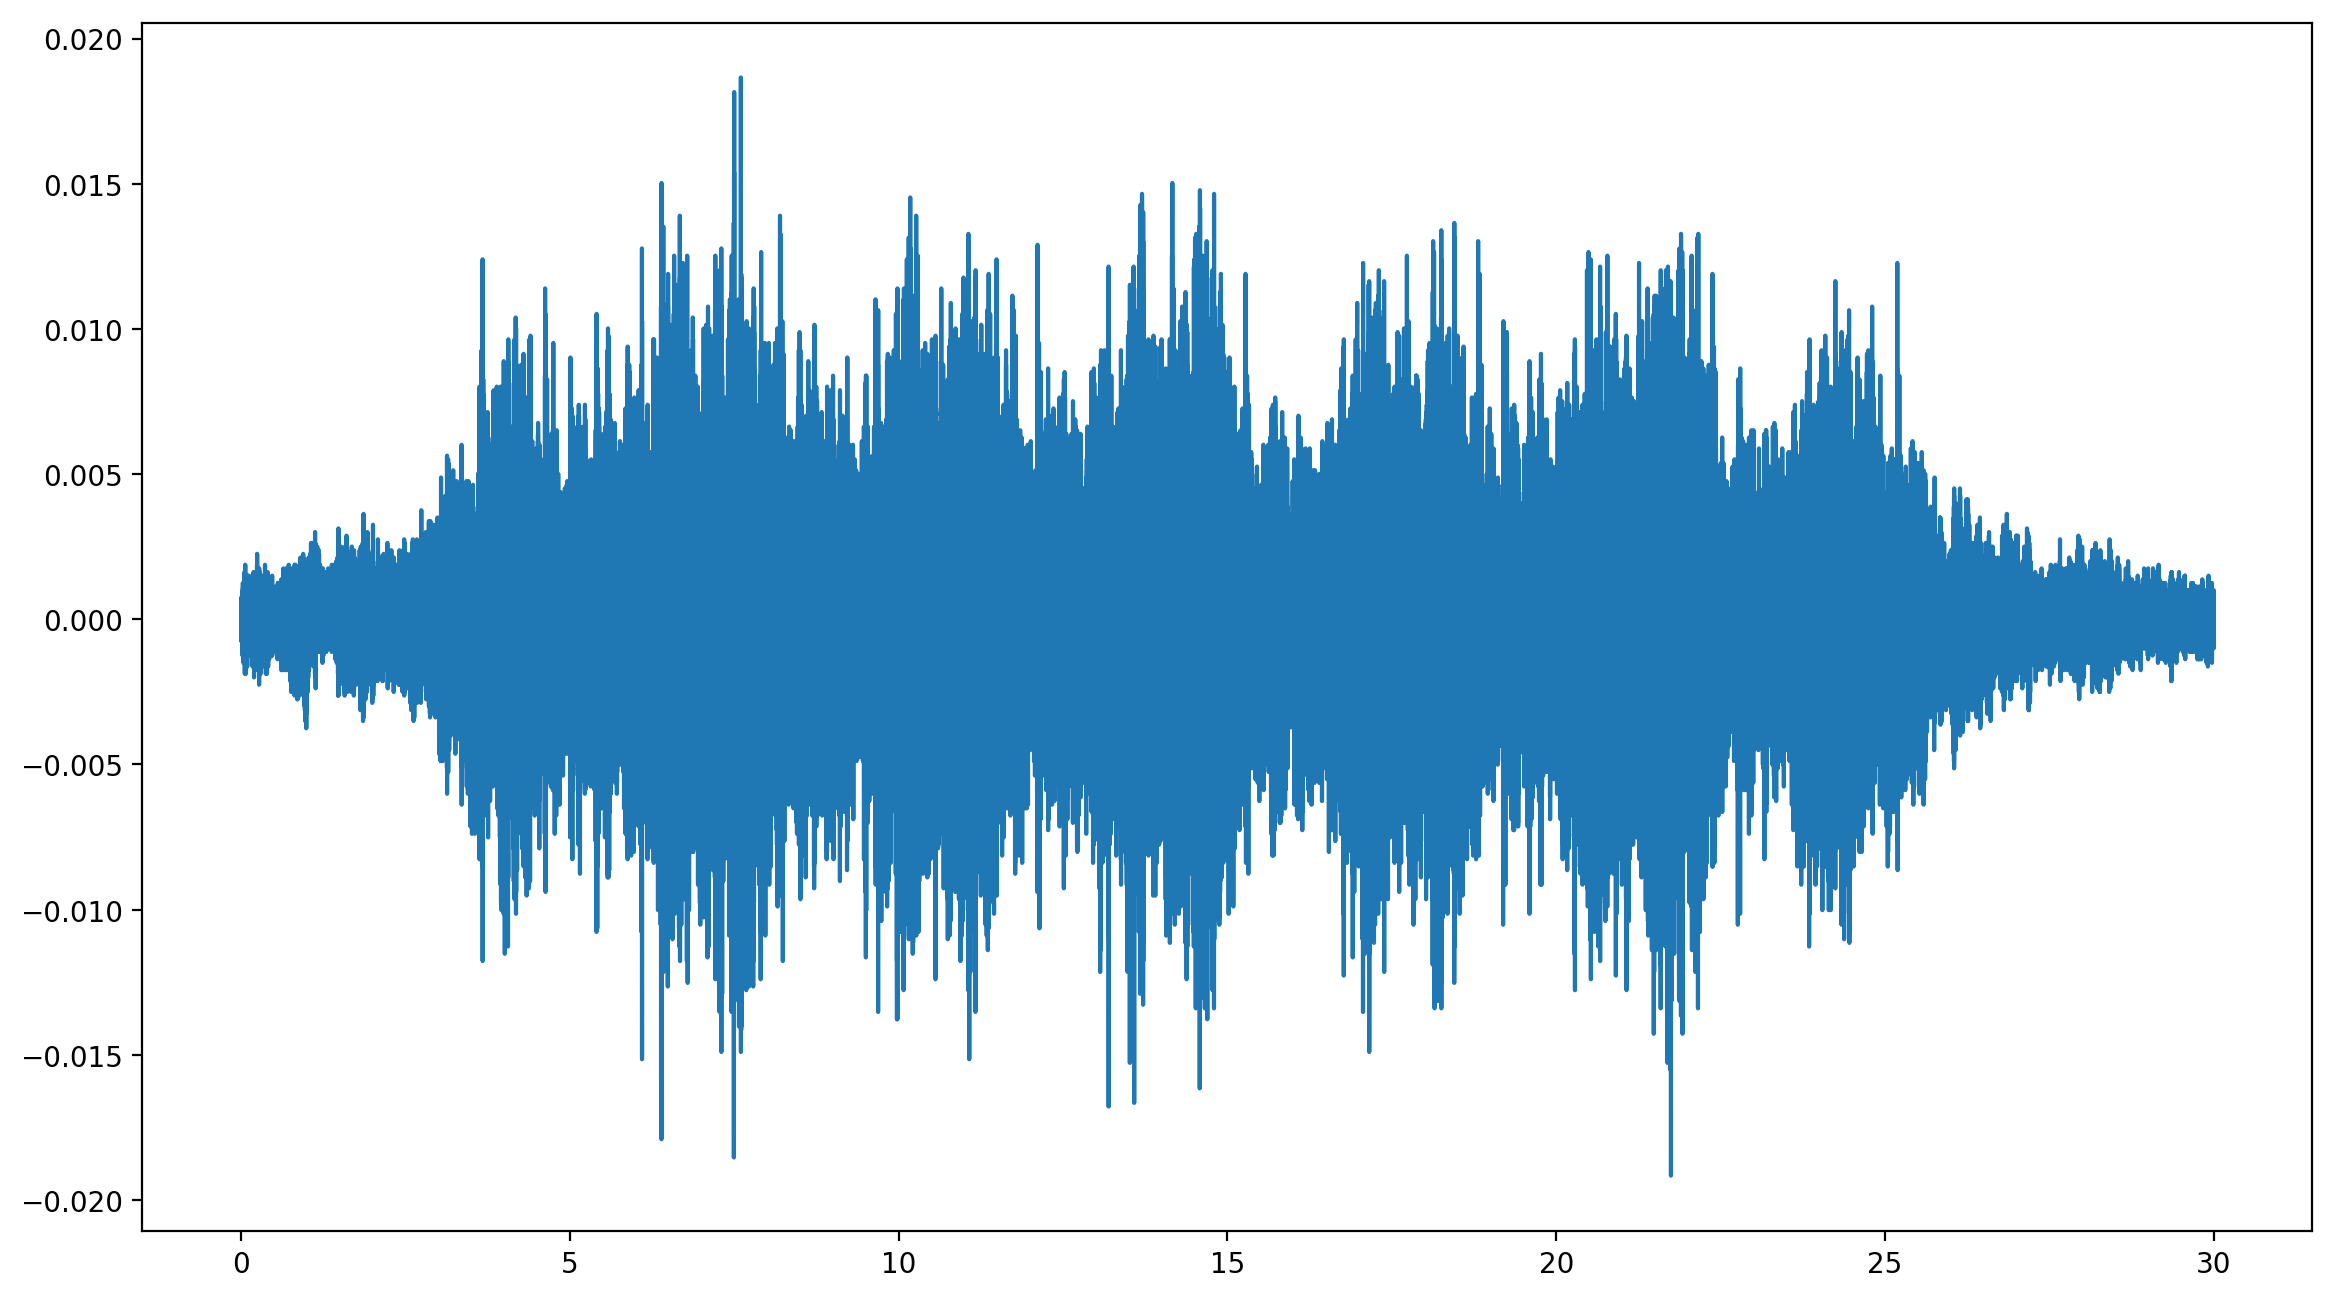

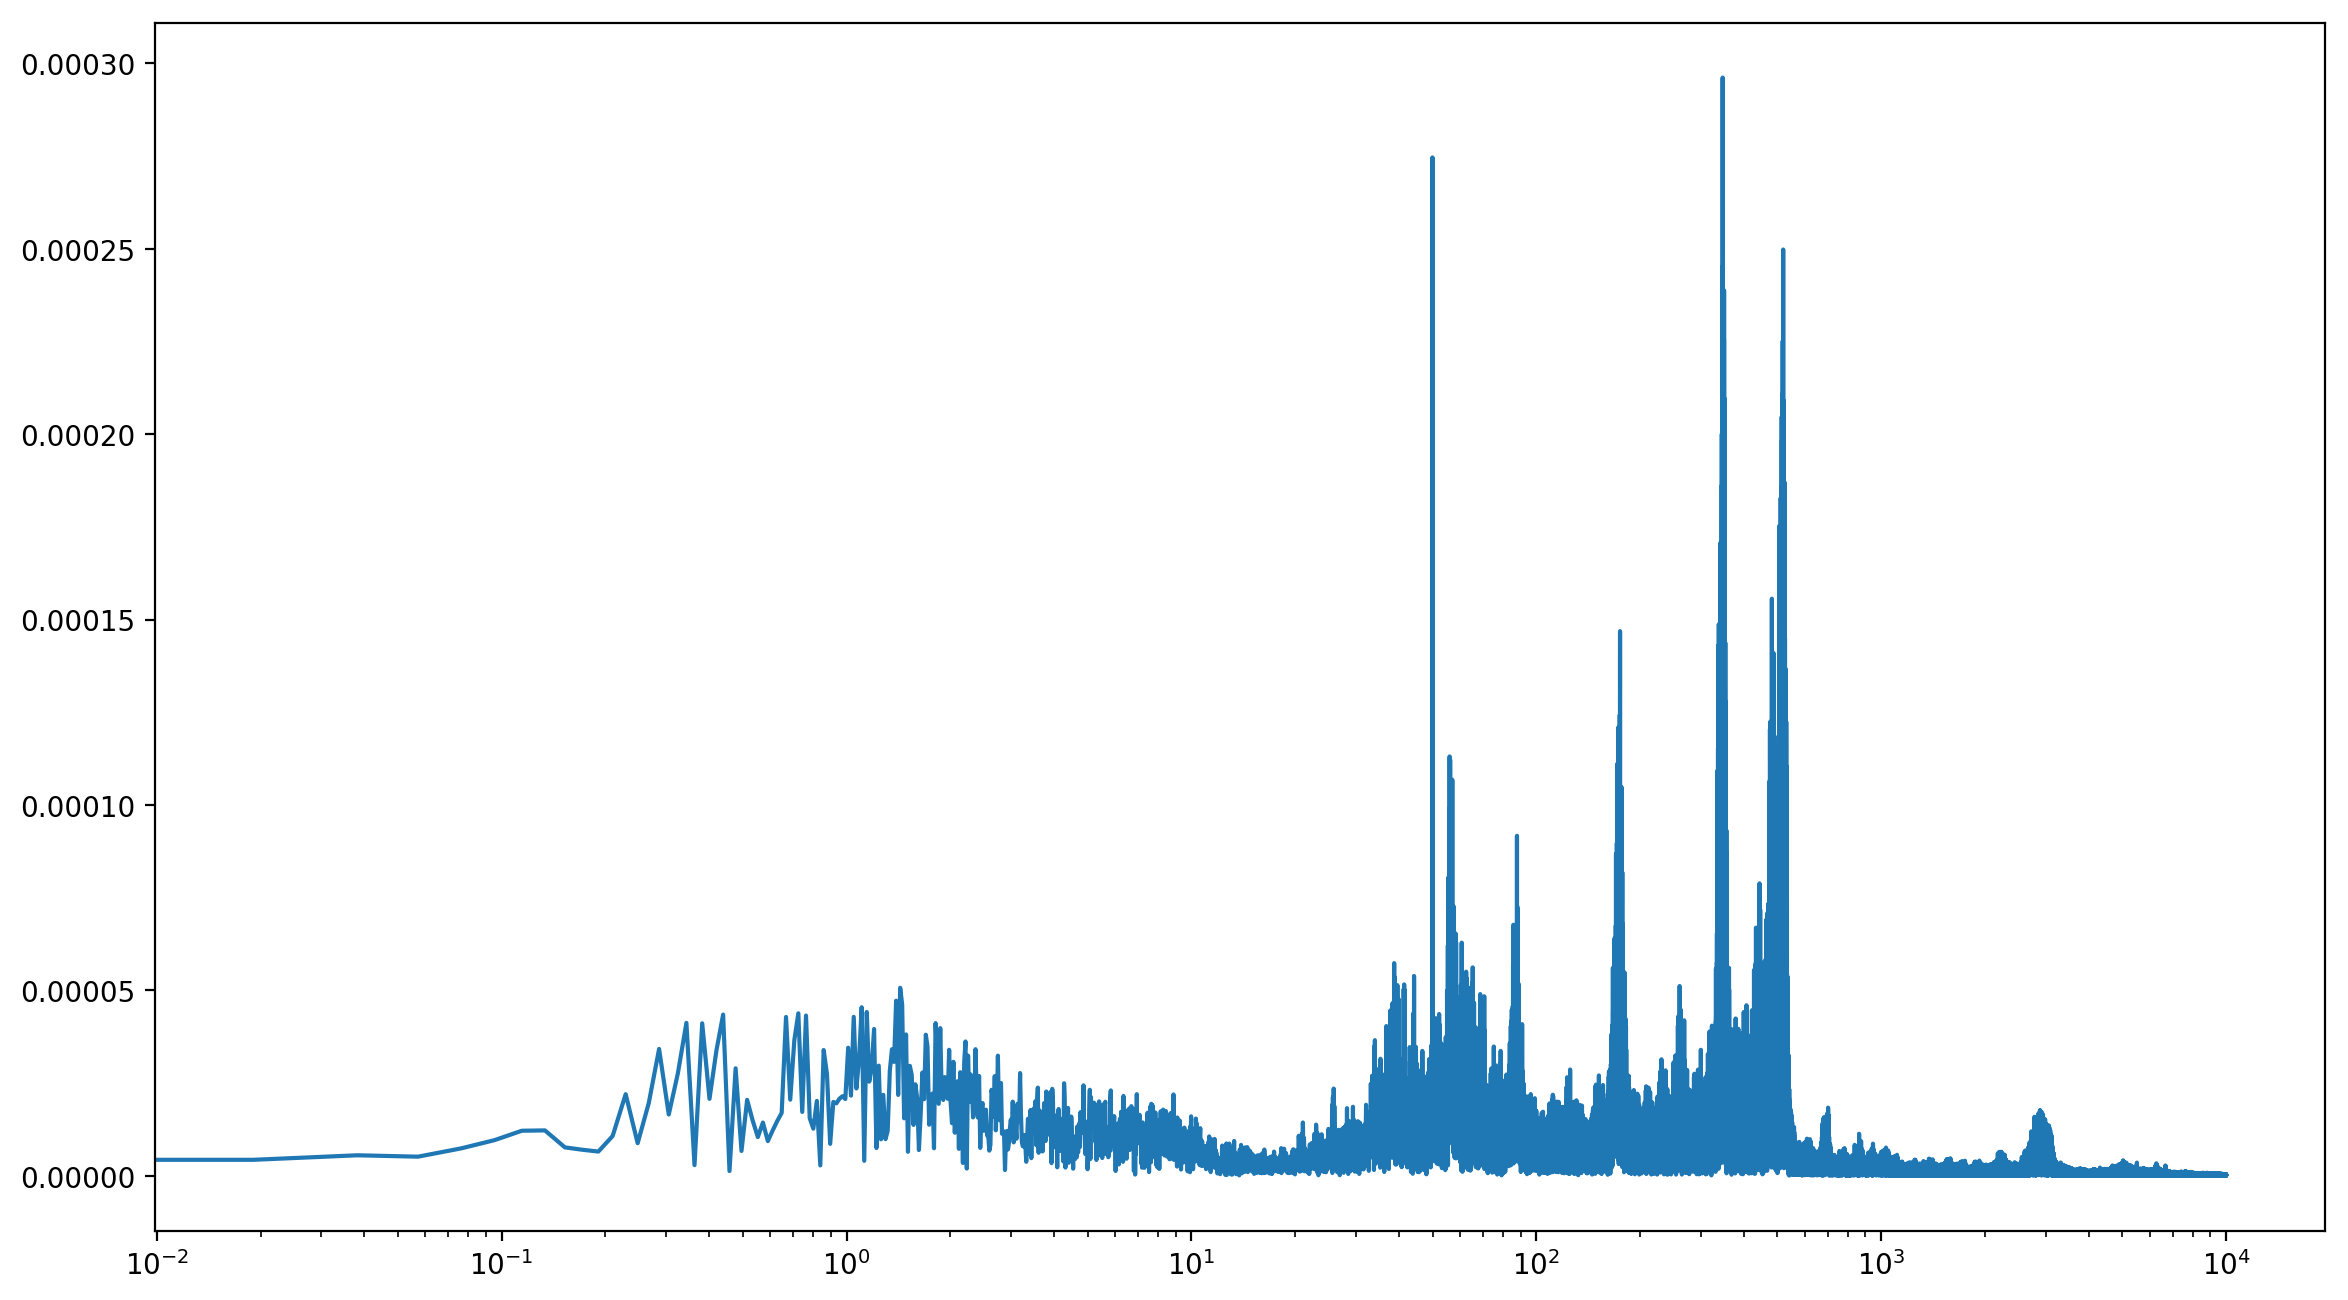

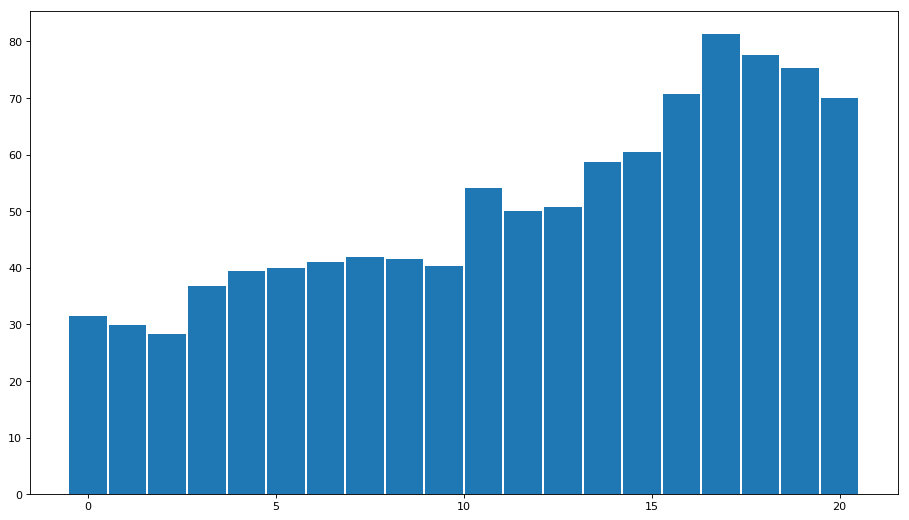

In [21]:
if __name__ == '__main__':
    
    #读入文件地址
    ads = 'C:/Users/44581/Desktop/test/7.31_6-8_1.xlsx'
    #采集频率
    measure_frqs = 20000
    
    for i in range(1,13):
        #out_non,out_Z, non, Z = calculate(ads, measure_frqs, freqs_3[22:37], Wght_fct[:20],i)
        out_non, non = calculate(ads, measure_frqs, freqs_3[22:37], Wght_fct[:20],i)
        print("number of chanal: " , i)
        print("non=",non)
        print(out_non)
        #print("Z=",Z)
        #print(out_Z)
        plt.figure(figsize=(14,8), dpi=80)
        plt.bar(np.linspace(0,20,20),out_Z,1,align='center')